# Package Insatallation

In [3]:
from utils.dataloader import DatasetLoader
from utils.preprocessing import DataProcessing
from utils.cases import Case

import numpy as np
import matplotlib.pyplot as plt

import shap
import pandas as pd
import xgboost as xgb
import optuna

from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler

from keras.models import Model,Sequential
from keras.layers import Dense, LSTM, Flatten
from keras.optimizers import Adam
from keras.backend import clear_session

from tensorflow_addons.metrics import RSquare
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# Static Variables

In [2]:
dataset_path = "data/dataset/"
blacklist_states = ['kansas', 'new mexico', 'california', 'arizona']

target = 'yield'


"""
Removing Features:
Static: OCS, Bulk density, CEC
Dynamic: lst_day, lst_night, fpar, tmin, vp, lai
"""

drop_dynamic_features = ['lst_day', 'lst_nigth', 'fpar', 'tmin', 'vp', 'lai']
drop_static_features = ['OCS', 'Bulk density', 'CEC' ]
drop_feature_list = drop_dynamic_features + drop_static_features


# Dataset Loader

In [3]:
loader = DatasetLoader(dataset_path)
datasets = loader.load_all_pickle_dataset()
dataset_dict = loader.get_state_names(datasets[0])
print(dataset_dict)

{'alabama': ['baldwin', 'calhoun', 'cherokee', 'coffee', 'covington', 'dale', 'dallas', 'elmore', 'escambia', 'geneva', 'henry', 'houston', 'lauderdale', 'lawrence', 'limestone', 'madison', 'mobile', 'monroe', 'shelby'], 'arizona': ['graham', 'maricopa', 'pinal', 'yuma'], 'arkansas': ['ashley', 'chicot', 'clay', 'craighead', 'crittenden', 'desha', 'drew', 'jefferson', 'lee', 'lincoln', 'mississippi', 'phillips', 'poinsett'], 'california': ['kings', 'merced', 'tulare'], 'georgia': ['appling', 'atkinson', 'baker', 'ben hill', 'berrien', 'bleckley', 'brooks', 'bulloch', 'burke', 'calhoun', 'candler', 'coffee', 'colquitt', 'cook', 'crisp', 'decatur', 'dodge', 'dooly', 'early', 'emanuel', 'grady', 'irwin', 'jeff davis', 'jefferson', 'jenkins', 'laurens', 'miller', 'mitchell', 'pierce', 'pulaski', 'randolph', 'screven', 'seminole', 'sumter', 'tattnall', 'terrell', 'thomas', 'tift', 'turner', 'webster', 'wilcox', 'worth'], 'kansas': ['pratt', 'sumner'], 'louisiana': ['catahoula', 'east carrol

In [4]:
for idx in range(len(blacklist_states)):
    del dataset_dict[blacklist_states[idx]]
    
city_count = sum(len(cities) for cities in dataset_dict.values())
print("Total number of cities:", city_count)

Total number of cities: 224


# Case 1 - 15th Day

In [5]:
c1 = Case(day=15,dynamic_drop=drop_dynamic_features,static_drop=drop_static_features)
c1_dfs, c1_scalers, c1_datas = c1.case_preprocessing(datasets,dataset_dict,target)

In [6]:
c1_dfs[0][2].dtypes

evi_4               float64
evi_5               float64
evi_6               float64
evi_7               float64
evi_8               float64
evi_9               float64
dayl_4              float64
dayl_5              float64
dayl_6              float64
dayl_7              float64
dayl_8              float64
dayl_9              float64
prcp_4              float64
prcp_5              float64
prcp_6              float64
prcp_7              float64
prcp_8              float64
prcp_9              float64
srad_4              float64
srad_5              float64
srad_6              float64
srad_7              float64
srad_8              float64
srad_9              float64
tmax_4              float64
tmax_5              float64
tmax_6              float64
tmax_7              float64
tmax_8              float64
tmax_9              float64
ssm_4               float64
ssm_5               float64
ssm_6               float64
ssm_7               float64
ssm_8               float64
ssm_9               

In [14]:
X_train_scaled =  c1_datas[0][0]
X_test_scaled  =  c1_datas[0][1]
y_train_scaled =  c1_datas[0][2]
y_test_scaled  =  c1_datas[0][3]
test           =  c1_datas[0][4]


print("Train: ", X_train_scaled.shape)
print("Test: ", X_test_scaled.shape)

print("Train: ", y_train_scaled.shape)
print("Test: ", y_test_scaled.shape)

print("yield:" , test.shape)

Train:  (880, 50)
Test:  (220, 50)
Train:  (880, 1)
Test:  (220, 1)
yield: (1100, 1)


## Optuna LSTM

In [16]:

best_score_lstm_1 = float('-inf')  # Initialize the best score
lstm1_model_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case1/lstm/best_model.h5'

def lstm_optuna(trial):
    clear_session()

    input_shape = (X_train_scaled.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_categorical('units', [16, 32, 64, 128]),
                   activation='tanh', input_shape=input_shape))
    model.add(Dense(1))

    learning_r = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    model.compile(loss='mse', optimizer=Adam(lr=learning_r), metrics=['mean_squared_error'])

    # Save the best model weights
    model_checkpoint = ModelCheckpoint(lstm1_model_path, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train_scaled, y_train_scaled, epochs=trial.suggest_int('epochs', 250, 450, 10),
              batch_size=8, validation_data=(X_test_scaled, y_test_scaled), callbacks=[model_checkpoint], verbose=0)

    model.load_weights(lstm1_model_path)  # Load the best weights saved during training

    y_pred = model.predict(X_test_scaled)
    score = r2_score(y_test_scaled, y_pred)

    global best_score_lstm_1
    if score > best_score_lstm_1:  # Update the best score and save the model weights
        best_score_lstm_1 = score
        model.save('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case1/lstm/best_model_weights.h5')

    return score

study_lstm = optuna.create_study(direction="maximize")
study_lstm.optimize(lstm_optuna, n_trials=50)

print("Number of finished trials: {}".format(len(study_lstm.trials)))

print("Best trial:")
trial_lstm = study_lstm.best_trial

print("  Value: {}".format(trial_lstm.value))

print("  Params: ")
for key, value in trial_lstm.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-10 21:16:42,919] A new study created in memory with name: no-name-887047a8-40cc-424a-b636-65c80790a443


7/7 [==============================] - 2s 3ms/step


[I 2023-11-10 21:19:18,217] Trial 0 finished with value: 0.4721334684187072 and parameters: {'units': 16, 'lr': 0.0007506582542465987, 'epochs': 270}. Best is trial 0 with value: 0.4721334684187072.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-10 21:24:26,103] Trial 1 finished with value: 0.6605788606350236 and parameters: {'units': 64, 'lr': 0.000694112460470789, 'epochs': 330}. Best is trial 1 with value: 0.6605788606350236.


7/7 [==============================] - 0s 18ms/step


[I 2023-11-10 21:36:18,626] Trial 2 finished with value: 0.6278597015772651 and parameters: {'units': 128, 'lr': 0.0002617080091367385, 'epochs': 450}. Best is trial 1 with value: 0.6605788606350236.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-10 21:39:23,561] Trial 3 finished with value: 0.3234910957743786 and parameters: {'units': 16, 'lr': 0.0002738447388525788, 'epochs': 330}. Best is trial 1 with value: 0.6605788606350236.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-10 21:42:33,324] Trial 4 finished with value: 0.5143341303096709 and parameters: {'units': 32, 'lr': 0.0005222753146477624, 'epochs': 320}. Best is trial 1 with value: 0.6605788606350236.


7/7 [==============================] - 0s 16ms/step


[I 2023-11-10 21:48:57,694] Trial 5 finished with value: 0.6797054467019925 and parameters: {'units': 128, 'lr': 0.000771331871822327, 'epochs': 260}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-10 21:52:40,399] Trial 6 finished with value: 0.6145150689157912 and parameters: {'units': 64, 'lr': 0.0006598438883659722, 'epochs': 280}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-10 21:55:29,558] Trial 7 finished with value: 0.42865230040663993 and parameters: {'units': 32, 'lr': 0.00030737341725151426, 'epochs': 280}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-10 21:58:37,516] Trial 8 finished with value: 0.6094434660546978 and parameters: {'units': 32, 'lr': 0.0008135424471325131, 'epochs': 310}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 1s 17ms/step


[I 2023-11-10 22:07:11,062] Trial 9 finished with value: 0.5798333383151835 and parameters: {'units': 128, 'lr': 0.0002065784782105711, 'epochs': 340}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 13ms/step


[I 2023-11-10 22:17:19,225] Trial 10 finished with value: 0.5081883711414368 and parameters: {'units': 128, 'lr': 0.00013437461428249164, 'epochs': 390}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-10 22:23:20,517] Trial 11 finished with value: 0.6521441325548083 and parameters: {'units': 64, 'lr': 0.0004551834949211847, 'epochs': 400}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 1s 4ms/step


[I 2023-11-10 22:29:05,191] Trial 12 finished with value: 0.675328024353436 and parameters: {'units': 64, 'lr': 0.0009591082261697021, 'epochs': 380}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-10 22:34:48,632] Trial 13 finished with value: 0.6683032451831308 and parameters: {'units': 64, 'lr': 0.000943210922889934, 'epochs': 380}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 14ms/step


[I 2023-11-10 22:41:12,247] Trial 14 finished with value: 0.65311588644467 and parameters: {'units': 128, 'lr': 0.0009978013806757244, 'epochs': 250}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 6ms/step


[I 2023-11-10 22:45:59,924] Trial 15 finished with value: 0.6307933369619099 and parameters: {'units': 64, 'lr': 0.0004720894305266789, 'epochs': 370}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 13ms/step


[I 2023-11-10 22:56:46,996] Trial 16 finished with value: 0.6372750298587844 and parameters: {'units': 128, 'lr': 0.000999234721263712, 'epochs': 430}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-10 23:00:00,567] Trial 17 finished with value: 0.5021190069130405 and parameters: {'units': 16, 'lr': 0.0006112334326865638, 'epochs': 360}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 17ms/step


[I 2023-11-10 23:11:05,274] Trial 18 finished with value: 0.6345599407867926 and parameters: {'units': 128, 'lr': 0.00040263396860357826, 'epochs': 420}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-10 23:15:44,657] Trial 19 finished with value: 0.6258513971137439 and parameters: {'units': 64, 'lr': 0.000585182633617393, 'epochs': 310}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 18ms/step


[I 2023-11-10 23:26:55,921] Trial 20 finished with value: 0.6491418534491699 and parameters: {'units': 128, 'lr': 0.0007810725100428531, 'epochs': 410}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-10 23:33:19,240] Trial 21 finished with value: 0.6607756003204783 and parameters: {'units': 64, 'lr': 0.000989057342502813, 'epochs': 380}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 6ms/step


[I 2023-11-10 23:39:33,056] Trial 22 finished with value: 0.6573464580854846 and parameters: {'units': 64, 'lr': 0.0008396192867978089, 'epochs': 370}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-10 23:45:15,805] Trial 23 finished with value: 0.6519313692639073 and parameters: {'units': 64, 'lr': 0.0005987702255659506, 'epochs': 350}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-10 23:51:37,029] Trial 24 finished with value: 0.628867307483875 and parameters: {'units': 64, 'lr': 0.0008369662803387804, 'epochs': 390}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 6ms/step


[I 2023-11-10 23:56:32,169] Trial 25 finished with value: 0.6673013443022167 and parameters: {'units': 64, 'lr': 0.0006915145952335107, 'epochs': 300}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 00:00:42,256] Trial 26 finished with value: 0.48561024416440757 and parameters: {'units': 16, 'lr': 0.00038962612051662355, 'epochs': 440}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 1s 3ms/step


[I 2023-11-11 00:04:24,651] Trial 27 finished with value: 0.6368854837816011 and parameters: {'units': 32, 'lr': 0.0008599505997096059, 'epochs': 360}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 00:08:35,800] Trial 28 finished with value: 0.6340081120368237 and parameters: {'units': 64, 'lr': 0.0005520372342778244, 'epochs': 250}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 00:12:22,385] Trial 29 finished with value: 0.6462953745547215 and parameters: {'units': 16, 'lr': 0.0006987846858778547, 'epochs': 410}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 17ms/step


[I 2023-11-11 00:21:32,566] Trial 30 finished with value: 0.6527212407668821 and parameters: {'units': 128, 'lr': 0.0007269237325639108, 'epochs': 350}. Best is trial 5 with value: 0.6797054467019925.


7/7 [==============================] - 0s 6ms/step


[I 2023-11-11 00:25:34,232] Trial 31 finished with value: 0.6805316795582315 and parameters: {'units': 64, 'lr': 0.0007093439924293168, 'epochs': 290}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 12ms/step


[I 2023-11-11 00:29:24,268] Trial 32 finished with value: 0.6767660639287972 and parameters: {'units': 64, 'lr': 0.0008886211831365395, 'epochs': 270}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 6ms/step


[I 2023-11-11 00:33:13,470] Trial 33 finished with value: 0.6270197342260033 and parameters: {'units': 64, 'lr': 0.0007471654839115673, 'epochs': 260}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 00:37:16,327] Trial 34 finished with value: 0.648617887301701 and parameters: {'units': 64, 'lr': 0.0008492269822617574, 'epochs': 280}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 6ms/step


[I 2023-11-11 00:41:16,190] Trial 35 finished with value: 0.6463103818059878 and parameters: {'units': 64, 'lr': 0.0006436030234282541, 'epochs': 270}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 6ms/step


[I 2023-11-11 00:45:32,037] Trial 36 finished with value: 0.6477972670750554 and parameters: {'units': 64, 'lr': 0.0007299486537938173, 'epochs': 300}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 00:48:15,890] Trial 37 finished with value: 0.535825074047982 and parameters: {'units': 16, 'lr': 0.0008926025182182689, 'epochs': 290}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 00:50:58,614] Trial 38 finished with value: 0.6182422300615327 and parameters: {'units': 32, 'lr': 0.0006498616757829678, 'epochs': 270}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 1s 17ms/step


[I 2023-11-11 00:59:10,112] Trial 39 finished with value: 0.6514973384277303 and parameters: {'units': 128, 'lr': 0.0007681083499998496, 'epochs': 330}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 01:02:53,359] Trial 40 finished with value: 0.639663225275757 and parameters: {'units': 64, 'lr': 0.0005184155425228335, 'epochs': 260}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 01:06:38,452] Trial 41 finished with value: 0.6696155461290927 and parameters: {'units': 64, 'lr': 0.0009127764023690945, 'epochs': 260}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 1s 5ms/step


[I 2023-11-11 01:10:28,707] Trial 42 finished with value: 0.6663859315812584 and parameters: {'units': 64, 'lr': 0.0009082421439629409, 'epochs': 260}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 01:14:20,748] Trial 43 finished with value: 0.6455237502238319 and parameters: {'units': 64, 'lr': 0.0007957018277381957, 'epochs': 290}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 01:18:36,889] Trial 44 finished with value: 0.6622603435202827 and parameters: {'units': 64, 'lr': 0.0009071136895590128, 'epochs': 280}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 01:21:10,749] Trial 45 finished with value: 0.6125821739915684 and parameters: {'units': 32, 'lr': 0.0006605751447370422, 'epochs': 250}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 01:25:08,142] Trial 46 finished with value: 0.6789438836815627 and parameters: {'units': 64, 'lr': 0.0009144073054889091, 'epochs': 270}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 1s 20ms/step


[I 2023-11-11 01:32:54,537] Trial 47 finished with value: 0.6705390951450045 and parameters: {'units': 128, 'lr': 0.000798186234124351, 'epochs': 290}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 01:37:34,134] Trial 48 finished with value: 0.6611033259664041 and parameters: {'units': 64, 'lr': 0.0009952833151303053, 'epochs': 320}. Best is trial 31 with value: 0.6805316795582315.


7/7 [==============================] - 1s 14ms/step


[I 2023-11-11 01:44:36,304] Trial 49 finished with value: 0.6496356008601682 and parameters: {'units': 128, 'lr': 0.0007054931390339754, 'epochs': 280}. Best is trial 31 with value: 0.6805316795582315.


Number of finished trials: 50
Best trial:
  Value: 0.6805316795582315
  Params: 
    units: 64
    lr: 0.0007093439924293168
    epochs: 290


## Optuna MLP

In [17]:
best_score_mlp = float('-inf')  # Initialize the best score
mlp_model_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case1/mlp/best_model.h5'

def mlp_optuna(trial):
    clear_session()

    input_shape = (X_train_scaled.shape[1], 1)

    model = Sequential()
    model.add(
        Dense(units=trial.suggest_categorical('units_1', [64,128,256]), 
            activation='relu',
            input_shape=input_shape))
    model.add(
        Dense(units=trial.suggest_categorical('units_2', [8,16,32,64]), 
            activation='relu'))
    model.add(
        Dense(units=trial.suggest_categorical('units_3', [4,8]), 
            activation='relu'))
    model.add(Flatten())    
    model.add(Dense(1))

    learning_r = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    model.compile(loss='mse', optimizer=Adam(lr=learning_r), metrics=['mean_squared_error'])

    # Save the best model weights
    model_checkpoint = ModelCheckpoint(mlp_model_path, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train_scaled, y_train_scaled, epochs=trial.suggest_int('epochs', 250, 450, 10),
              batch_size=8, validation_data=(X_test_scaled, y_test_scaled), callbacks=[model_checkpoint], verbose=0)

    model.load_weights(mlp_model_path)  # Load the best weights saved during training

    y_pred = model.predict(X_test_scaled)
    score = r2_score(y_test_scaled, y_pred)

    global best_score_mlp
    if score > best_score_mlp:  # Update the best score and save the model weights
        best_score_mlp = score
        model.save('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case1/mlp/best_model_weights.h5')
    return score
    


In [18]:
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(mlp_optuna, n_trials=100)

print("Number of finished trials: {}".format(len(study_mlp.trials)))

print("Best trial:")
trial_mlp = study_mlp.best_trial

print("  Value: {}".format(trial_mlp.value))

print("  Params: ")
for key, value in trial_mlp.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-11 01:44:36,368] A new study created in memory with name: no-name-4d9755fb-4c76-4183-8706-a6fbde2c216d


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:45:27,951] Trial 0 finished with value: -0.0024185664517630823 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 4, 'lr': 0.0004477310596135727, 'epochs': 390}. Best is trial 0 with value: -0.0024185664517630823.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:46:18,489] Trial 1 finished with value: 0.6217773873299925 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 4, 'lr': 0.00039059862294971593, 'epochs': 340}. Best is trial 1 with value: 0.6217773873299925.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:47:15,702] Trial 2 finished with value: 0.6360544484919524 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0009969272152985452, 'epochs': 340}. Best is trial 2 with value: 0.6360544484919524.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 01:48:20,052] Trial 3 finished with value: 0.6548256276768231 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0009280788608177539, 'epochs': 430}. Best is trial 3 with value: 0.6548256276768231.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:49:07,661] Trial 4 finished with value: 0.6541800263152586 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.0003933531542437353, 'epochs': 440}. Best is trial 3 with value: 0.6548256276768231.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:49:54,675] Trial 5 finished with value: 0.6315948509637861 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.00014145922541283773, 'epochs': 380}. Best is trial 3 with value: 0.6548256276768231.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 01:50:40,894] Trial 6 finished with value: 0.6454208847771714 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0003966113062301817, 'epochs': 380}. Best is trial 3 with value: 0.6548256276768231.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:51:24,072] Trial 7 finished with value: -0.0027603654097345665 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 4, 'lr': 0.00040056494721319244, 'epochs': 260}. Best is trial 3 with value: 0.6548256276768231.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 01:52:22,625] Trial 8 finished with value: 0.6200062773057061 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 4, 'lr': 0.00015388036827405213, 'epochs': 400}. Best is trial 3 with value: 0.6548256276768231.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:53:07,461] Trial 9 finished with value: 0.6391688462573801 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0007209816408742694, 'epochs': 370}. Best is trial 3 with value: 0.6548256276768231.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 01:54:13,265] Trial 10 finished with value: 0.6560401071342128 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00022175302086400097, 'epochs': 450}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 01:55:20,908] Trial 11 finished with value: 0.6429382939319899 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.000221139620413018, 'epochs': 450}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 01:56:23,537] Trial 12 finished with value: 0.6379617508870334 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0002447371320271478, 'epochs': 420}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 01:57:07,552] Trial 13 finished with value: 0.6360803628921692 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0006379376809293552, 'epochs': 300}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 01:58:07,962] Trial 14 finished with value: 0.6306407785897888 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.00010458792105013604, 'epochs': 420}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 01:58:57,223] Trial 15 finished with value: 0.6475647596291396 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.00028289706273779906, 'epochs': 450}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 01:59:58,508] Trial 16 finished with value: 0.6420058351270775 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00020044470360461067, 'epochs': 420}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:00:44,954] Trial 17 finished with value: 0.6205383634640333 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003100145115876068, 'epochs': 310}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 1s 3ms/step


[I 2023-11-11 02:02:11,742] Trial 18 finished with value: 0.6101025880346688 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0005948032606950369, 'epochs': 410}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 1ms/step


[I 2023-11-11 02:02:46,419] Trial 19 finished with value: 0.6498395580364213 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 8, 'lr': 0.0008404662902100772, 'epochs': 360}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:03:49,605] Trial 20 finished with value: 0.6459017920052059 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0005217021521449658, 'epochs': 430}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:04:52,289] Trial 21 finished with value: 0.6400361912579278 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.0005037515659726197, 'epochs': 450}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:05:41,093] Trial 22 finished with value: 0.631817432145403 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.00034317498415735345, 'epochs': 430}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:06:25,958] Trial 23 finished with value: 0.6252402777164139 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 8, 'lr': 0.0007963542157035879, 'epochs': 440}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:07:21,842] Trial 24 finished with value: 0.6399472063546479 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.0005647422920123679, 'epochs': 400}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:08:12,117] Trial 25 finished with value: 0.643274753283378 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0009657637511461636, 'epochs': 440}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:09:07,983] Trial 26 finished with value: 0.6416280117003255 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 4, 'lr': 0.0007114884273119806, 'epochs': 410}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:10:42,166] Trial 27 finished with value: 0.6522810477553089 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0002777591413736121, 'epochs': 430}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:11:10,528] Trial 28 finished with value: 0.6267232657861913 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0003426330128053344, 'epochs': 260}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:12:04,230] Trial 29 finished with value: 0.6519949092048858 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 4, 'lr': 0.0005036192424490338, 'epochs': 390}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:12:54,561] Trial 30 finished with value: 0.6446811620568578 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.00042544370822544114, 'epochs': 450}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:14:27,508] Trial 31 finished with value: 0.6533396830827524 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00028898820347689387, 'epochs': 430}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:16:02,571] Trial 32 finished with value: 0.6403885643007926 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0004536831732295123, 'epochs': 440}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:17:31,757] Trial 33 finished with value: 0.6213543127868894 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00034058860839740083, 'epochs': 410}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:19:02,490] Trial 34 finished with value: 0.6280032173404253 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 4, 'lr': 0.0002411489452881057, 'epochs': 430}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:19:58,930] Trial 35 finished with value: 0.6100320601171414 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.00020272450714226478, 'epochs': 320}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:20:58,358] Trial 36 finished with value: 0.6374914376590344 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0004417701830668298, 'epochs': 400}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:21:41,664] Trial 37 finished with value: 0.6489787468098669 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 4, 'lr': 0.0003829023890589928, 'epochs': 290}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:22:58,755] Trial 38 finished with value: 0.6286432921550551 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00017833796572856386, 'epochs': 350}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:23:45,744] Trial 39 finished with value: 0.6329155457806471 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 4, 'lr': 0.0002703606342898375, 'epochs': 380}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:25:07,016] Trial 40 finished with value: 0.634339002594563 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.00030826772694611694, 'epochs': 440}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:26:43,459] Trial 41 finished with value: 0.6241038525345695 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00026819369532787076, 'epochs': 430}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:28:16,620] Trial 42 finished with value: 0.6320252699029003 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0002425377971011807, 'epochs': 420}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 02:29:44,752] Trial 43 finished with value: 0.628140878566307 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00037935558573340205, 'epochs': 390}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:31:25,966] Trial 44 finished with value: 0.622571533326925 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0002954310579130586, 'epochs': 450}. Best is trial 10 with value: 0.6560401071342128.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:32:28,350] Trial 45 finished with value: 0.6590788081968227 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0002646537894230254, 'epochs': 430}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:33:29,796] Trial 46 finished with value: 0.6528196478973146 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00022083094617568808, 'epochs': 410}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:34:17,467] Trial 47 finished with value: 0.6413130647494563 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.000651623265248207, 'epochs': 440}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:35:08,443] Trial 48 finished with value: 0.6471756638351387 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.00017584580864981927, 'epochs': 420}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:36:15,117] Trial 49 finished with value: 0.6573021744459695 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00031896473150903534, 'epochs': 450}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:37:22,838] Trial 50 finished with value: 0.636423110086826 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003268739707463015, 'epochs': 450}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:38:27,072] Trial 51 finished with value: 0.6435083984275215 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003615976203465952, 'epochs': 440}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:39:30,300] Trial 52 finished with value: 0.6228642135575246 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00031020787085629805, 'epochs': 420}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:40:34,483] Trial 53 finished with value: 0.6410825396456524 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0002556960115731876, 'epochs': 450}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:41:37,168] Trial 54 finished with value: 0.6236242587105933 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00029327533356220315, 'epochs': 430}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:42:36,530] Trial 55 finished with value: 0.6245131021740733 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0002258798972624595, 'epochs': 400}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 1ms/step


[I 2023-11-11 02:43:05,402] Trial 56 finished with value: -0.002454293513941108 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 8, 'lr': 0.0003601751459277229, 'epochs': 280}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:43:53,243] Trial 57 finished with value: 0.6540129574216855 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0004026621645770521, 'epochs': 330}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:44:29,839] Trial 58 finished with value: 0.6290414141812979 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 4, 'lr': 0.0004163813999399214, 'epochs': 330}. Best is trial 45 with value: 0.6590788081968227.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:45:19,645] Trial 59 finished with value: 0.6599420928298266 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00031885891737571623, 'epochs': 340}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:46:11,841] Trial 60 finished with value: 0.6418669466396623 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003306633831096689, 'epochs': 350}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:46:59,593] Trial 61 finished with value: 0.6382872689972026 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00038706599462970886, 'epochs': 320}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 02:47:48,603] Trial 62 finished with value: 0.6288985498786717 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0004661659749532281, 'epochs': 340}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:48:39,782] Trial 63 finished with value: 0.6387501368130886 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00041413152883791496, 'epochs': 360}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:49:29,094] Trial 64 finished with value: 0.6372625578756305 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0005625009757585172, 'epochs': 340}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:50:15,101] Trial 65 finished with value: 0.6544694177310179 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.0004757252680335858, 'epochs': 330}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:50:42,490] Trial 66 finished with value: 0.6462083168517785 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.0009566957963733563, 'epochs': 250}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:51:14,350] Trial 67 finished with value: 0.6472328798877143 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 8, 'lr': 0.000478089322138805, 'epochs': 310}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:52:05,845] Trial 68 finished with value: 0.6271427269025371 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.0003543103490185649, 'epochs': 370}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:52:51,815] Trial 69 finished with value: 0.6187862523443906 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 4, 'lr': 0.00030712962828643867, 'epochs': 330}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:53:42,083] Trial 70 finished with value: 0.6404403872247006 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.00032817163702749004, 'epochs': 360}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:54:30,114] Trial 71 finished with value: 0.6286093524468841 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003973690619183002, 'epochs': 330}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:55:19,511] Trial 72 finished with value: 0.6440605635034624 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00043737393828706107, 'epochs': 340}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:56:14,963] Trial 73 finished with value: 0.6029252260521243 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005170791217059657, 'epochs': 320}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:57:18,616] Trial 74 finished with value: 0.6455382979819086 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00027628401787310324, 'epochs': 440}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 02:57:52,401] Trial 75 finished with value: 0.6382473643284063 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.0003669082873899793, 'epochs': 310}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 02:58:44,976] Trial 76 finished with value: 0.6242562420828287 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00039097917728116963, 'epochs': 350}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 02:59:51,756] Trial 77 finished with value: 0.6512803065908601 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003421781785801651, 'epochs': 450}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 03:00:42,762] Trial 78 finished with value: 0.6239752334300954 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0002585378778183642, 'epochs': 340}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:01:31,167] Trial 79 finished with value: 0.6105626659032863 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.00048751183970432884, 'epochs': 440}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 03:02:22,076] Trial 80 finished with value: 0.655158103971972 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0004520905444789416, 'epochs': 300}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:03:10,408] Trial 81 finished with value: 0.6495238720852827 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.00045591628481915795, 'epochs': 280}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 03:04:02,716] Trial 82 finished with value: 0.6195514907180371 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.00043393241479289604, 'epochs': 300}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 4ms/step


[I 2023-11-11 03:04:54,767] Trial 83 finished with value: 0.6148088972656859 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0004113057043209835, 'epochs': 300}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 3ms/step


[I 2023-11-11 03:05:49,563] Trial 84 finished with value: 0.6362186614983445 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0005423450916303006, 'epochs': 310}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 03:06:36,436] Trial 85 finished with value: 0.6397090601405244 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 4, 'lr': 0.0004958097844837385, 'epochs': 320}. Best is trial 59 with value: 0.6599420928298266.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:07:24,119] Trial 86 finished with value: 0.6615308458075573 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0006179019336123294, 'epochs': 450}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:08:17,242] Trial 87 finished with value: 0.6611793361850546 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0006169114687849891, 'epochs': 430}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:09:07,344] Trial 88 finished with value: 0.6407856168916188 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0006030181079595742, 'epochs': 430}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:10:02,314] Trial 89 finished with value: 0.6352095786888108 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 4, 'lr': 0.0006980163380123815, 'epochs': 450}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:10:59,054] Trial 90 finished with value: 0.6316690639131817 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0007612899871337411, 'epochs': 420}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:11:54,845] Trial 91 finished with value: 0.63899039022389 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0006111660377225325, 'epochs': 440}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:12:44,056] Trial 92 finished with value: 0.6454174665598578 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0006425653596455014, 'epochs': 450}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:13:29,885] Trial 93 finished with value: 0.6456386747076127 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 8, 'lr': 0.0005481276246487123, 'epochs': 430}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 1ms/step


[I 2023-11-11 03:14:19,721] Trial 94 finished with value: 0.6342522075657333 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0005842375299735469, 'epochs': 440}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:15:11,178] Trial 95 finished with value: 0.6330236397758926 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0005207959374992577, 'epochs': 410}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 1s 2ms/step


[I 2023-11-11 03:15:58,913] Trial 96 finished with value: 0.6429533392820326 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0008286259471213522, 'epochs': 430}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:16:46,351] Trial 97 finished with value: 0.6376330466660087 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.000666428123386031, 'epochs': 420}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 2ms/step


[I 2023-11-11 03:17:34,568] Trial 98 finished with value: 0.640385846621489 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.00047241289081241967, 'epochs': 440}. Best is trial 86 with value: 0.6615308458075573.


7/7 [==============================] - 0s 5ms/step


[I 2023-11-11 03:18:38,787] Trial 99 finished with value: 0.6261971958389896 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0007434991769360166, 'epochs': 450}. Best is trial 86 with value: 0.6615308458075573.


Number of finished trials: 100
Best trial:
  Value: 0.6615308458075573
  Params: 
    units_1: 64
    units_2: 16
    units_3: 8
    lr: 0.0006179019336123294
    epochs: 450


## Optuna XGBosst

In [15]:
best_score_xgb = float('inf')  # Initialize the best score

def optuna_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test_scaled, y_pred)
    global best_score_xgb
    if mse < best_score_xgb:  # Update the best score and save the model weights
        best_score_xgb = mse
        model.save_model('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case1/xgboost/best_model_weights.json')

    return mse

# Create the study
study_xgb = optuna.create_study(direction='minimize', study_name='regression')
study_xgb.optimize(optuna_xgb, n_trials=100)

print("Number of finished trials: {}".format(len(study_xgb.trials)))

print("Best trial:")
trial_xgb = study_xgb.best_trial

print("  Value: {}".format(trial_xgb.value))

print("  Params: ")
for key, value in trial_xgb.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-13 18:30:01,202] A new study created in memory with name: regression
[I 2023-11-13 18:30:02,073] Trial 0 finished with value: 0.008844146790965329 and parameters: {'max_depth': 2, 'learning_rate': 0.44586608162180796, 'n_estimators': 549, 'min_child_weight': 3, 'gamma': 0.1737719159144527, 'subsample': 0.8545909749182458, 'colsample_bytree': 0.40433628253774617, 'reg_alpha': 0.820462362551715, 'reg_lambda': 0.29524224533985477, 'random_state': 520}. Best is trial 0 with value: 0.008844146790965329.
[I 2023-11-13 18:30:02,195] Trial 1 finished with value: 0.008860061135530773 and parameters: {'max_depth': 4, 'learning_rate': 0.15334210849952154, 'n_estimators': 72, 'min_child_weight': 9, 'gamma': 0.16174078401862466, 'subsample': 0.610065847520892, 'colsample_bytree': 0.2800214968872808, 'reg_alpha': 0.04671294509779407, 'reg_lambda': 0.5191877246493662, 'random_state': 199}. Best is trial 0 with value: 0.008844146790965329.
[I 2023-11-13 18:30:02,574] Trial 2 finished with v

Number of finished trials: 100
Best trial:
  Value: 0.006582029576683584
  Params: 
    max_depth: 10
    learning_rate: 0.11061823114401359
    n_estimators: 320
    min_child_weight: 8
    gamma: 0.010306477949256754
    subsample: 0.5798385708077899
    colsample_bytree: 0.34725690710652146
    reg_alpha: 0.5045757289651549
    reg_lambda: 0.11059537551525392
    random_state: 664


# Case 2 - 10 + 15 days

In [7]:
c2 = Case(day=10,dynamic_drop=drop_dynamic_features,static_drop=drop_static_features)
c2_dfs, c2_scalers, c2_datas = c2.case_preprocessing(datasets,dataset_dict,target,concat=True, vector_df_old= c1_dfs[0][2])

In [8]:
c2_dfs[0][2]

evi_4         evi_5     evi_6       evi_7      evi_8      evi_9  \
0     0.310849  45896.016658  0.319848  427.239497  27.437770   9.549332   
1     0.336559  46254.087089  0.221124  445.857697  28.149444  17.429897   
2     0.336853  46295.602571  0.621514  435.435894  28.558294  19.550295   
3     0.360703  45978.737251  0.000000  445.037145  28.957153   6.257261   
4     0.380783  45973.194882  0.043116  453.083244  28.941340   6.849353   
...        ...           ...       ...         ...        ...        ...   
1095  0.256489  45339.784314  0.609833  421.028353  28.074751  10.505326   
1096  0.307105  45800.129329  1.948428  444.296984  23.393893  12.407171   
1097  0.221419  45100.854776  0.706716  453.588649  31.524284   6.938106   
1098  0.260353  45464.647683  4.304286  412.401931  26.906139  19.153392   
1099  0.151411  45700.610744  0.002799  483.664089  22.965487   2.440780   

          dayl_4    dayl_5        dayl_6    dayl_7  ...      susm_9  \
0      34.738435  0.328404  48760.840971  4.875159  ...   62.469219   
1      95.798961  0.373631  49508.886035  1.244099  ...  117.335260   
2      97.355930  0.321911  49595.843478  2.318856  ...  113.914677   
3      28.802221  0.326848  48933.351618  4.316143  ...   88.786554   
4      36.950674  0.350393  48921.788497  3.467616  ...  101.800664   
...          ...       ...           ...       ...  ...         ...   
1095   70.613963  0.332232  48157.684929  6.034668  ...   40.462621   
1096   57.328288  0.211514  49237.142017  5.606122  ...   54.031033   
1097   28.407998  0.248873  47599.979793  2.469158  ...   47.155167   
1098  158.430578  0.302567  48449.789907  2.978147  ...   55.586617   
1099    9.332864  0.140507  49003.175584  0.262991  ...   13.028539   

            Sand        Silt        Clay  Coarse fragments  Total Nitrogen  \
0     154.599236  539.340720  241.478909         92.958904       52.015565   
1     154.125211  308.963687  393.967130        100.792664       53.429210   
2     150.862889  273.146413  410.812365        109.764601       52.214165   
3     160.232886  663.365493  130.701087         59.933976       54.598065   
4     157.265212  644.284111  159.153368         77.696829       51.155335   
...          ...         ...         ...               ...             ...   
1095  175.779677  178.360079  392.798638        267.768370       68.298912   
1096  168.588090  295.737775  400.648040        177.292773       74.770346   
1097  165.075644  546.275191  179.360253        176.403242       76.559601   
1098  175.741669  130.928545  464.448651        373.127370       76.310138   
1099  158.948581  668.634026  145.947609        109.261333       77.933179   

               pH        SOC         OCD   yield  
0     2617.824646   4.973312  131.016430   906.0  
1     1064.655667  58.750118  153.173881   983.0  
2     1067.024366  38.610076  150.685079   964.0  
3      859.944129  21.015287  140.017393   800.0  
4      969.720436  16.696927  130.917712   857.0  
...           ...        ...         ...     ...  
1095  1214.751463   3.542135  184.377850  1007.0  
1096  1014.992316  30.698133  131.214816   483.0  
1097  1005.625344   5.454114  132.518912   701.0  
1098  1036.009102  28.895865  166.142748   588.0  
1099   556.218997  33.153465   92.948824   410.0  

[2200 rows x 51 columns]

In [16]:
X_train_scaled_10_15   = c2_datas[0][0]
X_test_scaled_10_15    = c2_datas[0][1]
y_train_scaled_10_15   = c2_datas[0][2]
y_test_scaled_10_15    = c2_datas[0][3]
test_scaled_10_15      = c2_datas[0][4]

## LSTM

In [68]:
clear_session()

LSTM_full_10_15 = Sequential()
LSTM_full_10_15.add(LSTM(128, activation='tanh', input_shape=(X_train_scaled_10_15.shape[1],1)))
LSTM_full_10_15.add(Dense(1))

optimizer = Adam(lr=0.000766851760352889)

LSTM_full_10_15.compile(optimizer=optimizer, loss='mse',metrics=[RSquare()])

history_full_lstm_10_15 = LSTM_full_10_15.fit(X_train_scaled_10_15, y_train_scaled_10_15, epochs=330, batch_size=8)

Epoch 1/300
220/220 [==============================] - 12s 36ms/step - loss: 0.0288 - r_square: -0.2578
Epoch 2/300
220/220 [==============================] - 5s 23ms/step - loss: 0.0238 - r_square: -0.0398
Epoch 3/300
220/220 [==============================] - 3s 13ms/step - loss: 0.0229 - r_square: -0.0015
Epoch 4/300
220/220 [==============================] - 3s 14ms/step - loss: 0.0220 - r_square: 0.0395
Epoch 5/300
220/220 [==============================] - 3s 12ms/step - loss: 0.0211 - r_square: 0.0802
Epoch 6/300
220/220 [==============================] - 3s 12ms/step - loss: 0.0201 - r_square: 0.1242
Epoch 7/300
220/220 [==============================] - 3s 13ms/step - loss: 0.0196 - r_square: 0.1464
Epoch 8/300
220/220 [==============================] - 3s 15ms/step - loss: 0.0186 - r_square: 0.1874
Epoch 9/300
220/220 [==============================] - 5s 23ms/step - loss: 0.0183 - r_square: 0.2007
Epoch 10/300
220/220 [==============================] - 5s 23ms/step - loss: 0

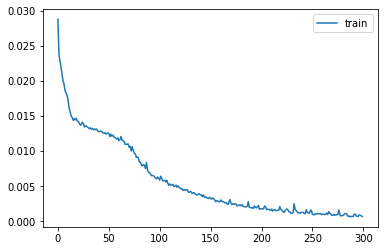

In [69]:
plt.plot(history_full_lstm_10_15.history['loss'], label='train')
plt.legend()
#plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/lstm/loss.png")
plt.show()

In [187]:
score = history_full_lstm_10_15.evaluate(X_test_scaled_10_15, y_test_scaled_10_15, batch_size=1)

AttributeError: 'History' object has no attribute 'evaluate'

In [70]:
pred_lstm_full_16 = LSTM_full_10_15.predict(X_test_scaled_10_15) 
pred_train_lstm_full_16 = LSTM_full_10_15.predict(X_train_scaled_10_15)

55/55 [==============================] - 0s 6ms/step


In [53]:
pred_train_lstm_full_16.shape
pred_lstm_full_16.shape

(440, 1)

In [71]:
rmse_lstm_full_16 = np.sqrt(mean_squared_error(y_test_scaled_10_15, pred_lstm_full_16)) 
print("RMSE: %f" % (rmse_lstm_full_16)) 

RMSE: 0.093962


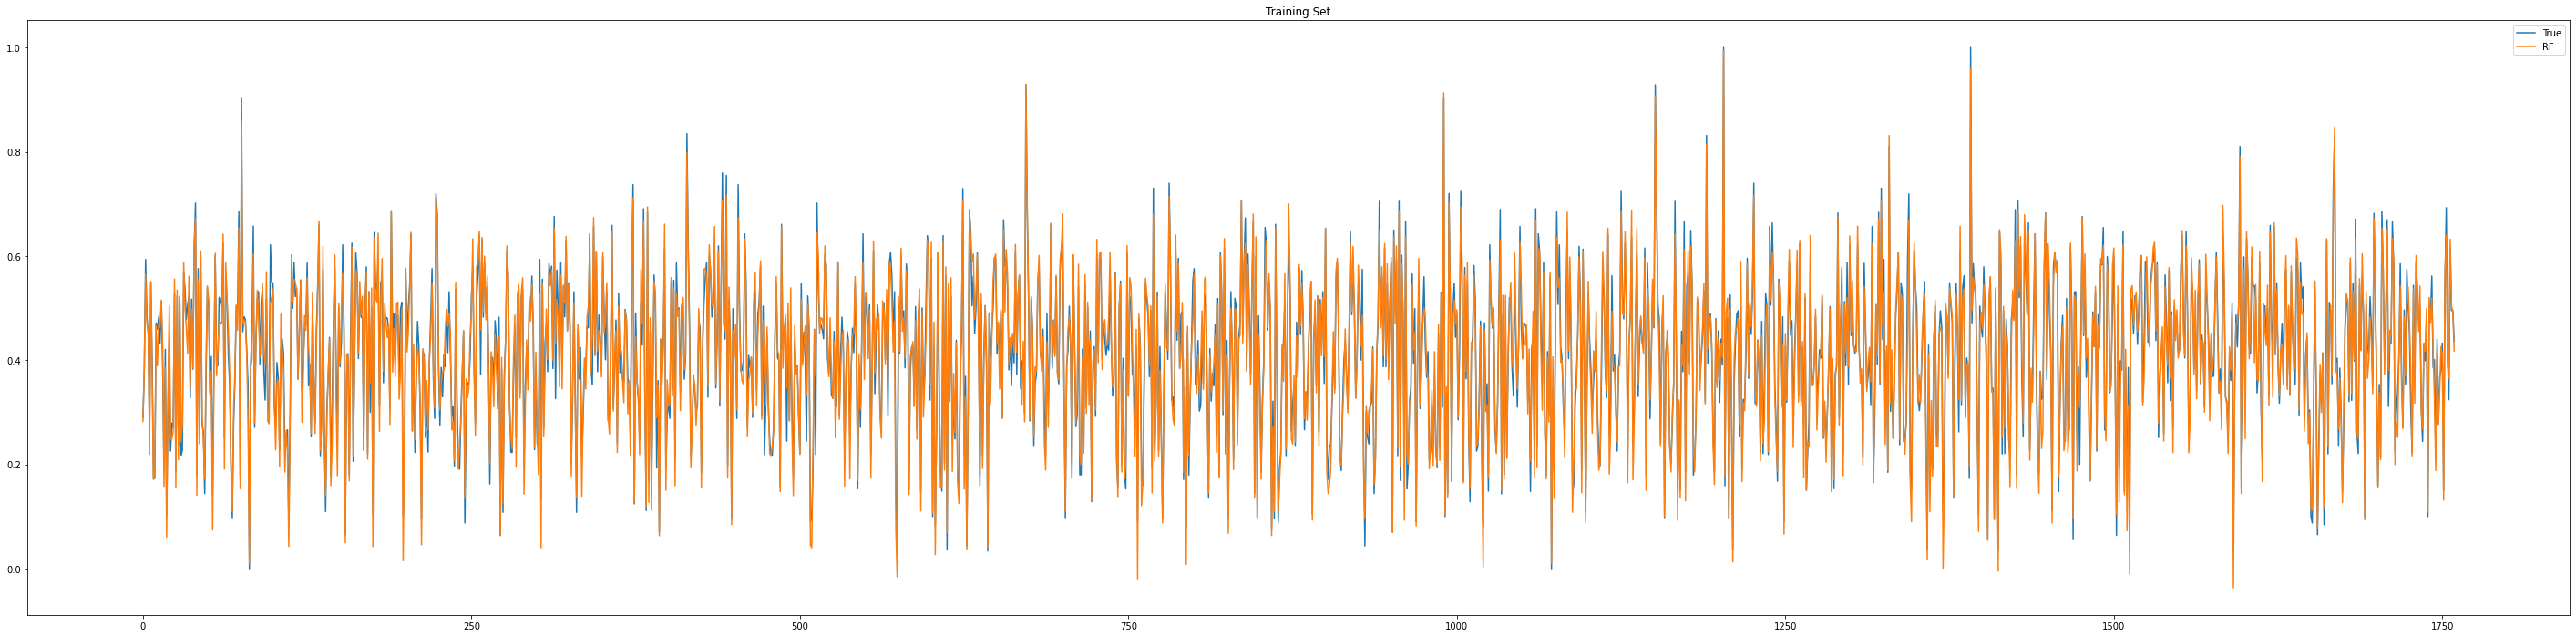

Training Set R-Square= 0.9543958975332626


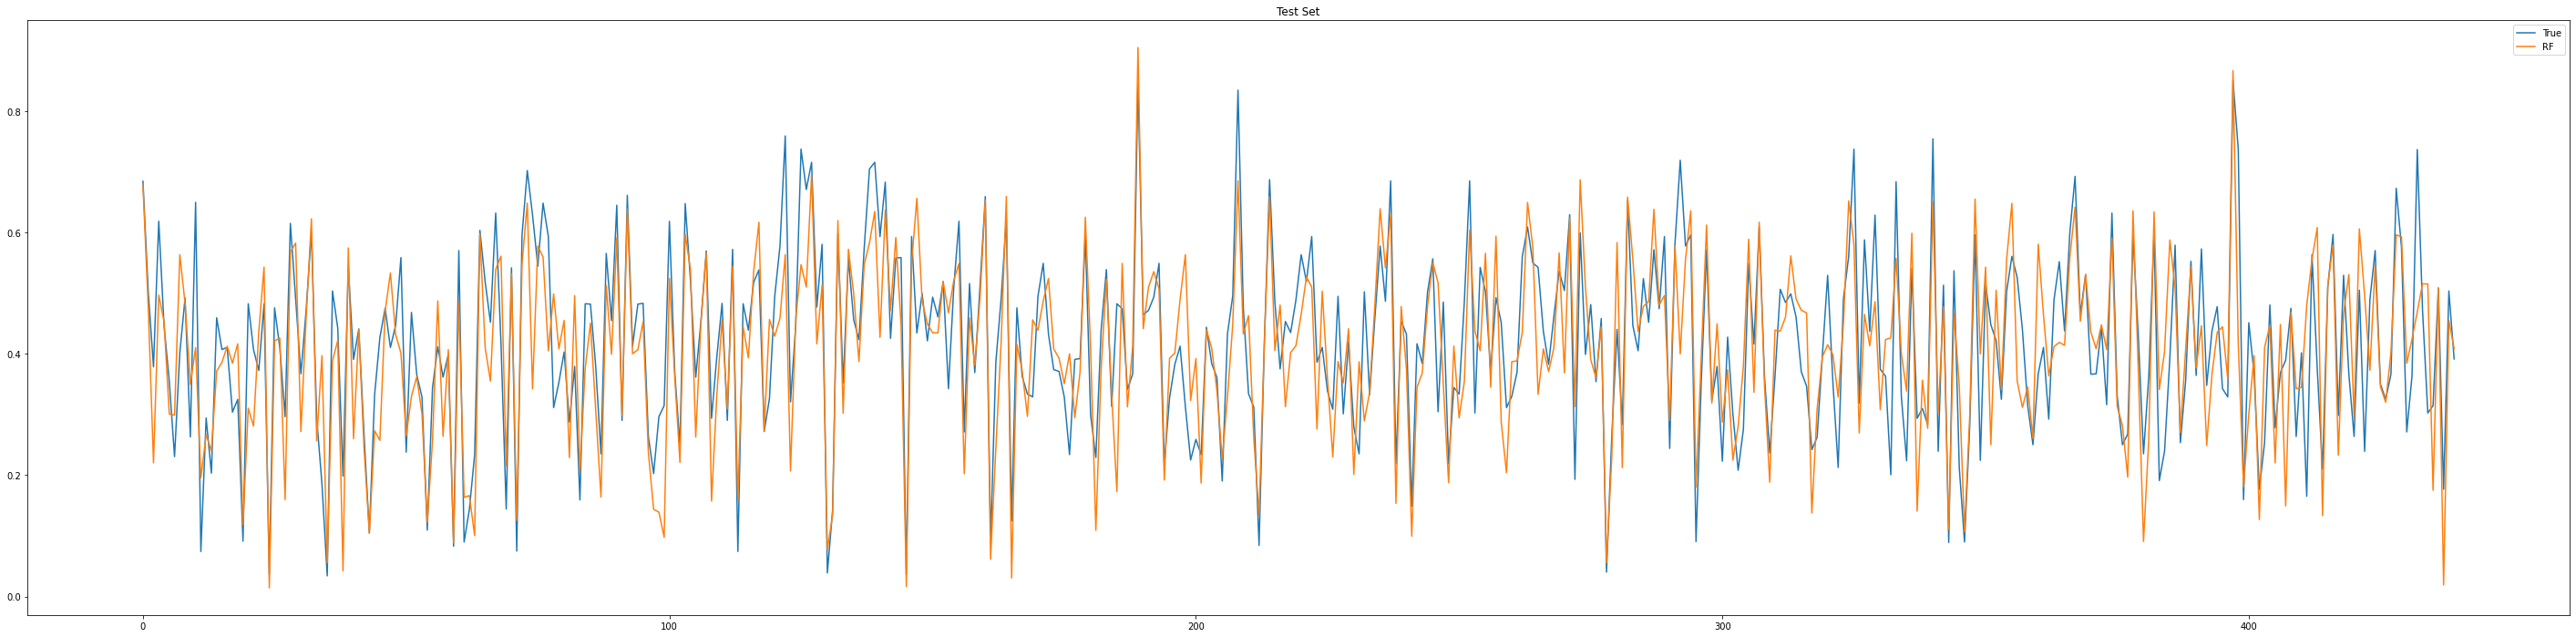

Test Set R-Square= 0.629119587337077


In [72]:
plt.figure(figsize=(50,12))
plt.plot(np.array(y_train_scaled_10_15))
# plt.plot(pred_train_mlp)
plt.plot(pred_train_lstm_full_16)

plt.title("Predictions on train data")
plt.legend(["True","RF"])
plt.title('Training Set')
#plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/lstm/train.png")

plt.show()

# Compute R-Square value for training set
rf_indices_r2_train = r2_score(y_train_scaled_10_15 ,pred_train_lstm_full_16)
print("Training Set R-Square=", rf_indices_r2_train)


plt.figure(figsize=(50,12))
plt.plot(np.array(y_test_scaled_10_15))
# plt.plot(pred_train_mlp)
plt.plot(pred_lstm_full_16)

plt.title("Predictions on test data")
plt.legend(["True","RF"])
plt.title('Test Set')
#plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/lstm/test.png")

plt.show()

# Compute R-Square value for test set
rf_indices_r2_test = r2_score(y_test_scaled_10_15,pred_lstm_full_16)
print("Test Set R-Square=", rf_indices_r2_test)

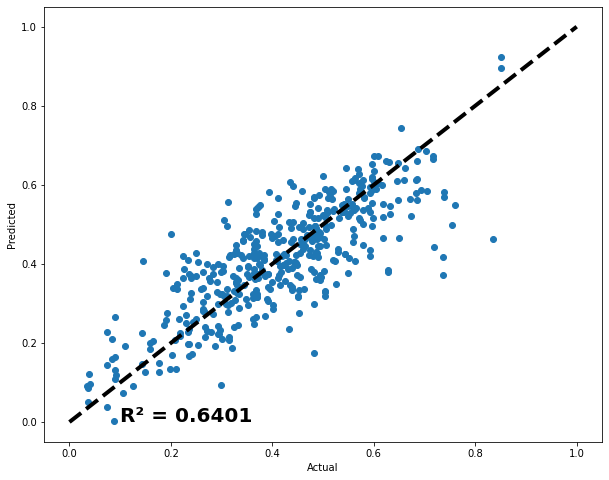

In [195]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test_scaled_10_15, pred_lstm_full_16)
ax.plot([test_scaled_10_15.min(), test_scaled_10_15.max()], [test_scaled_10_15.min(), test_scaled_10_15.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

ax.annotate("R² = {:.4f}".format(r2_score(y_test_scaled_10_15, pred_lstm_full_16)),  (0.1, 0),fontsize=20, fontweight='bold')
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/lstm/r2.png")

plt.show()

## Optuna LSTM

In [15]:

best_score_lstm_2 = float('-inf')  # Initialize the best score
lstm2_model_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/lstm/best_model.h5'

def lstm_optuna_case2(trial):
    clear_session()

    input_shape = (X_train_scaled_10_15.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_categorical('units', [16, 32, 64, 128]),
                   activation='tanh', input_shape=input_shape))
    model.add(Dense(1))

    learning_r = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    model.compile(loss='mse', optimizer=Adam(lr=learning_r), metrics=['mean_squared_error'])

    # Save the best model weights
    model_checkpoint = ModelCheckpoint(lstm2_model_path, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train_scaled_10_15, y_train_scaled_10_15, epochs=trial.suggest_int('epochs', 250, 450, 10),
              batch_size=8, validation_data=(X_test_scaled_10_15, y_test_scaled_10_15), callbacks=[model_checkpoint], verbose=0)

    model.load_weights(lstm2_model_path)  # Load the best weights saved during training

    y_pred = model.predict(X_test_scaled_10_15)
    score = r2_score(y_test_scaled_10_15, y_pred)

    global best_score_lstm_2
    if score > best_score_lstm_2:  # Update the best score and save the model weights
        best_score_lstm_2 = score
        model.save('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/lstm/best_model_weights.h5')

    return score

study_lstm_2 = optuna.create_study(direction="maximize")
study_lstm_2.optimize(lstm_optuna_case2, n_trials=50)

print("Number of finished trials: {}".format(len(study_lstm_2.trials)))

print("Best trial:")
trial_lstm_2 = study_lstm_2.best_trial

print("  Value: {}".format(trial_lstm_2.value))

print("  Params: ")
for key, value in trial_lstm_2.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-10 11:37:58,214] A new study created in memory with name: no-name-fd5284a8-1d7a-48b5-b461-565a4663fb7f


14/14 [==============================] - 0s 4ms/step


[I 2023-11-10 11:45:00,570] Trial 0 finished with value: 0.6262835837103864 and parameters: {'units': 64, 'lr': 0.0006713274226231895, 'epochs': 410}. Best is trial 0 with value: 0.6262835837103864.


14/14 [==============================] - 1s 13ms/step


[I 2023-11-10 12:01:15,806] Trial 1 finished with value: 0.639385938627123 and parameters: {'units': 128, 'lr': 0.00046412870331366107, 'epochs': 390}. Best is trial 1 with value: 0.639385938627123.


14/14 [==============================] - 1s 2ms/step


[I 2023-11-10 12:05:56,456] Trial 2 finished with value: 0.48275170794269084 and parameters: {'units': 16, 'lr': 0.0002951004381084991, 'epochs': 400}. Best is trial 1 with value: 0.639385938627123.


14/14 [==============================] - 1s 13ms/step


[I 2023-11-10 12:23:10,641] Trial 3 finished with value: 0.6430929202733603 and parameters: {'units': 128, 'lr': 0.00032396134618108596, 'epochs': 440}. Best is trial 3 with value: 0.6430929202733603.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-10 12:27:37,460] Trial 4 finished with value: 0.6885514012956591 and parameters: {'units': 16, 'lr': 0.0009403561916564942, 'epochs': 380}. Best is trial 4 with value: 0.6885514012956591.


14/14 [==============================] - 0s 9ms/step


[I 2023-11-10 12:40:03,901] Trial 5 finished with value: 0.5928778803489373 and parameters: {'units': 128, 'lr': 0.00015587385042606939, 'epochs': 340}. Best is trial 4 with value: 0.6885514012956591.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-10 12:43:26,880] Trial 6 finished with value: 0.5291741602702088 and parameters: {'units': 16, 'lr': 0.00045751999229604967, 'epochs': 300}. Best is trial 4 with value: 0.6885514012956591.


14/14 [==============================] - 0s 4ms/step


[I 2023-11-10 12:50:04,273] Trial 7 finished with value: 0.5603921819981854 and parameters: {'units': 64, 'lr': 0.00027123185867588927, 'epochs': 390}. Best is trial 4 with value: 0.6885514012956591.


14/14 [==============================] - 0s 4ms/step


[I 2023-11-10 12:55:12,755] Trial 8 finished with value: 0.5935566994820936 and parameters: {'units': 64, 'lr': 0.0003684243763312632, 'epochs': 300}. Best is trial 4 with value: 0.6885514012956591.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-10 12:59:30,588] Trial 9 finished with value: 0.4941254946901079 and parameters: {'units': 16, 'lr': 0.0005402962188056448, 'epochs': 380}. Best is trial 4 with value: 0.6885514012956591.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-10 13:02:41,491] Trial 10 finished with value: 0.5658454802985959 and parameters: {'units': 32, 'lr': 0.0007692359554388292, 'epochs': 250}. Best is trial 4 with value: 0.6885514012956591.


14/14 [==============================] - 1s 11ms/step


[I 2023-11-10 13:20:12,967] Trial 11 finished with value: 0.7375890697755995 and parameters: {'units': 128, 'lr': 0.0008239344346341214, 'epochs': 450}. Best is trial 11 with value: 0.7375890697755995.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-10 13:25:56,499] Trial 12 finished with value: 0.6335564606445516 and parameters: {'units': 32, 'lr': 0.0009925316527801306, 'epochs': 450}. Best is trial 11 with value: 0.7375890697755995.


14/14 [==============================] - 0s 10ms/step


[I 2023-11-10 13:38:36,422] Trial 13 finished with value: 0.6942076724481956 and parameters: {'units': 128, 'lr': 0.000950329683315516, 'epochs': 340}. Best is trial 11 with value: 0.7375890697755995.


14/14 [==============================] - 2s 11ms/step


[I 2023-11-10 13:52:09,594] Trial 14 finished with value: 0.7337027720415341 and parameters: {'units': 128, 'lr': 0.0007054314217266078, 'epochs': 340}. Best is trial 11 with value: 0.7375890697755995.


14/14 [==============================] - 0s 10ms/step


[I 2023-11-10 14:04:09,993] Trial 15 finished with value: 0.7269051256843959 and parameters: {'units': 128, 'lr': 0.000651873089119847, 'epochs': 320}. Best is trial 11 with value: 0.7375890697755995.


14/14 [==============================] - 0s 10ms/step


[I 2023-11-10 14:14:09,348] Trial 16 finished with value: 0.7153422266210945 and parameters: {'units': 128, 'lr': 0.0006996757883916577, 'epochs': 260}. Best is trial 11 with value: 0.7375890697755995.


14/14 [==============================] - 0s 13ms/step


[I 2023-11-10 14:30:46,272] Trial 17 finished with value: 0.7112638166439682 and parameters: {'units': 128, 'lr': 0.0005705541438504023, 'epochs': 420}. Best is trial 11 with value: 0.7375890697755995.


14/14 [==============================] - 0s 9ms/step


[I 2023-11-10 14:43:49,821] Trial 18 finished with value: 0.7389844052051182 and parameters: {'units': 128, 'lr': 0.0007709580830645202, 'epochs': 360}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-10 14:48:14,538] Trial 19 finished with value: 0.5951533284456438 and parameters: {'units': 32, 'lr': 0.0008112886418100299, 'epochs': 360}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 11ms/step


[I 2023-11-10 15:04:11,879] Trial 20 finished with value: 0.6745397104653008 and parameters: {'units': 128, 'lr': 0.0005355402146589914, 'epochs': 430}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 9ms/step


[I 2023-11-10 15:17:15,079] Trial 21 finished with value: 0.7350410692942559 and parameters: {'units': 128, 'lr': 0.0007884688148787419, 'epochs': 360}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 13ms/step


[I 2023-11-10 15:30:22,192] Trial 22 finished with value: 0.7144195195567158 and parameters: {'units': 128, 'lr': 0.000825541482761687, 'epochs': 360}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 11ms/step


[I 2023-11-10 15:40:55,246] Trial 23 finished with value: 0.7028889940726232 and parameters: {'units': 128, 'lr': 0.0009625594207535258, 'epochs': 280}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 13ms/step


[I 2023-11-10 15:54:35,751] Trial 24 finished with value: 0.6916079717528539 and parameters: {'units': 128, 'lr': 0.0007697079258221178, 'epochs': 360}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 10ms/step


[I 2023-11-10 16:06:46,873] Trial 25 finished with value: 0.7026101097511899 and parameters: {'units': 128, 'lr': 0.0006340819010401956, 'epochs': 320}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 7ms/step


[I 2023-11-10 16:18:53,184] Trial 26 finished with value: 0.6856095767582806 and parameters: {'units': 128, 'lr': 0.0007884225337651558, 'epochs': 320}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 4ms/step


[I 2023-11-10 16:24:49,149] Trial 27 finished with value: 0.6371930452351511 and parameters: {'units': 64, 'lr': 0.0005755582726560831, 'epochs': 370}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-10 16:30:19,151] Trial 28 finished with value: 0.6087489752758412 and parameters: {'units': 32, 'lr': 0.0004537160157914215, 'epochs': 450}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-10 16:36:53,274] Trial 29 finished with value: 0.5918813894261308 and parameters: {'units': 64, 'lr': 0.0006335676803552063, 'epochs': 410}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 12ms/step


[I 2023-11-10 16:52:38,190] Trial 30 finished with value: 0.721008458101701 and parameters: {'units': 128, 'lr': 0.0008469351023366302, 'epochs': 420}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 14ms/step


[I 2023-11-10 17:06:33,497] Trial 31 finished with value: 0.702874646470755 and parameters: {'units': 128, 'lr': 0.0006879882182413867, 'epochs': 340}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 2s 13ms/step


[I 2023-11-10 17:19:46,544] Trial 32 finished with value: 0.6906861033171126 and parameters: {'units': 128, 'lr': 0.0007064959837709704, 'epochs': 330}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 13ms/step


[I 2023-11-10 17:35:31,737] Trial 33 finished with value: 0.7241657996074462 and parameters: {'units': 128, 'lr': 0.0008675017650071452, 'epochs': 400}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 10ms/step


[I 2023-11-10 17:46:03,816] Trial 34 finished with value: 0.6864679723128909 and parameters: {'units': 128, 'lr': 0.0007367999506711457, 'epochs': 300}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 8ms/step


[I 2023-11-10 18:01:10,475] Trial 35 finished with value: 0.6892629325184669 and parameters: {'units': 128, 'lr': 0.0009902937082596891, 'epochs': 380}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 3ms/step


[I 2023-11-10 18:06:39,195] Trial 36 finished with value: 0.5861454956190495 and parameters: {'units': 16, 'lr': 0.0008273953424474945, 'epochs': 350}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 20ms/step


[I 2023-11-10 18:23:43,147] Trial 37 finished with value: 0.6937765619314178 and parameters: {'units': 128, 'lr': 0.0004930889320836876, 'epochs': 280}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 13ms/step


[I 2023-11-10 18:46:12,421] Trial 38 finished with value: 0.7227074121656094 and parameters: {'units': 128, 'lr': 0.0006541130341309036, 'epochs': 400}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 4ms/step


[I 2023-11-10 18:53:15,319] Trial 39 finished with value: 0.575419521906136 and parameters: {'units': 16, 'lr': 0.0008948944001287341, 'epochs': 370}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 2s 5ms/step


[I 2023-11-10 19:03:37,763] Trial 40 finished with value: 0.6183638772373672 and parameters: {'units': 64, 'lr': 0.000438892367292447, 'epochs': 350}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 18ms/step


[I 2023-11-10 19:20:41,633] Trial 41 finished with value: 0.7006048238512674 and parameters: {'units': 128, 'lr': 0.0006107430680489259, 'epochs': 320}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 3s 11ms/step


[I 2023-11-10 19:37:10,776] Trial 42 finished with value: 0.7059527773049781 and parameters: {'units': 128, 'lr': 0.0007073056896976247, 'epochs': 310}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 12ms/step


[I 2023-11-10 19:54:01,011] Trial 43 finished with value: 0.7104857468092365 and parameters: {'units': 128, 'lr': 0.0006285391990900911, 'epochs': 330}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 2s 15ms/step


[I 2023-11-10 20:08:26,212] Trial 44 finished with value: 0.6644978642399808 and parameters: {'units': 128, 'lr': 0.0008886795684193381, 'epochs': 280}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 12ms/step


[I 2023-11-10 20:27:33,327] Trial 45 finished with value: 0.6957615457266497 and parameters: {'units': 128, 'lr': 0.0007481238996252414, 'epochs': 390}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-10 20:33:52,219] Trial 46 finished with value: 0.6004940937691359 and parameters: {'units': 32, 'lr': 0.0005160248968849964, 'epochs': 330}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-10 20:39:13,309] Trial 47 finished with value: 0.5427743416189212 and parameters: {'units': 16, 'lr': 0.0005952793737268329, 'epochs': 290}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 19ms/step


[I 2023-11-10 20:58:46,565] Trial 48 finished with value: 0.7085546965026903 and parameters: {'units': 128, 'lr': 0.000678279645442191, 'epochs': 340}. Best is trial 18 with value: 0.7389844052051182.


14/14 [==============================] - 1s 20ms/step


[I 2023-11-10 21:16:42,846] Trial 49 finished with value: 0.682807721326476 and parameters: {'units': 128, 'lr': 0.0007688283445318273, 'epochs': 310}. Best is trial 18 with value: 0.7389844052051182.


Number of finished trials: 50
Best trial:
  Value: 0.7389844052051182
  Params: 
    units: 128
    lr: 0.0007709580830645202
    epochs: 360


In [184]:
study_lstm_2 = optuna.create_study(direction="maximize")
study_lstm_2.optimize(lstm_optuna_case2, n_trials=50)

print("Number of finished trials: {}".format(len(study_lstm_2.trials)))

print("Best trial:")
trial_lstm_2 = study_lstm_2.best_trial

print("  Value: {}".format(trial_lstm_2.value))

print("  Params: ")
for key, value in trial_lstm_2.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-29 18:12:14,150] A new study created in memory with name: no-name-8e7d54df-4388-41cb-998e-542b03699fc2


[I 2023-10-29 18:34:06,129] Trial 0 finished with value: 0.6800127029418945 and parameters: {'units': 64, 'lr': 0.0008558432381922752, 'epochs': 250}. Best is trial 0 with value: 0.6800127029418945.
[I 2023-10-29 18:50:05,942] Trial 1 finished with value: 0.5773618817329407 and parameters: {'units': 16, 'lr': 0.0009513856508249928, 'epochs': 300}. Best is trial 0 with value: 0.6800127029418945.
[I 2023-10-29 19:04:05,092] Trial 2 finished with value: 0.6524996161460876 and parameters: {'units': 32, 'lr': 0.000493324648084258, 'epochs': 260}. Best is trial 0 with value: 0.6800127029418945.
[I 2023-10-29 19:47:17,726] Trial 3 finished with value: 0.7298488616943359 and parameters: {'units': 128, 'lr': 0.0009979805843283594, 'epochs': 350}. Best is trial 3 with value: 0.7298488616943359.
[I 2023-10-29 20:01:33,475] Trial 4 finished with value: 0.35463351011276245 and parameters: {'units': 16, 'lr': 0.0001397048907026962, 'epochs': 280}. Best is trial 3 with value: 0.7298488616943359.
[I 2

Number of finished trials: 50
Best trial:
  Value: 0.7298488616943359
  Params: 
    units: 128
    lr: 0.0009979805843283594
    epochs: 350


## MLP

In [32]:
clear_session()
MLP_full_16 = Sequential()
MLP_full_16.add(Dense(256, activation="relu",input_shape=(X_train_scaled_10_15.shape[1],1)))
#MLP_full.add(Dropout(0.2))
MLP_full_16.add(Dense(64, activation="relu"))
#MLP_full.add(Dropout(0.4))
MLP_full_16.add(Dense(8, activation="relu"))
MLP_full_16.add(Flatten())    
MLP_full_16.add(Dense(1))
MLP_full_16.compile(loss='mse', optimizer=Adam(lr=0.0005761073539838296), metrics=[RSquare()])#,decay=1e-3 / 200))

history_MLP_full_16 = MLP_full_16.fit(X_train_scaled_10_15, y_train_scaled_10_15, epochs=320, batch_size=4)


Epoch 1/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0213 - r_square: 0.0688
Epoch 2/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0138 - r_square: 0.3983
Epoch 3/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0126 - r_square: 0.4514
Epoch 4/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0112 - r_square: 0.5092
Epoch 5/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0105 - r_square: 0.5420
Epoch 6/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0099 - r_square: 0.5692
Epoch 7/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0094 - r_square: 0.5882
Epoch 8/320
440/440 [==============================] - 1s 3ms/step - loss: 0.0094 - r_square: 0.5906
Epoch 9/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0089 - r_square: 0.6096
Epoch 10/320
440/440 [==============================] - 1s 2ms/step - loss: 0.0088 - r_squa

In [33]:
pred_train_mlp_full_16 = MLP_full_16.predict(X_train_scaled_10_15)
pred_test_mlp_full_16 = MLP_full_16.predict(X_test_scaled_10_15)

14/14 [==============================] - 0s 3ms/step


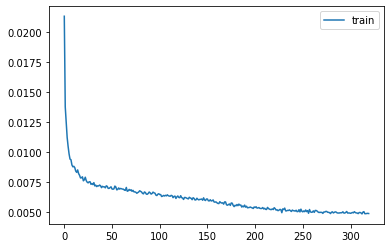

In [41]:
plt.plot(history_MLP_full_16.history['loss'], label='train')
plt.legend()
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/mlp/loss.png")
plt.show()

In [34]:
rmse_mlp_full_16 = np.sqrt(mean_squared_error(y_test_scaled_10_15, pred_test_mlp_full_16)) 
print("RMSE: %f" % (rmse_mlp_full_16)) 

RMSE: 0.089395


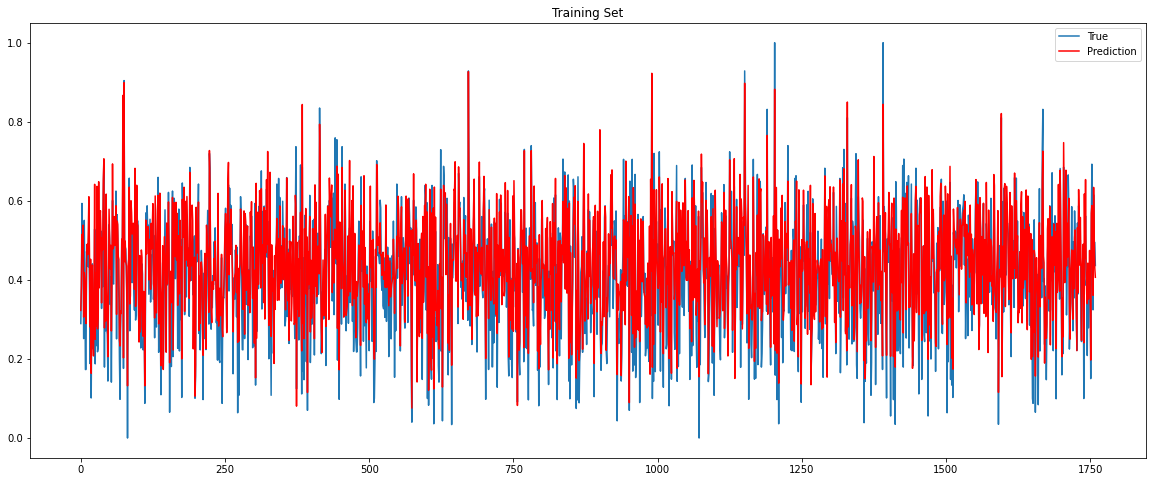

Training Set R-Square= 0.7578182427538446


In [35]:
plt.figure(figsize=(20,8))
plt.plot(np.array(y_train_scaled_10_15))
plt.plot(pred_train_mlp_full_16,'r')
plt.title("Average WFV predictions on train data")
plt.legend(["True", "Prediction"])
plt.title('Training Set')
plt.savefig("")
plt.show()

# Compute R-Square value for training set
mlp_indices_r2_train = r2_score(y_train_scaled_10_15,pred_train_mlp_full_16)
print("Training Set R-Square=", mlp_indices_r2_train)

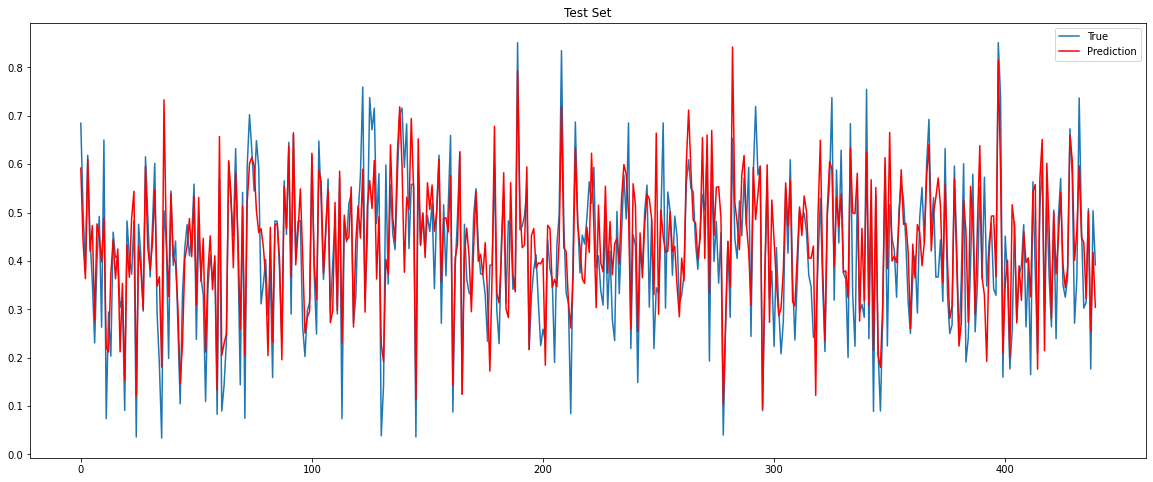

Test Set R-Square= 0.6642942262886022


In [36]:

plt.figure(figsize=(20,8))
plt.plot(np.array(y_test_scaled_10_15))
plt.plot(pred_test_mlp_full_16,'r')
plt.title("Average WFV predictions on test data")
plt.legend(["True", "Prediction"])
plt.title('Test Set')
plt.show()

# Compute R-Square value for training set
mlp_indices_r2_test = r2_score(y_test_scaled_10_15,pred_test_mlp_full_16)
print("Test Set R-Square=", mlp_indices_r2_test)


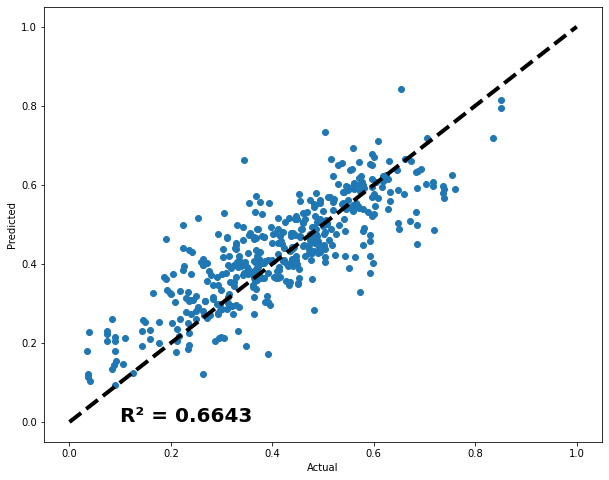

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test_scaled_10_15, pred_test_mlp_full_16)
ax.plot([test_scaled_10_15.min(), test_scaled_10_15.max()], [test_scaled_10_15.min(), test_scaled_10_15.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

ax.annotate("R² = {:.4f}".format(r2_score(y_test_scaled_10_15, pred_test_mlp_full_16)), (0.1, 0),fontsize=20, fontweight='bold')
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/mlp/r2.png")
plt.show()


## Optuna MLP

In [246]:

def mlp_optuna_2(trial):
    clear_session()

    input_shape=(X_train_scaled_10_15.shape[1],1)
    #optimizer = Adam(lr=0.001)

    model = Sequential()
    # 2. Suggest values of the hyperparameters using a trial object.
    model.add(
        Dense(units=trial.suggest_categorical('units_1', [64,128,256]), 
            activation='relu',
            input_shape=input_shape))
    model.add(
        Dense(units=trial.suggest_categorical('units_2', [8,16,32,64]), 
            activation='relu'))
    model.add(
        Dense(units=trial.suggest_categorical('units_3', [4,8]), 
            activation='relu'))
    model.add(Flatten())    
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    learning_r = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    model.compile(loss='mse', optimizer=Adam(lr=learning_r), metrics=[RSquare()])
    
    model.fit(X_train_scaled_10_15, y_train_scaled_10_15, epochs=trial.suggest_int('epochs',150,400,10), batch_size=4, verbose=False)
    score = model.evaluate(X_test_scaled_10_15, y_test_scaled_10_15, batch_size=1,verbose=0)
    return score[1]



In [19]:
best_score_mlp_2 = float('-inf')  # Initialize the best score
mlp2_model_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/mlp/best_model.h5'

def mlp_optuna_2(trial):
    clear_session()

    input_shape = (X_train_scaled_10_15.shape[1], 1)

    model = Sequential()
    model.add(
        Dense(units=trial.suggest_categorical('units_1', [64,128,256]), 
            activation='relu',
            input_shape=input_shape))
    model.add(
        Dense(units=trial.suggest_categorical('units_2', [8,16,32,64]), 
            activation='relu'))
    model.add(
        Dense(units=trial.suggest_categorical('units_3', [4,8]), 
            activation='relu'))
    model.add(Flatten())    
    model.add(Dense(1))

    learning_r = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    model.compile(loss='mse', optimizer=Adam(lr=learning_r), metrics=['mean_squared_error'])

    # Save the best model weights
    model_checkpoint = ModelCheckpoint(mlp2_model_path, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train_scaled_10_15, y_train_scaled_10_15, epochs=trial.suggest_int('epochs', 250, 450, 10),
              batch_size=8, validation_data=(X_test_scaled_10_15, y_test_scaled_10_15), callbacks=[model_checkpoint], verbose=0)

    model.load_weights(mlp2_model_path)  # Load the best weights saved during training

    y_pred = model.predict(X_test_scaled_10_15)
    score = r2_score(y_test_scaled_10_15, y_pred)

    global best_score_mlp_2
    if score > best_score_mlp_2:  # Update the best score and save the model weights
        best_score_mlp_2 = score
        model.save('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/mlp/best_model_weights.h5')
    return score
    


In [20]:
study_mlp_2 = optuna.create_study(direction="maximize")
study_mlp_2.optimize(mlp_optuna_2, n_trials=100)

print("Number of finished trials: {}".format(len(study_mlp_2.trials)))

print("Best trial:")
trial_mlp_2 = study_mlp_2.best_trial

print("  Value: {}".format(trial_mlp_2.value))

print("  Params: ")
for key, value in trial_mlp_2.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-11 03:18:38,870] A new study created in memory with name: no-name-2e2905c4-fcb0-438a-ac5e-a9ab7445054a


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:20:13,146] Trial 0 finished with value: 0.6630629056306616 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.0008392552068067759, 'epochs': 280}. Best is trial 0 with value: 0.6630629056306616.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:21:22,841] Trial 1 finished with value: 0.6788639182206222 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0005877837052016468, 'epochs': 290}. Best is trial 1 with value: 0.6788639182206222.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:23:08,806] Trial 2 finished with value: 0.6813819999078807 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00029800399932387606, 'epochs': 430}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 03:24:19,217] Trial 3 finished with value: 0.6523913202409352 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 4, 'lr': 0.0007181164587886849, 'epochs': 360}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 03:25:30,347] Trial 4 finished with value: 0.6755115204890207 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0006138063920988003, 'epochs': 280}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:26:33,988] Trial 5 finished with value: 0.6650968125119816 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 4, 'lr': 0.0004576202504893246, 'epochs': 350}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 03:27:35,422] Trial 6 finished with value: 0.6709620052245182 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 4, 'lr': 0.00063697323714655, 'epochs': 280}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 03:28:58,385] Trial 7 finished with value: 0.615011672347392 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 4, 'lr': 0.0005404602043157692, 'epochs': 290}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:30:08,210] Trial 8 finished with value: 0.6716631838736302 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.0004720417538171121, 'epochs': 350}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:31:36,612] Trial 9 finished with value: 0.6587028602373446 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.00012888494957051186, 'epochs': 390}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:34:02,633] Trial 10 finished with value: 0.6719074413839823 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0002519800609252719, 'epochs': 450}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:35:51,912] Trial 11 finished with value: 0.6684477488515963 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0003031540765909968, 'epochs': 440}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:36:44,933] Trial 12 finished with value: 0.674810026043438 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0009759678752730844, 'epochs': 250}. Best is trial 2 with value: 0.6813819999078807.


14/14 [==============================] - 0s 4ms/step


[I 2023-11-11 03:39:26,811] Trial 13 finished with value: 0.6841555786466362 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003727303198810841, 'epochs': 410}. Best is trial 13 with value: 0.6841555786466362.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:41:57,186] Trial 14 finished with value: 0.6786149277462141 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00023517890601333774, 'epochs': 420}. Best is trial 13 with value: 0.6841555786466362.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:44:20,980] Trial 15 finished with value: 0.6935591137398165 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00036856715227682704, 'epochs': 400}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:46:48,309] Trial 16 finished with value: 0.6770065049996492 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0004074139418351944, 'epochs': 400}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:49:12,196] Trial 17 finished with value: 0.6826279950334475 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003699188722400615, 'epochs': 380}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:51:45,182] Trial 18 finished with value: 0.6341061019779289 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 4, 'lr': 0.0001894279467495332, 'epochs': 410}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:53:11,049] Trial 19 finished with value: 0.687780327504768 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00034135876176250496, 'epochs': 320}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:54:31,495] Trial 20 finished with value: 0.6834363148550568 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003482839830683678, 'epochs': 310}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 03:55:58,473] Trial 21 finished with value: 0.6722513438745912 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0004709421561318672, 'epochs': 330}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 4ms/step


[I 2023-11-11 03:57:34,578] Trial 22 finished with value: 0.6704002644447681 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00034610366979142155, 'epochs': 370}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 03:59:00,789] Trial 23 finished with value: 0.6828800501867343 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0004101743907482878, 'epochs': 330}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 04:01:02,935] Trial 24 finished with value: 0.657178222040633 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0002769502095894562, 'epochs': 330}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 04:03:24,408] Trial 25 finished with value: 0.6766531186811114 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.000214599939789916, 'epochs': 400}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 04:04:57,267] Trial 26 finished with value: 0.6714948442387383 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 4, 'lr': 0.00033040280043158455, 'epochs': 380}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 04:06:40,678] Trial 27 finished with value: 0.6742930833968752 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.00039790660451874676, 'epochs': 420}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 04:08:38,273] Trial 28 finished with value: 0.6678074413114876 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00029061011070306885, 'epochs': 310}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 04:54:53,273] Trial 29 finished with value: 0.6839552577884913 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0005157583901771821, 'epochs': 450}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 04:55:46,125] Trial 30 finished with value: 0.6768602412103383 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0007541225999179427, 'epochs': 260}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 04:57:51,168] Trial 31 finished with value: 0.6784511179843834 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0005213998760522917, 'epochs': 440}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 04:59:55,974] Trial 32 finished with value: 0.6781582676907548 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00042303838582885886, 'epochs': 450}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:02:07,415] Trial 33 finished with value: 0.6848698263679507 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003590063193051829, 'epochs': 430}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:04:29,578] Trial 34 finished with value: 0.6685458423484202 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003404677518932983, 'epochs': 420}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:06:09,208] Trial 35 finished with value: 0.6864312134428306 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.00037816456328107684, 'epochs': 400}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:07:18,863] Trial 36 finished with value: 0.6666260384504472 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 8, 'lr': 0.0003042193993269311, 'epochs': 360}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:08:20,480] Trial 37 finished with value: 0.663090123166129 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 4, 'lr': 0.0004538717542845264, 'epochs': 430}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:09:42,570] Trial 38 finished with value: 0.6741823239314177 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.0005994895940434787, 'epochs': 390}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:11:09,189] Trial 39 finished with value: 0.6482216986671329 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 4, 'lr': 0.00027007403689376536, 'epochs': 430}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:11:54,874] Trial 40 finished with value: 0.6590216155510259 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.0003225289434708352, 'epochs': 310}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:13:58,775] Trial 41 finished with value: 0.6912726848527789 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003738867547926213, 'epochs': 410}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:15:30,927] Trial 42 finished with value: 0.676690974682451 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.00036830690565462225, 'epochs': 400}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:16:54,165] Trial 43 finished with value: 0.6906357405784177 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00044078479762304053, 'epochs': 410}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:18:02,699] Trial 44 finished with value: 0.6858799988289548 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0004387021546504031, 'epochs': 380}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:19:03,030] Trial 45 finished with value: 0.6731379306401517 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0005091381975641169, 'epochs': 360}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:19:49,456] Trial 46 finished with value: 0.6697251835415926 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0005655075402735427, 'epochs': 340}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:20:49,213] Trial 47 finished with value: 0.5289654968584343 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 4, 'lr': 0.000486796971638516, 'epochs': 410}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:21:55,424] Trial 48 finished with value: 0.6757111242767933 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0006433844110586487, 'epochs': 390}. Best is trial 15 with value: 0.6935591137398165.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:22:55,498] Trial 49 finished with value: 0.6940294211361668 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0003873729034886212, 'epochs': 300}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:23:41,478] Trial 50 finished with value: 0.6562238034279884 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.00043049801288204176, 'epochs': 290}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:24:32,192] Trial 51 finished with value: 0.6471608242687099 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00038859744318683035, 'epochs': 290}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:25:28,880] Trial 52 finished with value: 0.6636085830120502 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0003886774015863324, 'epochs': 320}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 05:26:17,483] Trial 53 finished with value: 0.641810656857833 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00032100163234078353, 'epochs': 270}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:27:43,985] Trial 54 finished with value: 0.6834263830013696 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.0004314296348346594, 'epochs': 410}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 832us/step


[I 2023-11-11 05:28:32,567] Trial 55 finished with value: 0.6609770576114469 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0004622127910821836, 'epochs': 370}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:29:43,835] Trial 56 finished with value: 0.6724560022660409 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00036792254859590315, 'epochs': 400}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:30:51,016] Trial 57 finished with value: 0.6591681240987826 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.00030758482315602063, 'epochs': 300}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 807us/step


[I 2023-11-11 05:31:26,858] Trial 58 finished with value: 0.6324322502954777 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 4, 'lr': 0.00048343728949849476, 'epochs': 300}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:32:42,387] Trial 59 finished with value: 0.6651942511725938 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0003933122050805003, 'epochs': 350}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:34:56,858] Trial 60 finished with value: 0.6863476011635672 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003529844821378255, 'epochs': 420}. Best is trial 49 with value: 0.6940294211361668.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:37:08,640] Trial 61 finished with value: 0.6945349784272732 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00032654083136778755, 'epochs': 420}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:39:24,438] Trial 62 finished with value: 0.6638504501787871 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00032898273211404757, 'epochs': 440}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:41:20,343] Trial 63 finished with value: 0.6794867183243993 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0002885030534623459, 'epochs': 410}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:43:05,318] Trial 64 finished with value: 0.6702724784244449 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003871266300964645, 'epochs': 390}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:44:35,156] Trial 65 finished with value: 0.6769300703145855 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0004154995429113372, 'epochs': 320}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:45:54,938] Trial 66 finished with value: 0.6639799203471328 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.00034436442735544763, 'epochs': 400}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:47:56,448] Trial 67 finished with value: 0.6713270993572347 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.000260647898286441, 'epochs': 420}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:50:07,221] Trial 68 finished with value: -8.661556960554151e-07 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00030672288134682467, 'epochs': 440}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:50:58,923] Trial 69 finished with value: 0.6750337511024362 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 8, 'lr': 0.00040838679188986933, 'epochs': 280}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 05:53:00,936] Trial 70 finished with value: 0.6281381348573907 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 4, 'lr': 0.0002895235673863468, 'epochs': 430}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:55:03,899] Trial 71 finished with value: 0.6731633448390553 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00034772453488873323, 'epochs': 420}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:57:05,086] Trial 72 finished with value: 0.6727606136297193 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003637877407125088, 'epochs': 410}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 05:59:09,961] Trial 73 finished with value: 0.6827816351563671 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003351011227991816, 'epochs': 420}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 06:01:02,640] Trial 74 finished with value: 0.6751772499682567 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003759501169619416, 'epochs': 380}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 06:02:58,282] Trial 75 finished with value: 0.6760912805444983 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0004264861578789814, 'epochs': 400}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:04:17,082] Trial 76 finished with value: 0.6479637354620564 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.0004653987862685396, 'epochs': 410}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 06:05:24,680] Trial 77 finished with value: 0.6644416958398189 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.00032746874719127617, 'epochs': 420}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:06:33,827] Trial 78 finished with value: 0.6798405233500056 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00035945594535829957, 'epochs': 370}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 06:08:31,748] Trial 79 finished with value: 0.6654658482735555 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00027796363762675385, 'epochs': 390}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 3ms/step


[I 2023-11-11 06:10:39,737] Trial 80 finished with value: 0.6804671742244548 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0003098061330048484, 'epochs': 430}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:11:41,098] Trial 81 finished with value: 0.6714392550595905 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0004323826316656867, 'epochs': 380}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:12:45,981] Trial 82 finished with value: 0.6633745249492586 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0003977740551585973, 'epochs': 400}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:13:57,574] Trial 83 finished with value: 0.6611547321342449 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0003472452069216385, 'epochs': 390}. Best is trial 61 with value: 0.6945349784272732.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:15:16,687] Trial 84 finished with value: 0.7015099468987738 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0004477381545587217, 'epochs': 410}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 06:16:40,855] Trial 85 finished with value: 0.6904822281788705 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.000497730026502377, 'epochs': 430}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:17:38,928] Trial 86 finished with value: 0.6853189406594802 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 4, 'lr': 0.0005313025900109082, 'epochs': 440}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:18:50,299] Trial 87 finished with value: 0.685180186064428 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0004480976121964262, 'epochs': 410}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:19:45,364] Trial 88 finished with value: 0.6934330982239705 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0004958873577953143, 'epochs': 340}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:20:41,050] Trial 89 finished with value: 0.6747953829108018 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0004941114270272004, 'epochs': 340}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:21:33,132] Trial 90 finished with value: 0.6836532165324924 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0005593726968266616, 'epochs': 320}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 06:22:29,832] Trial 91 finished with value: 0.6613990774201027 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.00045413088950810494, 'epochs': 340}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 897us/step


[I 2023-11-11 06:23:19,147] Trial 92 finished with value: 0.6798350185431099 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0004971982034395389, 'epochs': 300}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 941us/step


[I 2023-11-11 06:24:34,971] Trial 93 finished with value: 0.6729523750810498 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00040444619773499416, 'epochs': 430}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:25:27,167] Trial 94 finished with value: 0.6627178234689814 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0003720170983566358, 'epochs': 330}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 2ms/step


[I 2023-11-11 06:26:05,900] Trial 95 finished with value: 0.6723585316426217 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 8, 'lr': 0.0004740293014426197, 'epochs': 310}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:27:16,810] Trial 96 finished with value: 0.6765804315704018 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.0005207706979059043, 'epochs': 350}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 842us/step


[I 2023-11-11 06:28:13,029] Trial 97 finished with value: 0.6849294310054618 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.0004135821903431551, 'epochs': 410}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:29:14,258] Trial 98 finished with value: 0.6507674460991615 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.00044173019424759743, 'epochs': 320}. Best is trial 84 with value: 0.7015099468987738.


14/14 [==============================] - 0s 1ms/step


[I 2023-11-11 06:30:11,421] Trial 99 finished with value: -1.2498714152542334e-07 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 4, 'lr': 0.0003762513083382267, 'epochs': 360}. Best is trial 84 with value: 0.7015099468987738.


Number of finished trials: 100
Best trial:
  Value: 0.7015099468987738
  Params: 
    units_1: 64
    units_2: 64
    units_3: 8
    lr: 0.0004477381545587217
    epochs: 410


## XGBOOST

In [30]:
param = {
    'max_depth': 4,
    'learning_rate': 0.22263268291255955,
    'n_estimators': 835,
    'min_child_weight': 3,
    'gamma': 0.013250717825604455,
    'subsample': 0.4671058000154715,
    'colsample_bytree': 0.09841076552545186,
    'reg_alpha': 0.8142648557298242,
    'reg_lambda': 0.16537014620751905,
    'random_state': 641,
}

xg_reg_full_16 = xgb.XGBRegressor(**param)
# xg_reg_full_16 =xgb.XGBRegressor(objective ='reg:squarederror') 
# xg_reg_full_16.fit(X_train_scaled_10_15,y_train_scaled_10_15) 
xg_reg_full_16.load_model("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/xgboost/best_model_weights.json")


In [31]:
pred_xgb_full_16 = xg_reg_full_16.predict(X_test_scaled_10_15)
pred_train_xgb_full_16 = xg_reg_full_16.predict(X_train_scaled_10_15)


In [32]:
rmse_xgb_full = np.sqrt(mean_squared_error(y_test_scaled_10_15, pred_xgb_full_16)) 

print("RMSE: %f" % (rmse_xgb_full)) 

RMSE: 0.073147


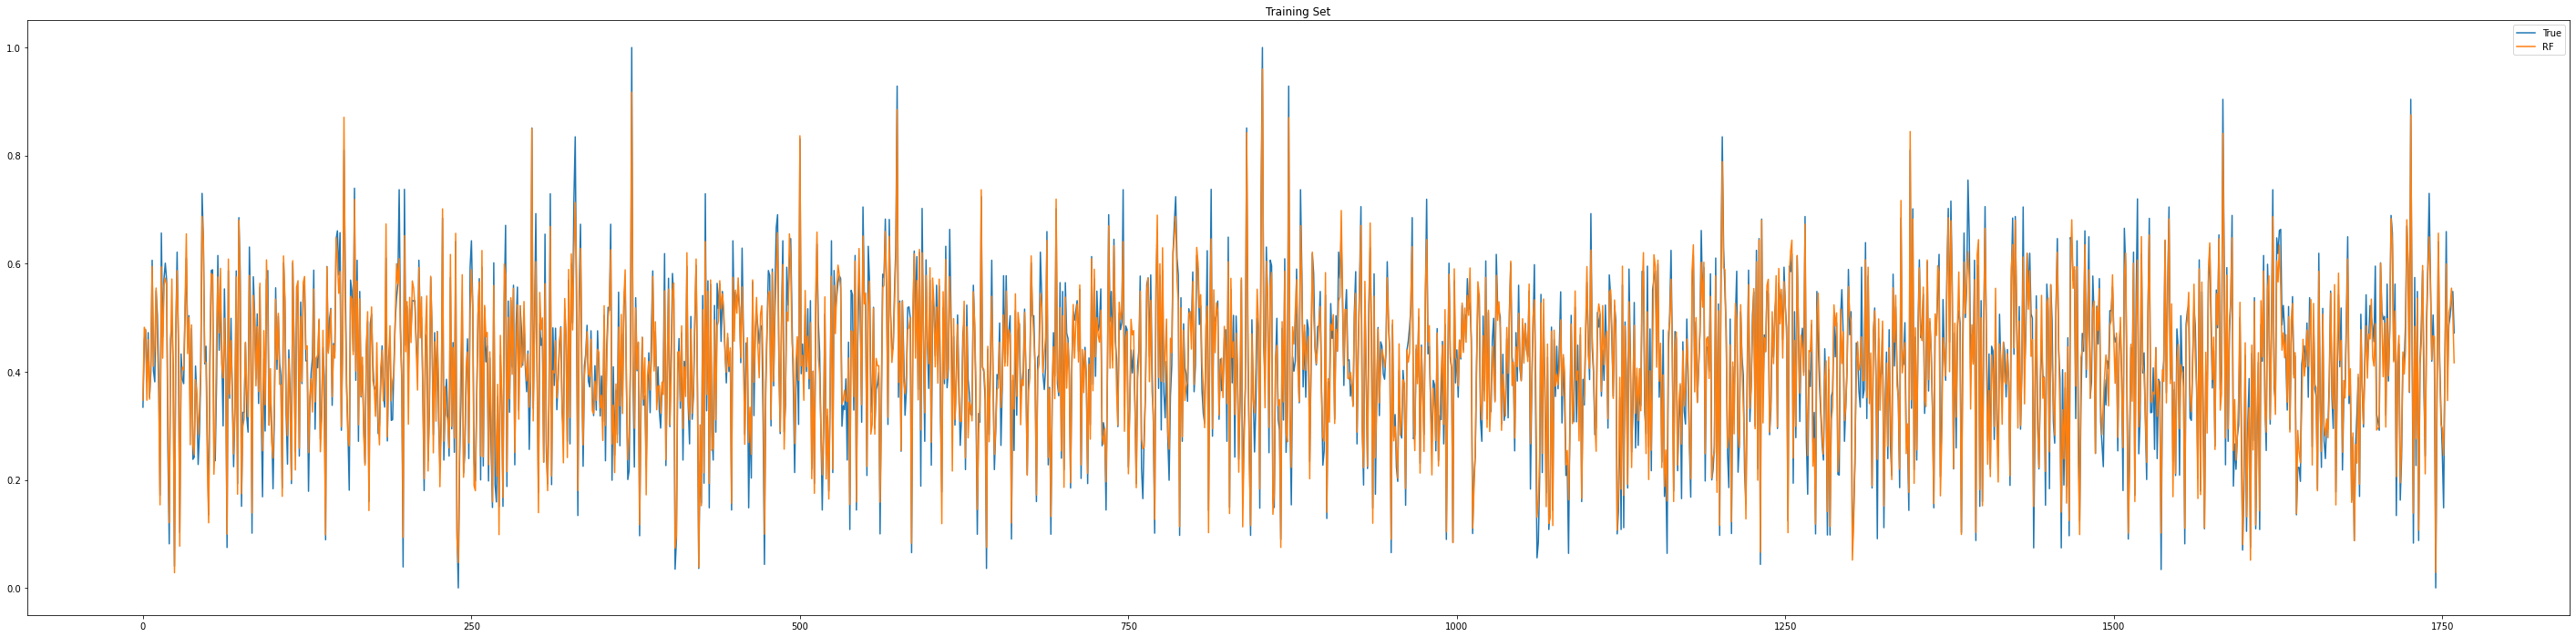

Training Set R-Square= 0.9348545445753992


In [33]:
plt.figure(figsize=(50,12))
plt.plot(np.array(y_train_scaled_10_15))
# plt.plot(pred_train_mlp)
plt.plot(pred_train_xgb_full_16)

plt.title("Predictions on train data")
plt.legend(["True","RF"])
plt.title('Training Set')
plt.show()

# Compute R-Square value for training set
rf_indices_r2_train_full = r2_score(y_train_scaled_10_15,pred_train_xgb_full_16)
print("Training Set R-Square=", rf_indices_r2_train_full)

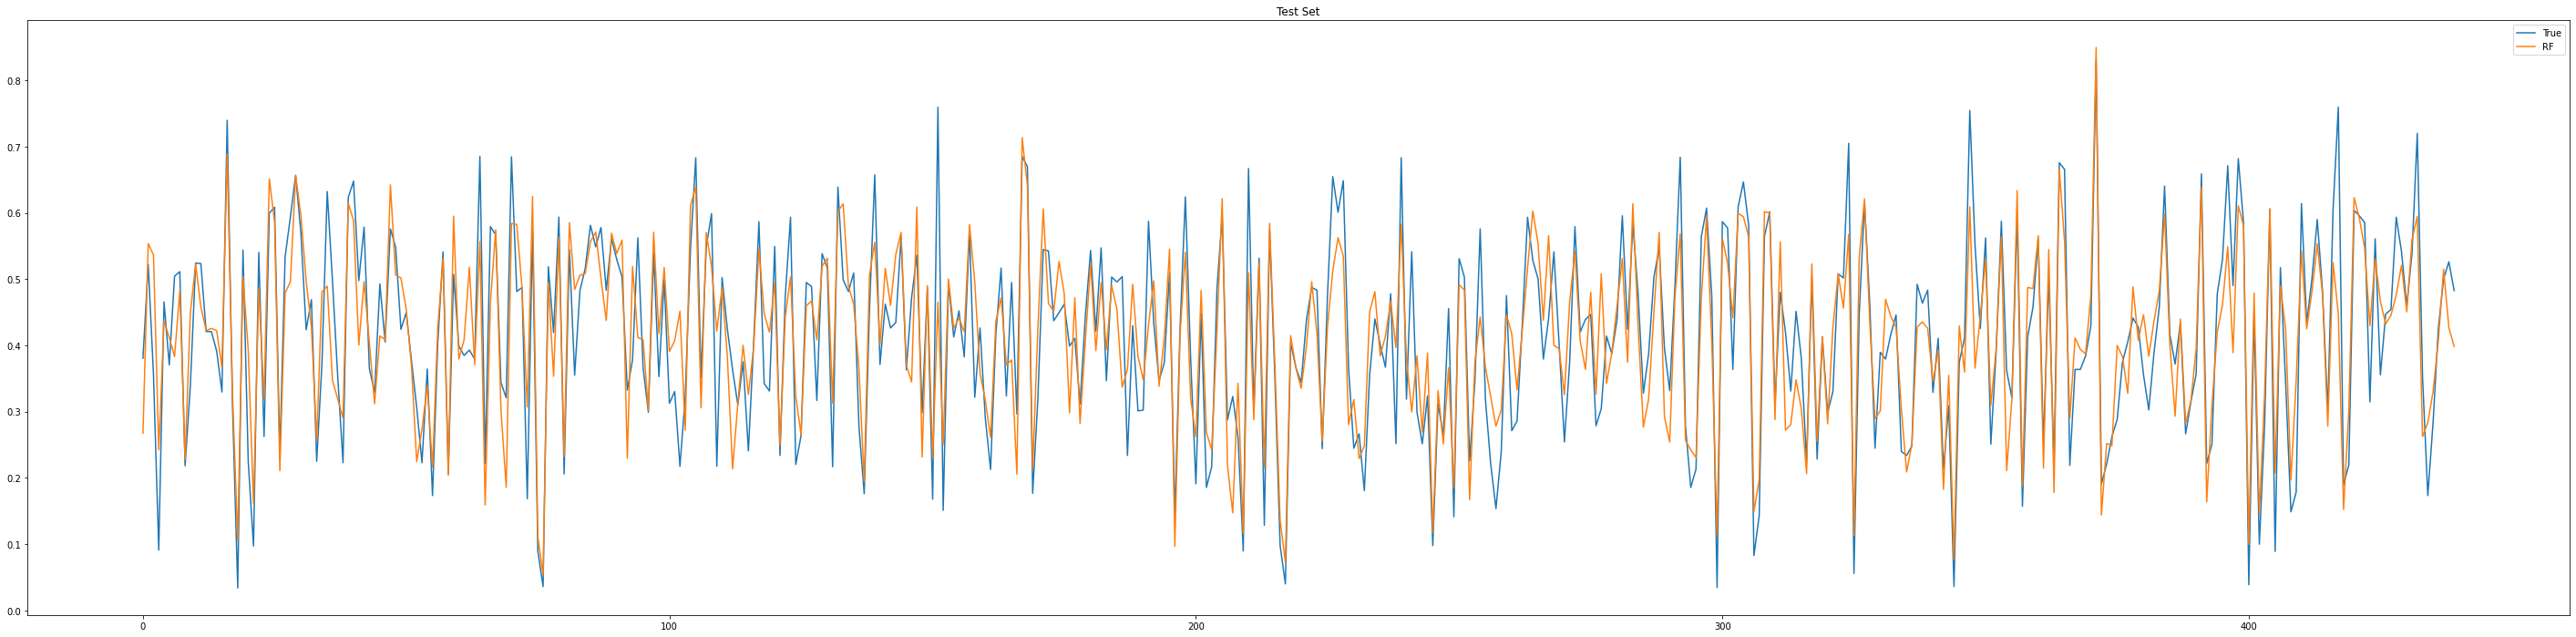

Test Set R-Square= 0.7705657242560676


In [34]:
plt.figure(figsize=(50,12))
plt.plot(np.array(y_test_scaled_10_15))
# plt.plot(pred_train_mlp)
plt.plot(pred_xgb_full_16)

plt.title("Predictions on test data")
plt.legend(["True","RF"])
plt.title('Test Set')
plt.show()

# Compute R-Square value for training set
rf_indices_r2_test_full = r2_score(y_test_scaled_10_15,pred_xgb_full_16)
print("Test Set R-Square=", rf_indices_r2_test_full)

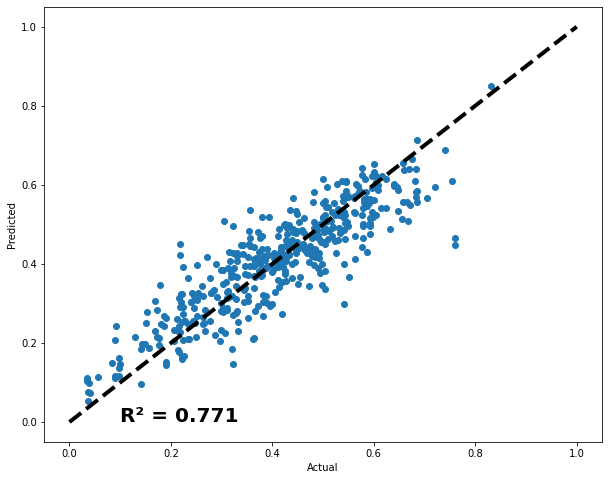

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test_scaled_10_15, pred_xgb_full_16)
ax.plot([test_scaled_10_15.min(), test_scaled_10_15.max()], [test_scaled_10_15.min(), test_scaled_10_15.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

ax.annotate("R² = {:.3f}".format(r2_score(y_test_scaled_10_15, pred_xgb_full_16)), (0.1, 0),fontsize=20, fontweight='bold')
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/xgboost/r2.png")

plt.show()


## Optuna XGBoost

In [17]:
best_score_xgb_2 = float('inf')  # Initialize the best score

def optuna_xgb_2(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_scaled_10_15, y_train_scaled_10_15)
    y_pred = model.predict(X_test_scaled_10_15)

    mse_2 = mean_squared_error(y_test_scaled_10_15, y_pred)
    global best_score_xgb_2
    if mse_2 < best_score_xgb_2:  # Update the best score and save the model weights
        best_score_xgb_2 = mse_2
        model.save_model('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case2/xgboost/best_model_weights.json')
    return mse_2

# Create the study
study_xgb_2 = optuna.create_study(direction='minimize', study_name='regression')
study_xgb_2.optimize(optuna_xgb_2, n_trials=100)
print("Number of finished trials: {}".format(len(study_xgb_2.trials)))

print("Best trial:")
trial_xgb_2 = study_xgb_2.best_trial

print("  Value: {}".format(trial_xgb_2.value))

print("  Params: ")
for key, value in trial_xgb_2.params.items():
    print("    {}: {}".format(key, value))


[I 2023-11-13 18:32:03,067] A new study created in memory with name: regression


[I 2023-11-13 18:32:03,444] Trial 0 finished with value: 0.023430433104759153 and parameters: {'max_depth': 5, 'learning_rate': 0.7542168882646487, 'n_estimators': 258, 'min_child_weight': 6, 'gamma': 0.8179952256345843, 'subsample': 0.012261804187503243, 'colsample_bytree': 0.4242667572418594, 'reg_alpha': 0.42326942394343664, 'reg_lambda': 0.9052550339762669, 'random_state': 707}. Best is trial 0 with value: 0.023430433104759153.
[I 2023-11-13 18:32:04,073] Trial 1 finished with value: 0.010507234641895093 and parameters: {'max_depth': 2, 'learning_rate': 0.518422629478048, 'n_estimators': 557, 'min_child_weight': 4, 'gamma': 0.4726469449272913, 'subsample': 0.5300462279032057, 'colsample_bytree': 0.05269449005625205, 'reg_alpha': 0.6103143723826173, 'reg_lambda': 0.6271806519612045, 'random_state': 915}. Best is trial 1 with value: 0.010507234641895093.
[I 2023-11-13 18:32:04,968] Trial 2 finished with value: 0.012178179522157061 and parameters: {'max_depth': 3, 'learning_rate': 0.4

Number of finished trials: 100
Best trial:
  Value: 0.0053504476703609164
  Params: 
    max_depth: 3
    learning_rate: 0.31325649717042997
    n_estimators: 757
    min_child_weight: 2
    gamma: 0.010312428841639115
    subsample: 0.6735099756683387
    colsample_bytree: 0.5420730527555989
    reg_alpha: 0.46184044849096867
    reg_lambda: 0.11693833306257394
    random_state: 483


In [239]:
print("Number of finished trials: {}".format(len(study_xgb_2.trials)))

print("Best trial:")
trial_xgb_2 = study_xgb_2.best_trial

print("  Value: {}".format(trial_xgb_2.value))

print("  Params: ")
for key, value in trial_xgb_2.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.004781210171168841
  Params: 
    max_depth: 4
    learning_rate: 0.22833039072845693
    n_estimators: 841
    min_child_weight: 4
    gamma: 0.010710658638214606
    subsample: 0.8600247768404645
    colsample_bytree: 0.20964800111526985
    reg_alpha: 0.015030524194439253
    reg_lambda: 0.6645763114539691
    random_state: 742


# Case 3 - 10 + 15 + 20 days 

In [9]:
c3 = Case(day=20,dynamic_drop=drop_dynamic_features,static_drop=drop_static_features)
c3_dfs, c3_scalers, c3_datas = c3.case_preprocessing(datasets,dataset_dict,target,concat=True, vector_df_old= c2_dfs[0][2])

In [18]:
X_train_scaled_10_15_20  = c3_datas[0][0]
X_test_scaled_10_15_20   = c3_datas[0][1]
y_train_scaled_10_15_20  = c3_datas[0][2]
y_test_scaled_10_15_20   = c3_datas[0][3]
test_scaled_10_15_20     = c3_datas[0][4]

## Train Test Split

## LSTM

In [89]:
LSTM_full_14 = Sequential()
LSTM_full_14.add(LSTM(128, activation='tanh', input_shape=(X_train_scaled_10_15_20.shape[1], 1)))
LSTM_full_14.add(Dense(1))

optimizer = Adam(lr=0.0009872146005978912)

LSTM_full_14.compile(optimizer=optimizer, loss='mse',metrics=[RSquare()])
LSTM_full_14.load_weights("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/lstm/best_model_weights.h5")

In [ ]:
clear_session()

LSTM_full_14 = Sequential()
LSTM_full_14.add(LSTM(128, activation='relu', input_shape=(X_train_scaled_10_15_20.shape[1], 1)))
LSTM_full_14.add(Dense(1))

optimizer = Adam(lr=0.0006988135685611857)

LSTM_full_14.compile(optimizer=optimizer, loss='mse',metrics=[RSquare()])

history_full_lstm_14 = LSTM_full_14.fit(X_train_scaled_10_15_20, y_train_scaled_10_15_20, epochs=290, batch_size=8)

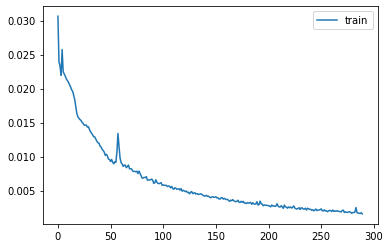

In [225]:
plt.plot(history_full_lstm_14.history['loss'], label='train')
plt.legend()
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/lstm/loss.png")
plt.show()

83/83 [==============================] - 1s 10ms/step
RMSE: 0.078930


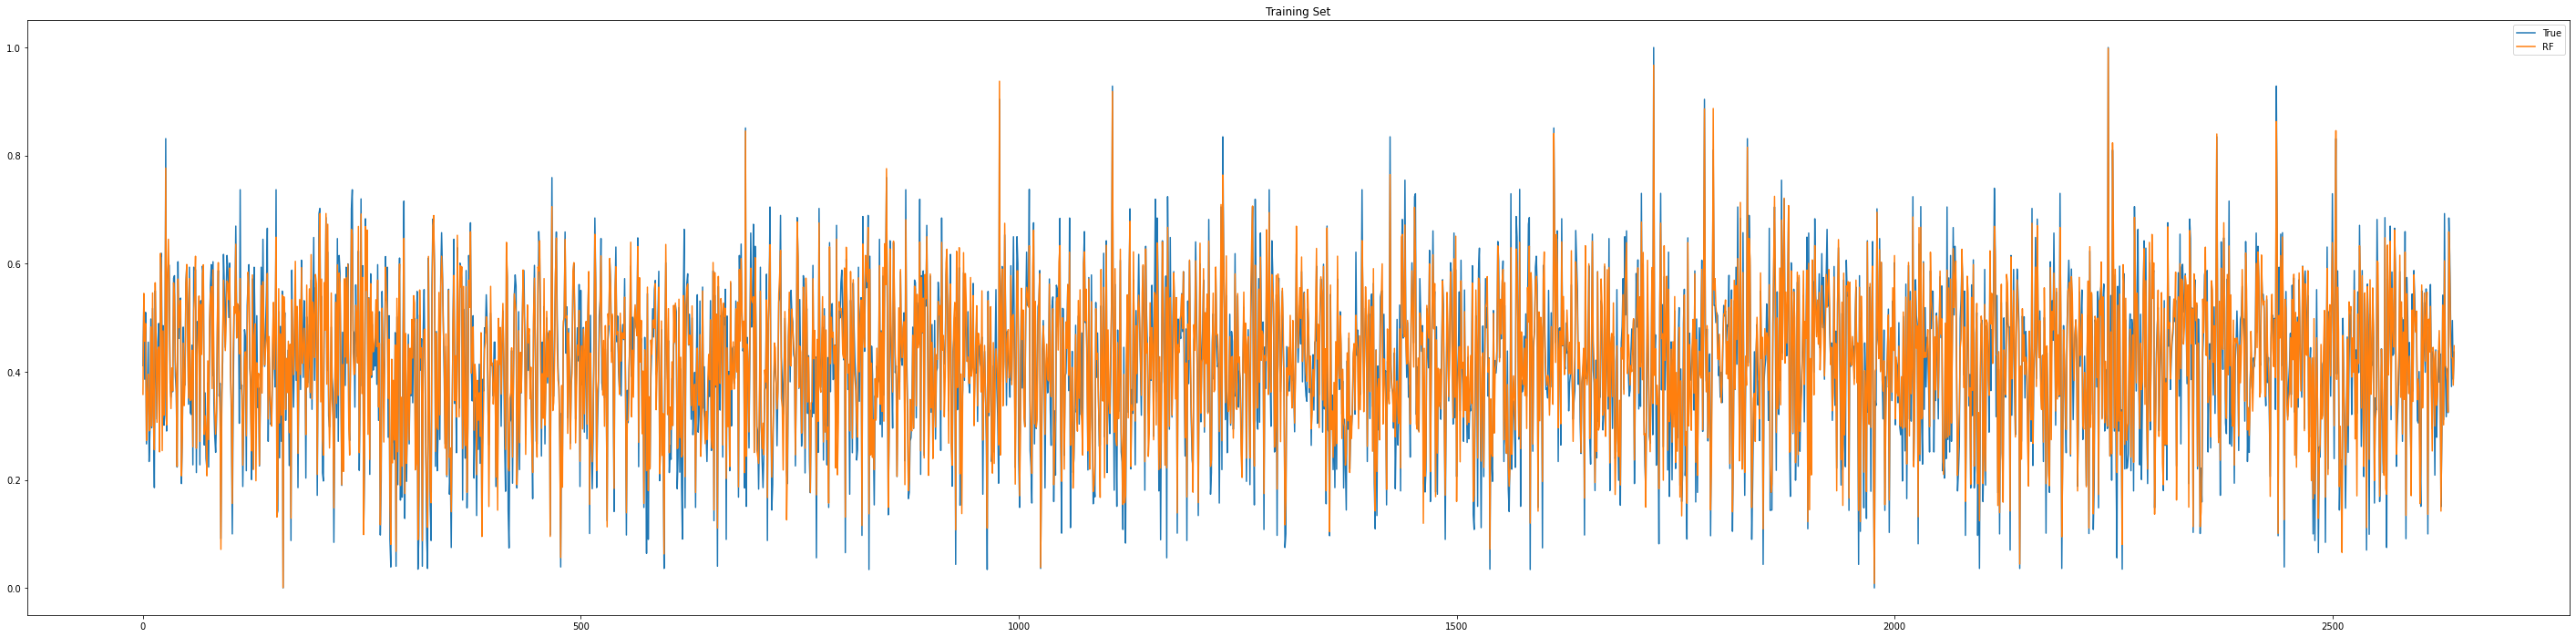

Training Set R-Square= 0.9015951219731643


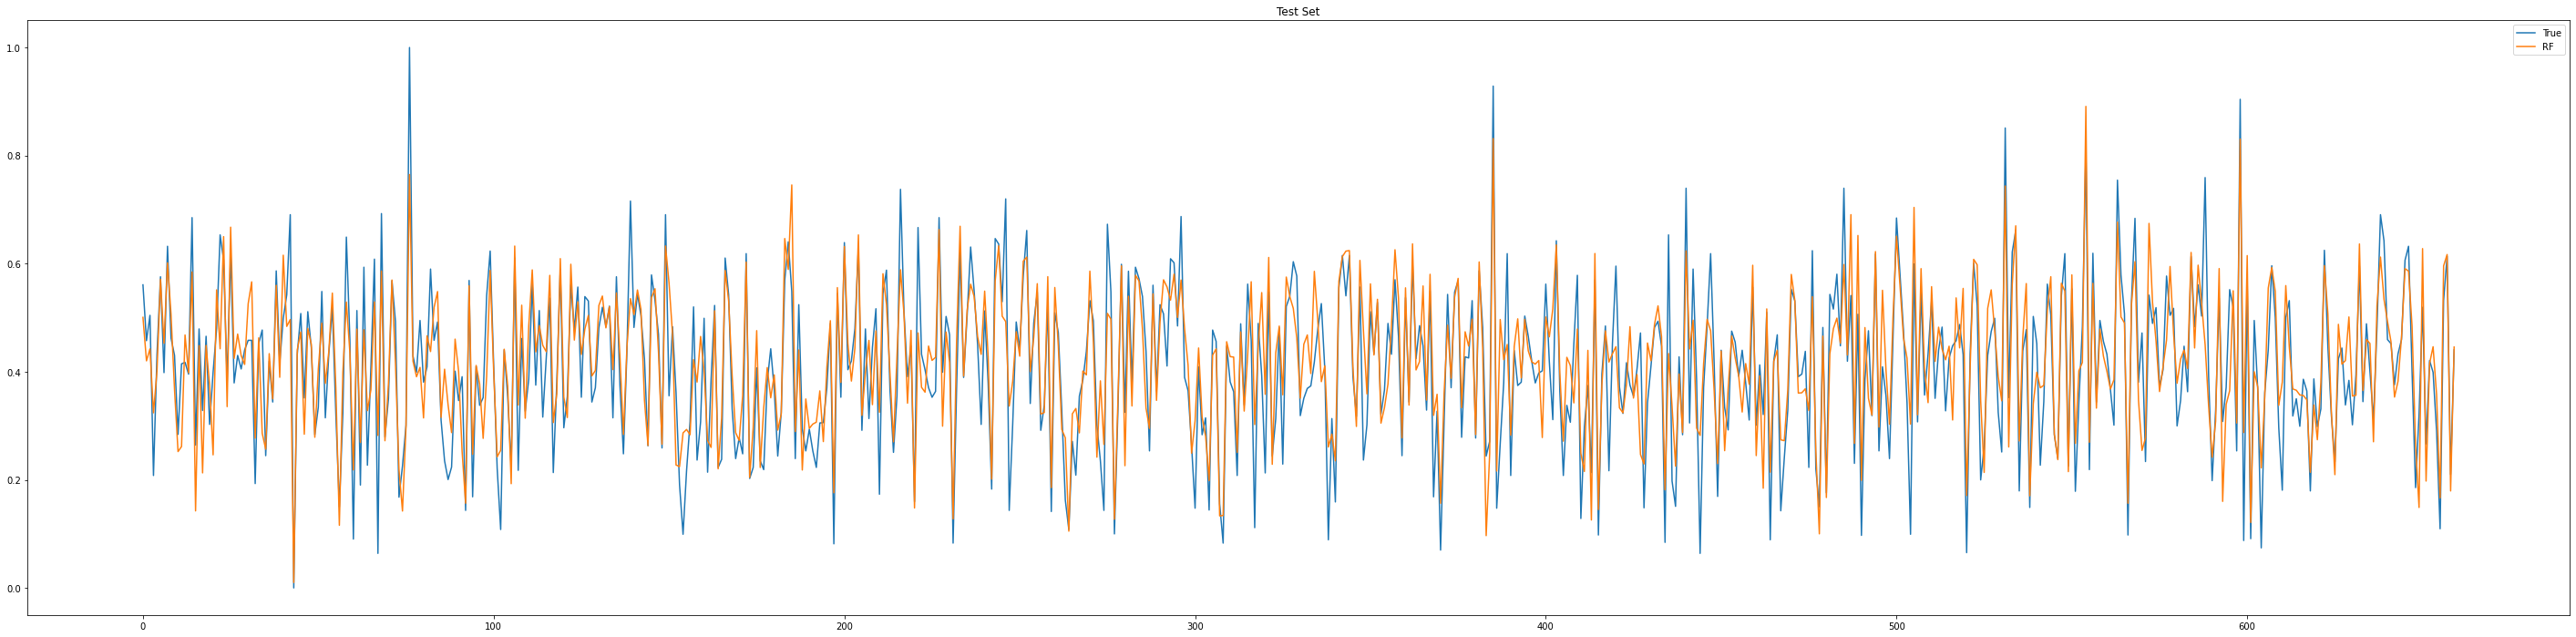

Test Set R-Square= 0.7322811318888061


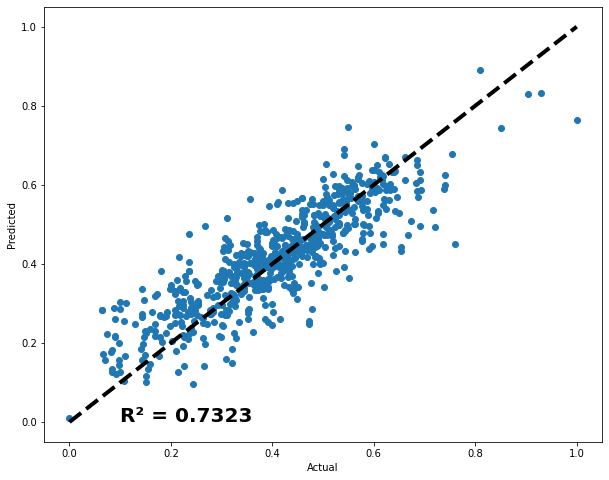

In [90]:
score = LSTM_full_14.evaluate(X_test_scaled_10_15_20, y_test_scaled_10_15_20, batch_size=1)

pred_lstm_full_14 = LSTM_full_14.predict(X_test_scaled_10_15_20) 
pred_train_lstm_full_14 = LSTM_full_14.predict(X_train_scaled_10_15_20)

rmse_lstm_full_14 = np.sqrt(mean_squared_error(y_test_scaled_10_15_20, pred_lstm_full_14)) 
print("RMSE: %f" % (rmse_lstm_full_14)) 

plt.figure(figsize=(50,12))
plt.plot(np.array(y_train_scaled_10_15_20))
# plt.plot(pred_train_mlp)
plt.plot(pred_train_lstm_full_14)

plt.title("Predictions on train data")
plt.legend(["True","RF"])
plt.title('Training Set')
plt.show()

# Compute R-Square value for training set
rf_indices_r2_train = r2_score(y_train_scaled_10_15_20 ,pred_train_lstm_full_14)
print("Training Set R-Square=", rf_indices_r2_train)


plt.figure(figsize=(50,12))
plt.plot(np.array(y_test_scaled_10_15_20))
# plt.plot(pred_train_mlp)
plt.plot(pred_lstm_full_14)

plt.title("Predictions on test data")
plt.legend(["True","RF"])
plt.title('Test Set')
plt.show()

# Compute R-Square value for test set
rf_indices_r2_test = r2_score(y_test_scaled_10_15_20,pred_lstm_full_14)
print("Test Set R-Square=", rf_indices_r2_test)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test_scaled_10_15_20, pred_lstm_full_14)
ax.plot([test_scaled_10_15_20.min(), test_scaled_10_15_20.max()], [test_scaled_10_15_20.min(), test_scaled_10_15_20.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

ax.annotate("R² = {:.4f}".format(r2_score(y_test_scaled_10_15_20, pred_lstm_full_14)), (0.1, 0),fontsize=20, fontweight='bold')
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/lstm/r2.png")
plt.show()



## Optuna LSTM

In [14]:

best_score_lstm_3 = float('-inf')  # Initialize the best score
lstm3_model_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/lstm/best_model.h5'

def lstm_optuna_case3(trial):
    clear_session()

    input_shape = (X_train_scaled_10_15_20.shape[1], 1)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_categorical('units', [16, 32, 64, 128]),
                   activation='tanh', input_shape=input_shape))
    model.add(Dense(1))

    learning_r = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    model.compile(loss='mse', optimizer=Adam(lr=learning_r), metrics=['mean_squared_error'])

    # Save the best model weights
    model_checkpoint = ModelCheckpoint(lstm3_model_path, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train_scaled_10_15_20, y_train_scaled_10_15_20, epochs=trial.suggest_int('epochs', 250, 450, 10),
              batch_size=8, validation_data=(X_test_scaled_10_15_20, y_test_scaled_10_15_20), callbacks=[model_checkpoint], verbose=0)

    model.load_weights(lstm3_model_path)  # Load the best weights saved during training

    y_pred = model.predict(X_test_scaled_10_15_20)
    score = r2_score(y_test_scaled_10_15_20, y_pred)

    global best_score_lstm_3
    if score > best_score_lstm_3:  # Update the best score and save the model weights
        best_score_lstm_3 = score
        model.save('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/lstm/best_model_weights.h5')

    return score

study_lstm_3 = optuna.create_study(direction="maximize")
study_lstm_3.optimize(lstm_optuna_case3, n_trials=50)

print("Number of finished trials: {}".format(len(study_lstm_3.trials)))

print("Best trial:")
trial_lstm_3 = study_lstm_3.best_trial

print("  Value: {}".format(trial_lstm_3.value))

print("  Params: ")
for key, value in trial_lstm_3.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-10 01:11:44,845] A new study created in memory with name: no-name-edb0763e-22f7-4e0c-bcce-c7668a9d012f


2023-11-10 01:11:45.798175: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 1s 5ms/step


[I 2023-11-10 01:18:11,583] Trial 0 finished with value: 0.38978046483396744 and parameters: {'units': 16, 'lr': 0.0002183699308333191, 'epochs': 330}. Best is trial 0 with value: 0.38978046483396744.


21/21 [==============================] - 1s 12ms/step


[I 2023-11-10 01:33:01,723] Trial 1 finished with value: 0.7267613803683854 and parameters: {'units': 128, 'lr': 0.00039116684059472217, 'epochs': 260}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 01:40:29,667] Trial 2 finished with value: 0.6753014373206787 and parameters: {'units': 64, 'lr': 0.0005610384710273318, 'epochs': 270}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 1s 15ms/step


[I 2023-11-10 02:02:21,460] Trial 3 finished with value: 0.695092717485845 and parameters: {'units': 128, 'lr': 0.0009847605924356844, 'epochs': 320}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 1s 17ms/step


[I 2023-11-10 02:27:03,787] Trial 4 finished with value: 0.6865451170085208 and parameters: {'units': 128, 'lr': 0.00033193059839945583, 'epochs': 310}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-10 02:32:52,161] Trial 5 finished with value: 0.2720423281894724 and parameters: {'units': 16, 'lr': 0.00011525711278311305, 'epochs': 330}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 0s 1ms/step


[I 2023-11-10 02:37:37,763] Trial 6 finished with value: 0.6055717580726657 and parameters: {'units': 16, 'lr': 0.00037711708955475446, 'epochs': 280}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-10 02:43:29,320] Trial 7 finished with value: 0.3898811826069323 and parameters: {'units': 32, 'lr': 0.00012651229972136804, 'epochs': 300}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-10 02:52:13,946] Trial 8 finished with value: 0.6224479984717988 and parameters: {'units': 32, 'lr': 0.0003834025319546122, 'epochs': 440}. Best is trial 1 with value: 0.7267613803683854.


21/21 [==============================] - 1s 4ms/step


[I 2023-11-10 03:00:07,956] Trial 9 finished with value: 0.7285749430839258 and parameters: {'units': 64, 'lr': 0.0006263489596461286, 'epochs': 270}. Best is trial 9 with value: 0.7285749430839258.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 03:10:19,921] Trial 10 finished with value: 0.7392287810618283 and parameters: {'units': 64, 'lr': 0.0009687739362345628, 'epochs': 380}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-10 03:21:39,414] Trial 11 finished with value: 0.7311731899675757 and parameters: {'units': 64, 'lr': 0.000944184657113817, 'epochs': 380}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 03:32:27,145] Trial 12 finished with value: 0.7240531043660299 and parameters: {'units': 64, 'lr': 0.0009501553942311192, 'epochs': 390}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-10 03:42:22,069] Trial 13 finished with value: 0.7129789222731052 and parameters: {'units': 64, 'lr': 0.0007300291154830558, 'epochs': 380}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-10 03:51:36,101] Trial 14 finished with value: 0.7344674425425962 and parameters: {'units': 64, 'lr': 0.0009814350278521562, 'epochs': 380}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 04:02:20,678] Trial 15 finished with value: 0.6549993596092643 and parameters: {'units': 64, 'lr': 0.0005260078202956013, 'epochs': 420}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 04:10:45,278] Trial 16 finished with value: 0.6903843953886062 and parameters: {'units': 64, 'lr': 0.0007389332147243671, 'epochs': 350}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 04:22:06,783] Trial 17 finished with value: 0.7134966293983734 and parameters: {'units': 64, 'lr': 0.0007643104580121124, 'epochs': 410}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 1s 2ms/step


[I 2023-11-10 04:28:54,131] Trial 18 finished with value: 0.5941854856663594 and parameters: {'units': 32, 'lr': 0.0005020264081009652, 'epochs': 360}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 04:42:07,037] Trial 19 finished with value: 0.6857026640009227 and parameters: {'units': 64, 'lr': 0.00025508476466673796, 'epochs': 450}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 04:53:23,216] Trial 20 finished with value: 0.7241399288395798 and parameters: {'units': 64, 'lr': 0.0008048100280448744, 'epochs': 360}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 05:04:18,011] Trial 21 finished with value: 0.7197571333105004 and parameters: {'units': 64, 'lr': 0.0009758915082298928, 'epochs': 390}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 05:16:33,446] Trial 22 finished with value: 0.7111066885942041 and parameters: {'units': 64, 'lr': 0.0006438514123705275, 'epochs': 410}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 05:27:00,340] Trial 23 finished with value: 0.7255256398965182 and parameters: {'units': 64, 'lr': 0.0008432817510408845, 'epochs': 380}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 1s 3ms/step


[I 2023-11-10 05:35:24,457] Trial 24 finished with value: 0.7193006122641011 and parameters: {'units': 64, 'lr': 0.0009832150915370286, 'epochs': 350}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 05:45:01,852] Trial 25 finished with value: 0.6982380605885397 and parameters: {'units': 64, 'lr': 0.0006693169708804012, 'epochs': 370}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 1s 12ms/step


[I 2023-11-10 06:09:36,876] Trial 26 finished with value: 0.7270910440073391 and parameters: {'units': 128, 'lr': 0.0008435260385629347, 'epochs': 430}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-10 06:17:16,546] Trial 27 finished with value: 0.6868926880336493 and parameters: {'units': 32, 'lr': 0.000586364790879888, 'epochs': 400}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 1s 1ms/step


[I 2023-11-10 06:23:05,959] Trial 28 finished with value: 0.6670313609842847 and parameters: {'units': 16, 'lr': 0.0008567997393073262, 'epochs': 340}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-10 06:29:38,873] Trial 29 finished with value: 0.4654474149337333 and parameters: {'units': 16, 'lr': 0.0004731733418894153, 'epochs': 370}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-10 06:41:21,349] Trial 30 finished with value: 0.7048187962071029 and parameters: {'units': 64, 'lr': 0.0006906603465672899, 'epochs': 400}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-10 06:48:19,746] Trial 31 finished with value: 0.737281287791369 and parameters: {'units': 64, 'lr': 0.000867602086078297, 'epochs': 250}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-10 06:55:50,587] Trial 32 finished with value: 0.7322950017749321 and parameters: {'units': 64, 'lr': 0.0008345270680651996, 'epochs': 250}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-10 07:02:53,783] Trial 33 finished with value: 0.722805364853353 and parameters: {'units': 64, 'lr': 0.0007957401858948228, 'epochs': 250}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 0s 11ms/step


[I 2023-11-10 07:18:39,559] Trial 34 finished with value: 0.7381971759686246 and parameters: {'units': 128, 'lr': 0.000594775911779777, 'epochs': 290}. Best is trial 10 with value: 0.7392287810618283.


21/21 [==============================] - 1s 14ms/step


[I 2023-11-10 07:35:06,907] Trial 35 finished with value: 0.7436800974424865 and parameters: {'units': 128, 'lr': 0.0006066298514434279, 'epochs': 290}. Best is trial 35 with value: 0.7436800974424865.


21/21 [==============================] - 1s 16ms/step


[I 2023-11-10 07:52:02,450] Trial 36 finished with value: 0.7020732859898386 and parameters: {'units': 128, 'lr': 0.0004491480341030885, 'epochs': 300}. Best is trial 35 with value: 0.7436800974424865.


21/21 [==============================] - 1s 16ms/step


[I 2023-11-10 08:08:16,922] Trial 37 finished with value: 0.7302221599463063 and parameters: {'units': 128, 'lr': 0.000563807639671232, 'epochs': 290}. Best is trial 35 with value: 0.7436800974424865.


21/21 [==============================] - 1s 14ms/step


[I 2023-11-10 08:23:09,686] Trial 38 finished with value: 0.7318711261096961 and parameters: {'units': 128, 'lr': 0.0006182561612447784, 'epochs': 270}. Best is trial 35 with value: 0.7436800974424865.


21/21 [==============================] - 1s 16ms/step


[I 2023-11-10 08:40:31,589] Trial 39 finished with value: 0.741352551682305 and parameters: {'units': 128, 'lr': 0.00042701721308321575, 'epochs': 310}. Best is trial 35 with value: 0.7436800974424865.


21/21 [==============================] - 1s 11ms/step


[I 2023-11-10 08:57:18,585] Trial 40 finished with value: 0.7607760915513243 and parameters: {'units': 128, 'lr': 0.0004253464131467946, 'epochs': 320}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 14ms/step


[I 2023-11-10 09:15:26,745] Trial 41 finished with value: 0.7297487105280892 and parameters: {'units': 128, 'lr': 0.000453119231032233, 'epochs': 320}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 14ms/step


[I 2023-11-10 09:33:17,726] Trial 42 finished with value: 0.7082531322919177 and parameters: {'units': 128, 'lr': 0.00041849324764711433, 'epochs': 310}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 16ms/step


[I 2023-11-10 09:48:59,173] Trial 43 finished with value: 0.7326929965247523 and parameters: {'units': 128, 'lr': 0.0005345921524969706, 'epochs': 290}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 2s 14ms/step


[I 2023-11-10 10:07:32,832] Trial 44 finished with value: 0.6827300894067161 and parameters: {'units': 128, 'lr': 0.00032533681349970354, 'epochs': 330}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 16ms/step


[I 2023-11-10 10:25:35,643] Trial 45 finished with value: 0.7081456223448094 and parameters: {'units': 128, 'lr': 0.0003563944505619999, 'epochs': 310}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 17ms/step


[I 2023-11-10 10:41:57,772] Trial 46 finished with value: 0.7205365486439408 and parameters: {'units': 128, 'lr': 0.0003953909002413914, 'epochs': 280}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 15ms/step


[I 2023-11-10 11:00:26,201] Trial 47 finished with value: 0.7407264352784946 and parameters: {'units': 128, 'lr': 0.0005763975826448696, 'epochs': 320}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 14ms/step


[I 2023-11-10 11:19:34,231] Trial 48 finished with value: 0.7514621842361573 and parameters: {'units': 128, 'lr': 0.0005075332051666905, 'epochs': 320}. Best is trial 40 with value: 0.7607760915513243.


21/21 [==============================] - 1s 13ms/step


[I 2023-11-10 11:37:58,175] Trial 49 finished with value: 0.7094259397774192 and parameters: {'units': 128, 'lr': 0.0004994609193916709, 'epochs': 320}. Best is trial 40 with value: 0.7607760915513243.


Number of finished trials: 50
Best trial:
  Value: 0.7607760915513243
  Params: 
    units: 128
    lr: 0.0004253464131467946
    epochs: 320


## Optuna MLP

In [ ]:
X_train_scaled =  c1_datas[0][0]
X_test_scaled  =  c1_datas[0][1]
y_train_scaled =  c1_datas[0][2]
y_test_scaled  =  c1_datas[0][3]
test           =  c1_datas[0][4]


print("Train: ", X_train_scaled.shape)
print("Test: ", X_test_scaled.shape)

print("Train: ", y_train_scaled.shape)
print("Test: ", y_test_scaled.shape)

print("yield:" , test.shape)

Train:  (880, 50)
Test:  (220, 50)
Train:  (880, 1)
Test:  (220, 1)
yield: (1100, 1)


In [11]:
best_score_mlp_3 = float('-inf')  # Initialize the best score
mlp3_model_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/mlp/best_model.h5'

def mlp_optuna_3(trial):
    clear_session()

    input_shape = (X_train_scaled_10_15_20.shape[1], 1)

    model = Sequential()
    model.add(
        Dense(units=trial.suggest_categorical('units_1', [64,128,256]), 
            activation='relu',
            input_shape=input_shape))
    model.add(
        Dense(units=trial.suggest_categorical('units_2', [8,16,32,64]), 
            activation='relu'))
    model.add(
        Dense(units=trial.suggest_categorical('units_3', [4,8]), 
            activation='relu'))
    model.add(Flatten())    
    model.add(Dense(1))

    learning_r = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    model.compile(loss='mse', optimizer=Adam(lr=learning_r), metrics=['mean_squared_error'])

    # Save the best model weights
    model_checkpoint = ModelCheckpoint(mlp3_model_path, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train_scaled_10_15_20, y_train_scaled_10_15_20, epochs=trial.suggest_int('epochs', 250, 450, 10),
              batch_size=8, validation_data=(X_test_scaled_10_15_20, y_test_scaled_10_15_20), callbacks=[model_checkpoint], verbose=0)

    model.load_weights(mlp3_model_path)  # Load the best weights saved during training

    y_pred = model.predict(X_test_scaled_10_15_20)
    score = r2_score(y_test_scaled_10_15_20, y_pred)

    global best_score_mlp_3
    if score > best_score_mlp_3:  # Update the best score and save the model weights
        best_score_mlp_3 = score
        model.save('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/mlp/best_model_weights.h5')
    return score
    


In [12]:
study_mlp_3 = optuna.create_study(direction="maximize")
study_mlp_3.optimize(mlp_optuna_3, n_trials=100)

print("Number of finished trials: {}".format(len(study_mlp_3.trials)))

print("Best trial:")
trial_mlp_3 = study_mlp_3.best_trial

print("  Value: {}".format(trial_mlp_3.value))

print("  Params: ")
for key, value in trial_mlp_3.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-11 14:02:18,539] A new study created in memory with name: no-name-ae30650d-be41-40d5-aa38-3b226eafcc49
2023-11-11 14:02:19.386021: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:03:43,448] Trial 0 finished with value: -2.953771296887453e-06 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 4, 'lr': 0.0009833119527871905, 'epochs': 250}. Best is trial 0 with value: -2.953771296887453e-06.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 14:06:44,586] Trial 1 finished with value: 0.6507900737339557 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 4, 'lr': 0.0001337037934659052, 'epochs': 440}. Best is trial 1 with value: 0.6507900737339557.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 14:10:35,256] Trial 2 finished with value: 0.6590478111317442 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.00013421053763421523, 'epochs': 320}. Best is trial 2 with value: 0.6590478111317442.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 14:13:06,331] Trial 3 finished with value: 0.6994861395329758 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0005219413464124187, 'epochs': 430}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 1ms/step


[I 2023-11-11 14:14:25,019] Trial 4 finished with value: 0.6034590313366235 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 4, 'lr': 0.0001374985052126349, 'epochs': 280}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:16:42,337] Trial 5 finished with value: 0.6624703685179927 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.00016895437537654232, 'epochs': 360}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:18:54,149] Trial 6 finished with value: 0.6893721749039223 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0008494642696150833, 'epochs': 370}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:22:04,768] Trial 7 finished with value: 0.6756816091382565 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.00024078053142164994, 'epochs': 450}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:23:52,807] Trial 8 finished with value: 0.6300912160068631 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 4, 'lr': 0.00013952281534180546, 'epochs': 320}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:25:20,603] Trial 9 finished with value: 0.628291167299855 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 4, 'lr': 0.00015056460055446846, 'epochs': 280}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 14:28:04,609] Trial 10 finished with value: 0.6722307147802968 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 8, 'lr': 0.000501629788005, 'epochs': 410}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:30:54,550] Trial 11 finished with value: 0.6851555806595894 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0006459834246540785, 'epochs': 390}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:33:17,518] Trial 12 finished with value: 0.6955212521324297 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.00045903072035311594, 'epochs': 390}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:35:45,037] Trial 13 finished with value: 0.6568235566379026 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.00040995021437018357, 'epochs': 410}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 14:39:00,949] Trial 14 finished with value: 0.611760597124449 and parameters: {'units_1': 128, 'units_2': 64, 'units_3': 8, 'lr': 0.00036467514281596415, 'epochs': 420}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 986us/step


[I 2023-11-11 14:41:02,142] Trial 15 finished with value: 0.6746616867323649 and parameters: {'units_1': 64, 'units_2': 16, 'units_3': 8, 'lr': 0.00029397468204988284, 'epochs': 390}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 1ms/step


[I 2023-11-11 14:42:58,891] Trial 16 finished with value: 0.6916748153455432 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0005761004198081779, 'epochs': 330}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 14:45:43,787] Trial 17 finished with value: 0.6730297475232285 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.00044877053817509696, 'epochs': 430}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 14:49:45,887] Trial 18 finished with value: 0.6978210890101055 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007144104295627406, 'epochs': 380}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 1s 8ms/step


[I 2023-11-11 14:53:00,240] Trial 19 finished with value: 0.6949529785875037 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007044164969734286, 'epochs': 340}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 14:57:15,873] Trial 20 finished with value: 0.6859273399366242 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007901266459869126, 'epochs': 370}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 15:01:34,778] Trial 21 finished with value: 0.6698938669429161 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.00053643666198151, 'epochs': 390}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 6s 6ms/step


[I 2023-11-11 15:06:47,002] Trial 22 finished with value: 0.6956255466391178 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0006206857087771034, 'epochs': 400}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 7ms/step


[I 2023-11-11 15:12:33,527] Trial 23 finished with value: 0.6691004519958865 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0006172762524052812, 'epochs': 410}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 5ms/step


[I 2023-11-11 15:17:53,729] Trial 24 finished with value: 0.68979099565037 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0007582099664585909, 'epochs': 450}. Best is trial 3 with value: 0.6994861395329758.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 15:24:06,929] Trial 25 finished with value: 0.7014533777638743 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0005713024025349729, 'epochs': 430}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 15:28:25,848] Trial 26 finished with value: 0.6589748757240157 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0005145312569719677, 'epochs': 430}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 1s 11ms/step


[I 2023-11-11 15:31:40,600] Trial 27 finished with value: 0.6765932031516897 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0009395055814753892, 'epochs': 430}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 5ms/step


[I 2023-11-11 15:36:51,995] Trial 28 finished with value: 0.6896074146842597 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0006669668731249007, 'epochs': 370}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 15:40:09,105] Trial 29 finished with value: 0.630370480005872 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0008324016823503387, 'epochs': 350}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-11 15:42:03,955] Trial 30 finished with value: 0.6742046403150579 and parameters: {'units_1': 64, 'units_2': 64, 'units_3': 8, 'lr': 0.0009747625293541538, 'epochs': 250}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 15:46:27,446] Trial 31 finished with value: 0.6592249348305386 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0006135960866407248, 'epochs': 400}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 15:50:57,445] Trial 32 finished with value: 0.6153541972439742 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.0005560974000752085, 'epochs': 440}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 15:55:02,214] Trial 33 finished with value: 0.6763059311738834 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.000709190686533568, 'epochs': 420}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 5ms/step


[I 2023-11-11 15:58:54,954] Trial 34 finished with value: 0.6233682562061814 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 4, 'lr': 0.0005894928940003343, 'epochs': 380}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 16:02:02,236] Trial 35 finished with value: 0.6605457794842318 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.0007227183052050383, 'epochs': 400}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 16:06:36,490] Trial 36 finished with value: 0.6992202358436446 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0004724815199358965, 'epochs': 440}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 1s 7ms/step


[I 2023-11-11 16:10:49,012] Trial 37 finished with value: 0.6867709027641404 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0003829457308119319, 'epochs': 450}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 16:13:08,711] Trial 38 finished with value: 0.6697879527310102 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 4, 'lr': 0.0004722448486695371, 'epochs': 440}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-11 16:15:46,431] Trial 39 finished with value: 0.6856833298362022 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005192039389367639, 'epochs': 300}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 16:19:30,130] Trial 40 finished with value: 0.6772200589130896 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.00041166830783234275, 'epochs': 420}. Best is trial 25 with value: 0.7014533777638743.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 16:23:35,554] Trial 41 finished with value: 0.7082866685476991 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006281616527043613, 'epochs': 440}. Best is trial 41 with value: 0.7082866685476991.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 16:28:17,311] Trial 42 finished with value: 0.711572426131441 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.000827744772677698, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 5ms/step


[I 2023-11-11 16:32:42,092] Trial 43 finished with value: 0.7067744760702328 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0008081285523911507, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 16:35:33,825] Trial 44 finished with value: 0.6932883992085792 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 8, 'lr': 0.0009064689413936999, 'epochs': 450}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 16:39:53,383] Trial 45 finished with value: 0.6940264291114302 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0008324288532668942, 'epochs': 430}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 16:42:34,896] Trial 46 finished with value: 0.6445366199051223 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 4, 'lr': 0.0006617162452083803, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-11 16:46:37,904] Trial 47 finished with value: 0.6959239124367702 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.000874353486527594, 'epochs': 420}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 16:48:32,611] Trial 48 finished with value: 0.6551633214494883 and parameters: {'units_1': 64, 'units_2': 8, 'units_3': 8, 'lr': 0.0008037771933009334, 'epochs': 410}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 3s 2ms/step


[I 2023-11-11 16:51:23,187] Trial 49 finished with value: 0.6778058396367281 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0007633049213973544, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 16:54:36,707] Trial 50 finished with value: 0.670213896462582 and parameters: {'units_1': 128, 'units_2': 32, 'units_3': 8, 'lr': 0.0005685293069799118, 'epochs': 450}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 16:58:09,602] Trial 51 finished with value: 0.7070950306806171 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0004951452123364655, 'epochs': 430}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:01:58,002] Trial 52 finished with value: 0.6234649790881726 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005498801142510397, 'epochs': 430}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 17:05:34,832] Trial 53 finished with value: 0.700716220185815 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0009814760964735616, 'epochs': 420}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:08:50,656] Trial 54 finished with value: 0.6882119135540491 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0009621391023476056, 'epochs': 420}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:11:34,344] Trial 55 finished with value: 0.6662623276382407 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0008784982621979978, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-11 17:14:13,149] Trial 56 finished with value: 0.6903551294509652 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.000677079274993379, 'epochs': 410}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:17:05,814] Trial 57 finished with value: 0.6703530844058285 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.00099985296444597, 'epochs': 450}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:19:35,869] Trial 58 finished with value: 0.6859356329896134 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007675211397607345, 'epochs': 430}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:22:06,019] Trial 59 finished with value: 0.688591550981865 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0008860003007717626, 'epochs': 420}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 2s 2ms/step


[I 2023-11-11 17:24:25,096] Trial 60 finished with value: 0.6174030206596197 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0006485436601943376, 'epochs': 400}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-11 17:26:41,876] Trial 61 finished with value: 0.6925822091767636 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.000739624344102073, 'epochs': 430}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 1ms/step


[I 2023-11-11 17:28:32,157] Trial 62 finished with value: 0.6350747028460646 and parameters: {'units_1': 128, 'units_2': 16, 'units_3': 8, 'lr': 0.0008133083096625097, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:31:09,777] Trial 63 finished with value: 0.6922056790606719 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006055447745056917, 'epochs': 410}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 17:33:22,854] Trial 64 finished with value: 0.6643124017488138 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0005087282921980732, 'epochs': 430}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 3s 163ms/step


[I 2023-11-11 17:35:27,561] Trial 65 finished with value: 0.688306995089144 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0006867819970112298, 'epochs': 450}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:37:07,294] Trial 66 finished with value: 0.6863093461298919 and parameters: {'units_1': 128, 'units_2': 8, 'units_3': 8, 'lr': 0.0006276417476094581, 'epochs': 420}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 17:39:55,452] Trial 67 finished with value: 0.6854231790746113 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0009080158608137098, 'epochs': 410}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 17:42:46,204] Trial 68 finished with value: 0.6974723900668243 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.000791049939588702, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 17:45:16,086] Trial 69 finished with value: 0.6953322400839433 and parameters: {'units_1': 256, 'units_2': 16, 'units_3': 8, 'lr': 0.0005729484859933374, 'epochs': 430}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 17:48:33,837] Trial 70 finished with value: 0.6986379834011048 and parameters: {'units_1': 256, 'units_2': 64, 'units_3': 8, 'lr': 0.000711913120849931, 'epochs': 400}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 17:51:25,574] Trial 71 finished with value: 0.6919438679908245 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0004539513262252138, 'epochs': 440}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 17:54:29,013] Trial 72 finished with value: 0.7063931031522797 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005197989148911529, 'epochs': 450}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 4ms/step


[I 2023-11-11 17:57:34,744] Trial 73 finished with value: 0.6965821444830331 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0004998634828525652, 'epochs': 450}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:00:45,744] Trial 74 finished with value: 0.6889779711464704 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005378931385051781, 'epochs': 450}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:03:40,038] Trial 75 finished with value: 0.7078634228070629 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005905870253580512, 'epochs': 420}. Best is trial 42 with value: 0.711572426131441.


21/21 [==============================] - 4s 175ms/step


[I 2023-11-11 18:06:20,241] Trial 76 finished with value: 0.7130886927777256 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.000605511636281923, 'epochs': 420}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 18:09:22,977] Trial 77 finished with value: 0.6778737951763927 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.0005858624028714418, 'epochs': 440}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:12:15,324] Trial 78 finished with value: 0.6814118638531532 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.000643995792903639, 'epochs': 430}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:15:15,779] Trial 79 finished with value: 0.6117652953288141 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006149240541145607, 'epochs': 430}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 1ms/step


[I 2023-11-11 18:16:54,853] Trial 80 finished with value: 0.6916458029585134 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005455839330906493, 'epochs': 260}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 1ms/step


[I 2023-11-11 18:19:28,067] Trial 81 finished with value: 0.6913530013663063 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007435100819442284, 'epochs': 420}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:21:47,175] Trial 82 finished with value: 0.6202318470806674 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0008333459730262044, 'epochs': 410}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:24:13,131] Trial 83 finished with value: 0.7111425777177057 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.000683809997994826, 'epochs': 420}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:26:46,382] Trial 84 finished with value: 0.7075872635329568 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006618218923571122, 'epochs': 440}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:28:37,529] Trial 85 finished with value: 0.685724829954113 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006942367157271793, 'epochs': 310}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:30:51,294] Trial 86 finished with value: 0.6775961219156346 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006619352052806358, 'epochs': 360}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 2s 116ms/step


[I 2023-11-11 18:32:48,370] Trial 87 finished with value: 0.6960311218435457 and parameters: {'units_1': 64, 'units_2': 32, 'units_3': 8, 'lr': 0.0005917429384809267, 'epochs': 450}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:35:32,469] Trial 88 finished with value: 0.6972955735644071 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006324844465315912, 'epochs': 440}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:38:19,656] Trial 89 finished with value: 0.5604927585608623 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 4, 'lr': 0.000726913652541787, 'epochs': 450}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 3ms/step


[I 2023-11-11 18:41:15,734] Trial 90 finished with value: 0.7053665536067155 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007723255243969781, 'epochs': 440}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:44:17,330] Trial 91 finished with value: 0.70728253328063 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007645926421833598, 'epochs': 440}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:47:18,312] Trial 92 finished with value: 0.7072686463714701 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006714516043897316, 'epochs': 430}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:49:59,567] Trial 93 finished with value: 0.6853206412675249 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007028283822500264, 'epochs': 420}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:52:44,145] Trial 94 finished with value: 0.693961360177481 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006695163461206963, 'epochs': 430}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:55:28,640] Trial 95 finished with value: 0.6812079829272274 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0008078870736484967, 'epochs': 430}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 18:57:41,635] Trial 96 finished with value: 0.6510224865882367 and parameters: {'units_1': 256, 'units_2': 8, 'units_3': 8, 'lr': 0.0008501502250618795, 'epochs': 420}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 2ms/step


[I 2023-11-11 19:00:20,274] Trial 97 finished with value: 0.6899401374250866 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0007595387062566788, 'epochs': 440}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 4s 191ms/step


[I 2023-11-11 19:02:54,733] Trial 98 finished with value: 0.6694774611240465 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0006397691731737274, 'epochs': 410}. Best is trial 76 with value: 0.7130886927777256.


21/21 [==============================] - 0s 1ms/step


[I 2023-11-11 19:05:11,233] Trial 99 finished with value: 0.6853495468773615 and parameters: {'units_1': 256, 'units_2': 32, 'units_3': 8, 'lr': 0.0005999781771348023, 'epochs': 380}. Best is trial 76 with value: 0.7130886927777256.


Number of finished trials: 100
Best trial:
  Value: 0.7130886927777256
  Params: 
    units_1: 256
    units_2: 32
    units_3: 8
    lr: 0.000605511636281923
    epochs: 420


## MLP

In [30]:
input_shape=(X_train_scaled_10_15_20.shape[1],1)

clear_session()
MLP_full_14 = Sequential()
MLP_full_14.add(Dense(256, activation="relu",input_shape=input_shape))
#MLP_full.add(Dropout(0.2))
MLP_full_14.add(Dense(64, activation="relu"))
#MLP_full.add(Dropout(0.4))
MLP_full_14.add(Dense(8, activation="relu"))
MLP_full_14.add(Flatten())    
MLP_full_14.add(Dense(1))
MLP_full_14.compile(loss='mse', optimizer=Adam(lr=0.00023260227608851982))#,decay=1e-3 / 200))

history_MLP_full_14 = MLP_full_14.fit(X_train_scaled_10_15_20, y_train_scaled_10_15_20, epochs=400, batch_size=1)


Epoch 1/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0186
Epoch 2/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0133
Epoch 3/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0118
Epoch 4/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0108
Epoch 5/400
2640/2640 [==============================] - 4s 1ms/step - loss: 0.0106
Epoch 6/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0103
Epoch 7/400
2640/2640 [==============================] - 3s 980us/step - loss: 0.0101
Epoch 8/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0099
Epoch 9/400
2640/2640 [==============================] - 3s 992us/step - loss: 0.0099
Epoch 10/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0096
Epoch 11/400
2640/2640 [==============================] - 3s 1ms/step - loss: 0.0094
Epoch 12/400
2640/2640 [==============================] - 4s 1ms/step 

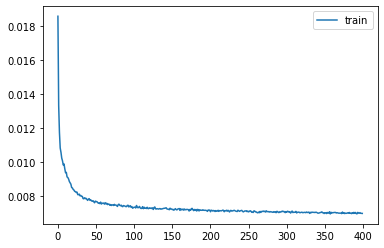

In [42]:
plt.plot(history_MLP_full_14.history['loss'], label='train')
plt.legend()
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/mlp/loss.png")
plt.show()

21/21 [==============================] - 0s 3ms/step
RMSE: 0.086122


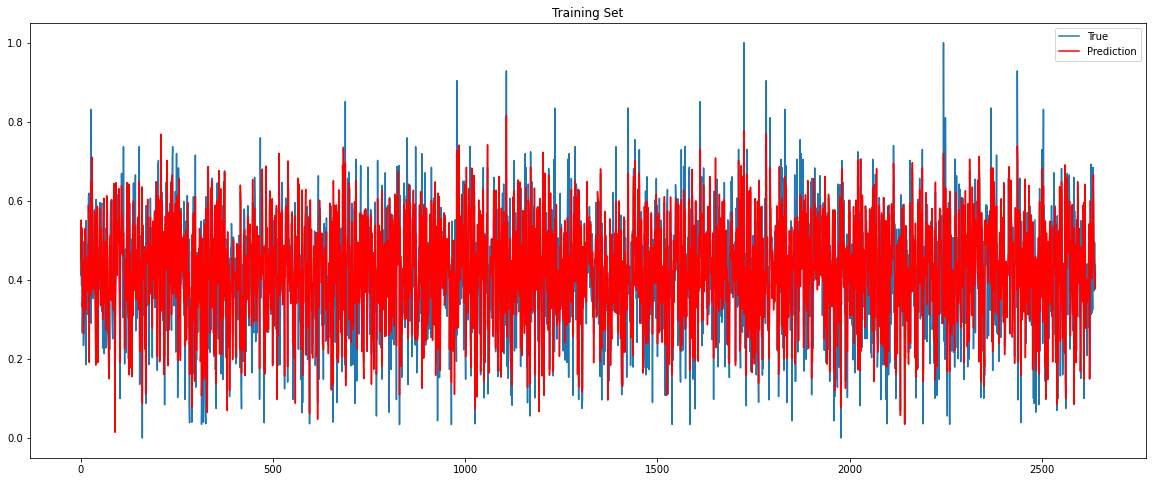

Training Set R-Square= 0.7054048599438016


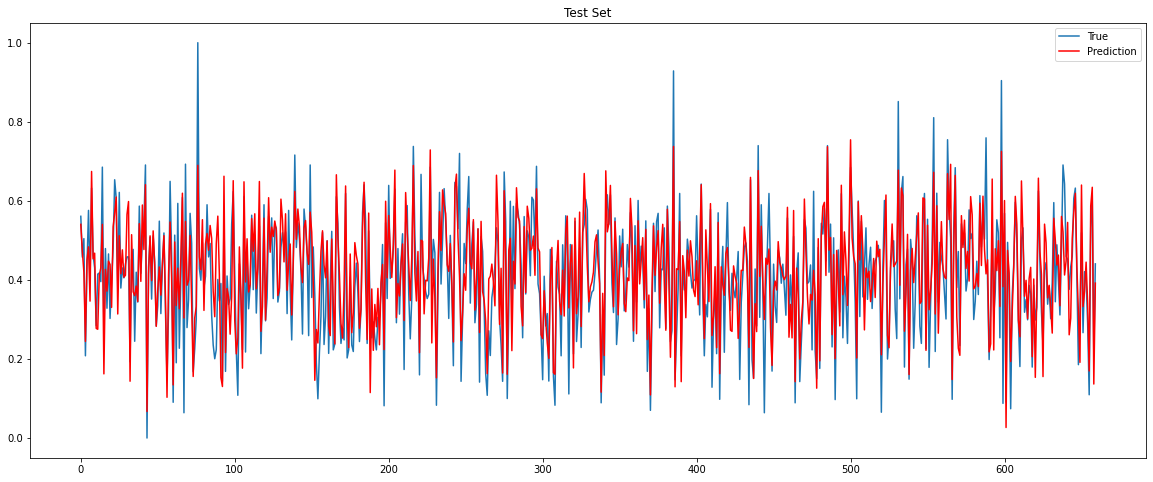

Test Set R-Square= 0.6812693160134772


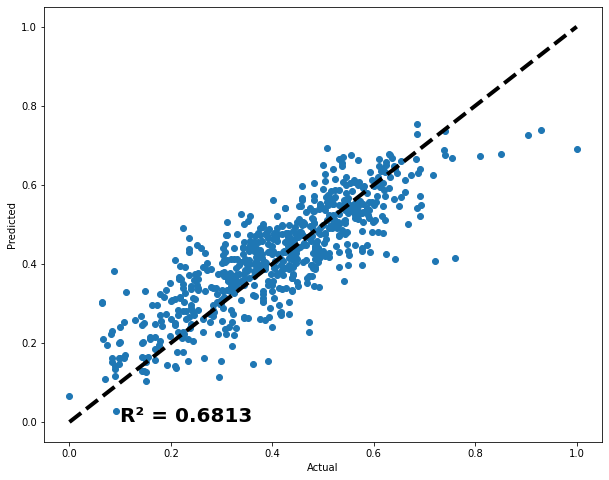

In [40]:
pred_train_mlp_full_14 = MLP_full_14.predict(X_train_scaled_10_15_20)
pred_test_mlp_full_14 = MLP_full_14.predict(X_test_scaled_10_15_20)

rmse_mlp_full_14 = np.sqrt(mean_squared_error(y_test_scaled_10_15_20, pred_test_mlp_full_14)) 
print("RMSE: %f" % (rmse_mlp_full_14)) 

plt.figure(figsize=(20,8))
plt.plot(np.array(y_train_scaled_10_15_20))
plt.plot(pred_train_mlp_full_14,'r')
plt.title("Average WFV predictions on train data")
plt.legend(["True", "Prediction"])
plt.title('Training Set')
plt.savefig("")
plt.show()

# Compute R-Square value for training set
mlp_indices_r2_train = r2_score(y_train_scaled_10_15_20,pred_train_mlp_full_14)
print("Training Set R-Square=", mlp_indices_r2_train)


plt.figure(figsize=(20,8))
plt.plot(np.array(y_test_scaled_10_15_20))
plt.plot(pred_test_mlp_full_14,'r')
plt.title("Average WFV predictions on test data")
plt.legend(["True", "Prediction"])
plt.title('Test Set')
plt.show()

# Compute R-Square value for training set
mlp_indices_r2_test = r2_score(y_test_scaled_10_15_20,pred_test_mlp_full_14)
print("Test Set R-Square=", mlp_indices_r2_test)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test_scaled_10_15_20, pred_test_mlp_full_14)
ax.plot([test_scaled_10_15_20.min(), test_scaled_10_15_20.max()], [test_scaled_10_15_20.min(), test_scaled_10_15_20.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

ax.annotate("R² = {:.4f}".format(r2_score(y_test_scaled_10_15_20, pred_test_mlp_full_14)), (0.1, 0),fontsize=20, fontweight='bold')
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/mlp/r2.png")
plt.show()




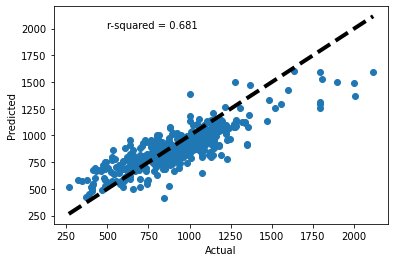

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test_full_16, pred_test_mlp_full_16)
ax.plot([yield_full_16.min(), yield_full_16.max()], [yield_full_16.min(), yield_full_16.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

ax.annotate("r-squared = {:.3f}".format(r2_score(y_test_full_16, pred_test_mlp_full_16)), (500, 2000))
plt.show()


## XGBoost

In [222]:
param = {
    'max_depth': 4,
    'learning_rate': 0.22263268291255955,
    'n_estimators': 835,
    'min_child_weight': 3,
    'gamma': 0.013250717825604455,
    'subsample': 0.4671058000154715,
    'colsample_bytree': 0.09841076552545186,
    'reg_alpha': 0.8142648557298242,
    'reg_lambda': 0.16537014620751905,
    'random_state': 641,
}

xg_reg_full_14 = xgb.XGBRegressor(**param)
# xg_reg_full_14 = xgb.XGBRegressor(objective ='reg:squarederror') 

# xg_reg_full_14.fit(X_train_scaled_10_15_20, y_train_scaled_10_15_20)
xg_reg_full_14.load_model("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/xgboost/best_model_weights.json")

RMSE: 0.074740


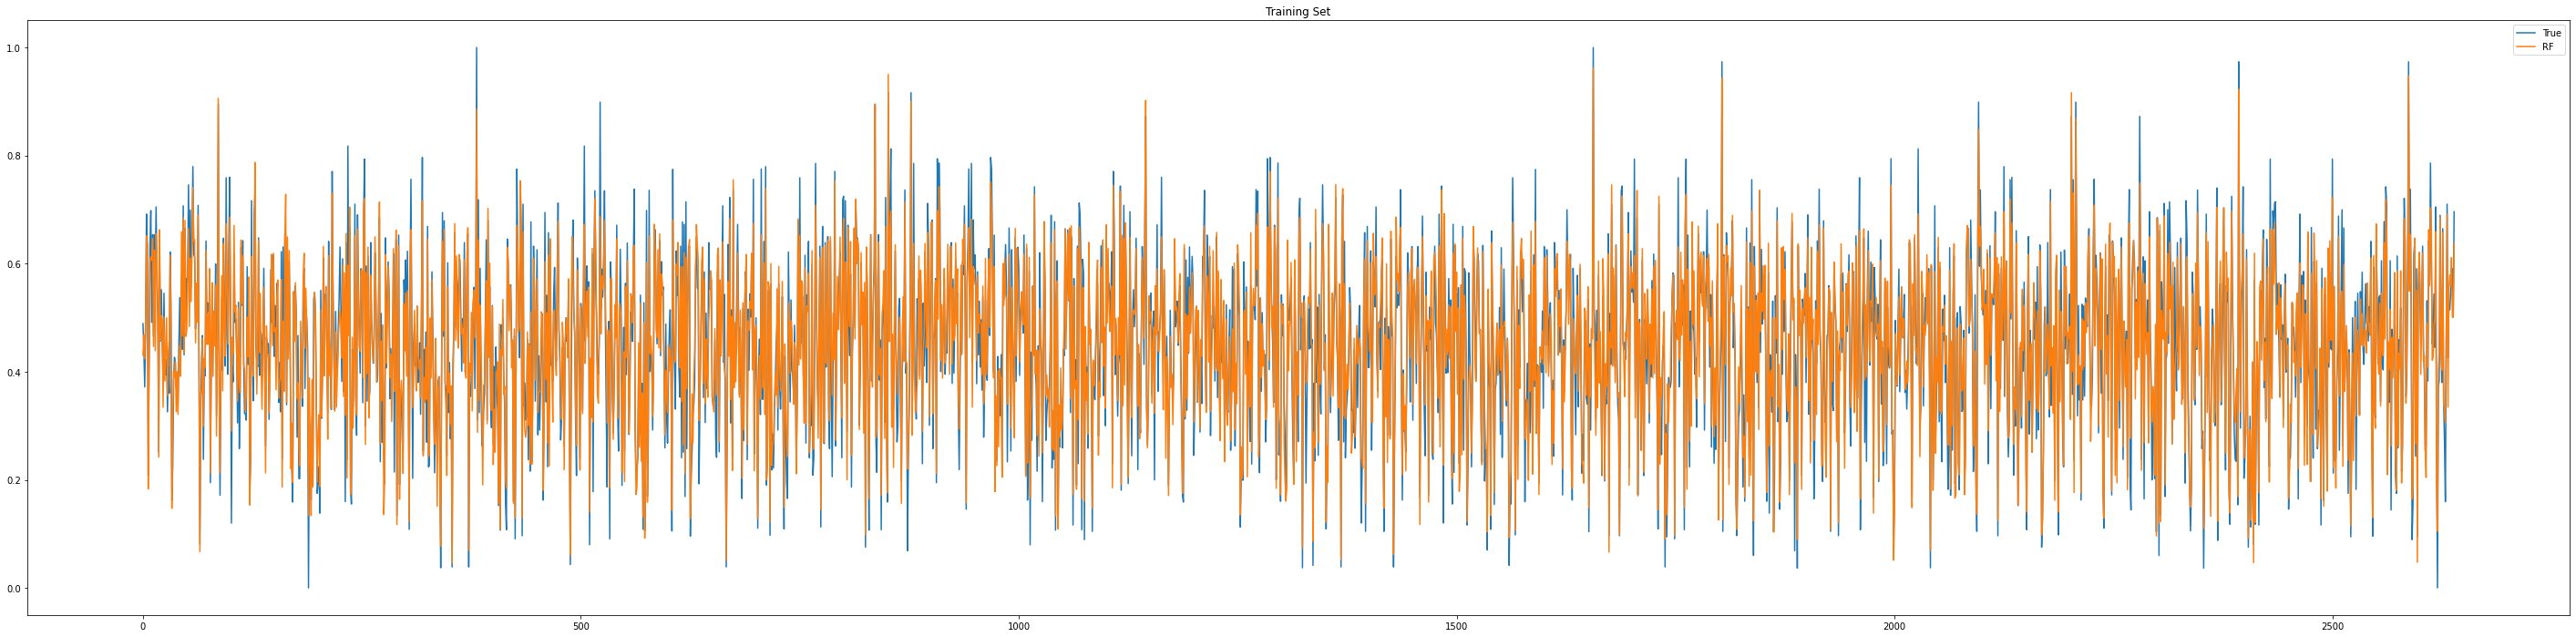

Training Set R-Square= 0.9062059114721946


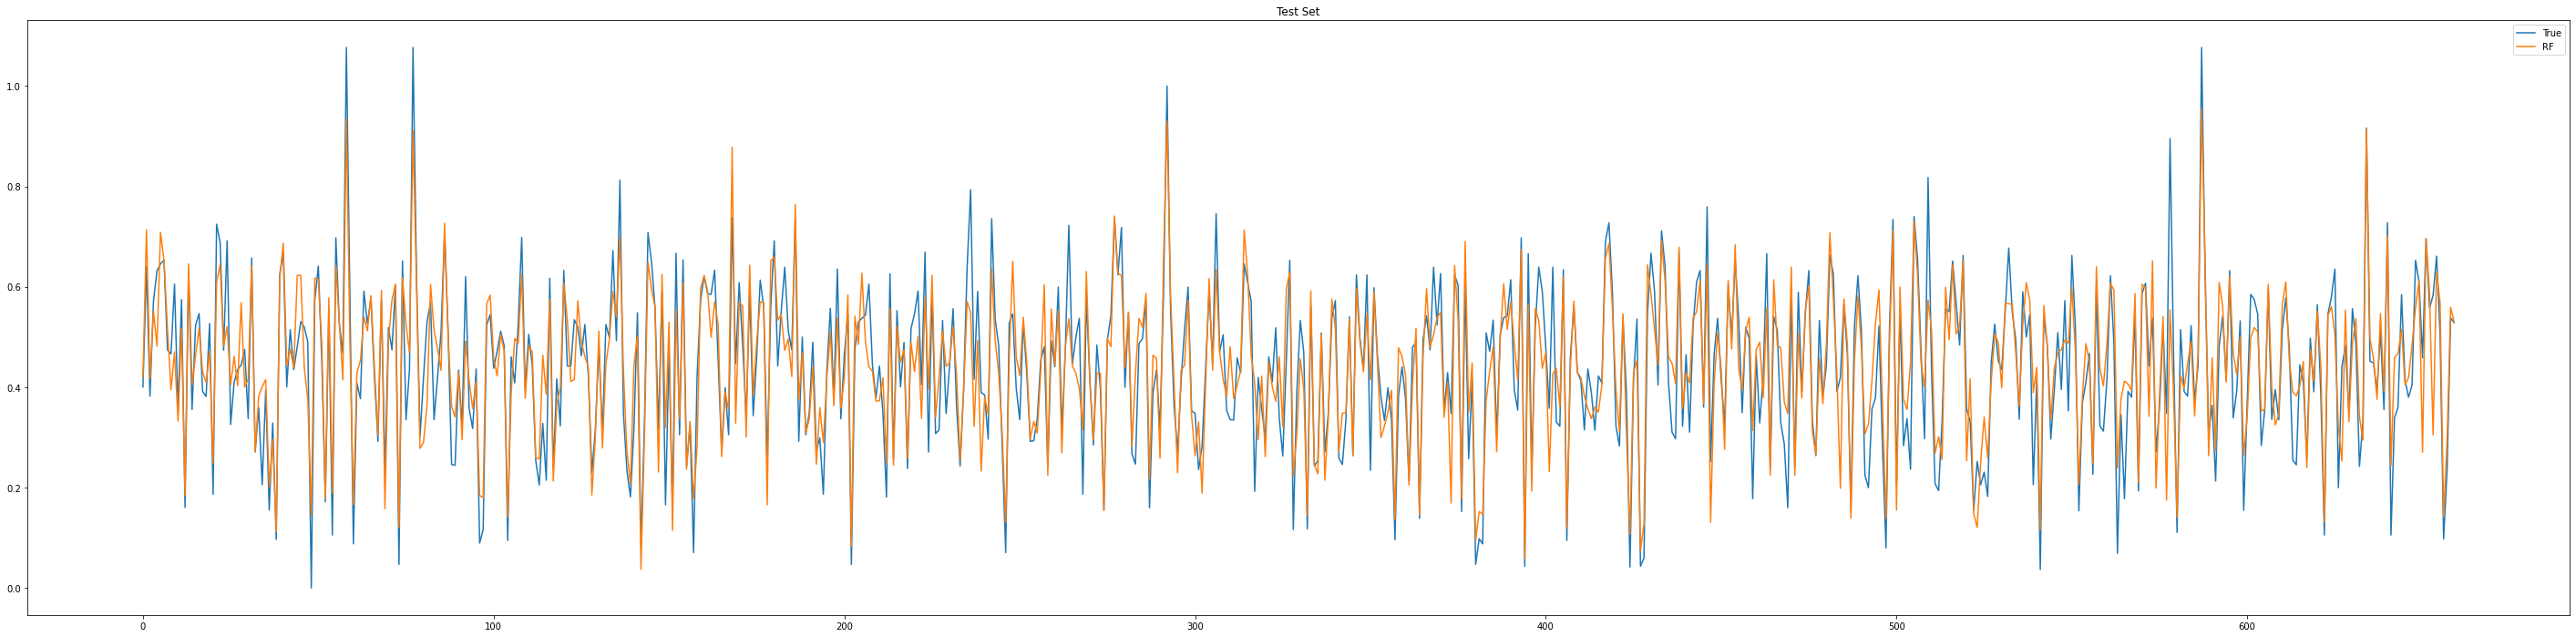

Test Set R-Square= 0.801850415074157


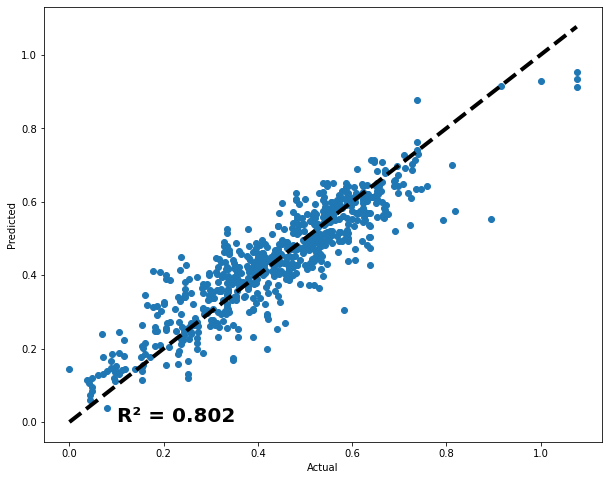

In [23]:
pred_xgb_full_14 = xg_reg_full_14.predict(X_test_scaled_10_15_20)
pred_train_xgb_full_14 = xg_reg_full_14.predict(X_train_scaled_10_15_20)

rmse_xgb_full_3 = np.sqrt(mean_squared_error(y_test_scaled_10_15_20, pred_xgb_full_14)) 

print("RMSE: %f" % (rmse_xgb_full_3)) 

plt.figure(figsize=(50,12))
plt.plot(np.array(y_train_scaled_10_15_20))
# plt.plot(pred_train_mlp)
plt.plot(pred_train_xgb_full_14)

plt.title("Predictions on train data")
plt.legend(["True","RF"])
plt.title('Training Set')
plt.show()

# Compute R-Square value for training set
rf_indices_r2_train_full = r2_score(y_train_scaled_10_15_20,pred_train_xgb_full_14)
print("Training Set R-Square=", rf_indices_r2_train_full)

plt.figure(figsize=(50,12))
plt.plot(np.array(y_test_scaled_10_15_20))
# plt.plot(pred_train_mlp)
plt.plot(pred_xgb_full_14)

plt.title("Predictions on test data")
plt.legend(["True","RF"])
plt.title('Test Set')
plt.show()

# Compute R-Square value for training set
rf_indices_r2_test_full = r2_score(y_test_scaled_10_15_20,pred_xgb_full_14)
print("Test Set R-Square=", rf_indices_r2_test_full)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_test_scaled_10_15_20, pred_xgb_full_14)
ax.plot([test_scaled_10_15_20.min(), test_scaled_10_15_20.max()], [test_scaled_10_15_20.min(), test_scaled_10_15_20.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

ax.annotate("R² = {:.3f}".format(r2_score(y_test_scaled_10_15_20, pred_xgb_full_14)), (0.1, 0),fontsize=20, fontweight='bold')
plt.savefig("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/xgboost/r2.png")
plt.show()


## Optuna XGBoost

In [20]:
best_score_xgb_3 = float('inf')  # Initialize the best score

def optuna_xgb_3(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_scaled_10_15_20, y_train_scaled_10_15_20)
    y_pred = model.predict(X_test_scaled_10_15_20)

    mse_3 = mean_squared_error(y_test_scaled_10_15_20, y_pred)
    global best_score_xgb_3
    if mse_3 < best_score_xgb_3:  # Update the best score and save the model weights
        best_score_xgb_3 = mse_3
        model.save_model('/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case3/xgboost/best_model_weights.json')
    return mse_3

# Create the study
study_xgb_3 = optuna.create_study(direction='minimize', study_name='regression')
study_xgb_3.optimize(optuna_xgb_3, n_trials=100)


print("Number of finished trials: {}".format(len(study_xgb_3.trials)))

print("Best trial:")
trial_xgb_3 = study_xgb_3.best_trial

print("  Value: {}".format(trial_xgb_3.value))

print("  Params: ")
for key, value in trial_xgb_3.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-13 18:36:32,150] A new study created in memory with name: regression
[I 2023-11-13 18:36:35,954] Trial 0 finished with value: 0.01410153136576198 and parameters: {'max_depth': 4, 'learning_rate': 0.45503564601505414, 'n_estimators': 868, 'min_child_weight': 1, 'gamma': 0.8204642137812881, 'subsample': 0.28813692644101474, 'colsample_bytree': 0.8699826498242662, 'reg_alpha': 0.415319345672984, 'reg_lambda': 0.8919077749991401, 'random_state': 596}. Best is trial 0 with value: 0.01410153136576198.
[I 2023-11-13 18:36:36,470] Trial 1 finished with value: 0.015450272788094173 and parameters: {'max_depth': 3, 'learning_rate': 0.48924662017417936, 'n_estimators': 191, 'min_child_weight': 10, 'gamma': 0.7668019015711163, 'subsample': 0.3198854353018256, 'colsample_bytree': 0.44875328859574626, 'reg_alpha': 0.727137840389391, 'reg_lambda': 0.26687918486105416, 'random_state': 31}. Best is trial 0 with value: 0.01410153136576198.
[I 2023-11-13 18:36:41,595] Trial 2 finished with valu

Number of finished trials: 100
Best trial:
  Value: 0.005586109972063694
  Params: 
    max_depth: 6
    learning_rate: 0.5776561057845523
    n_estimators: 406
    min_child_weight: 3
    gamma: 0.029688898134754657
    subsample: 0.9789265023319311
    colsample_bytree: 0.5960863005175199
    reg_alpha: 0.756038550251351
    reg_lambda: 0.4850395728418791
    random_state: 132


# Results

In [388]:
SAVE_DIR = "/Users/alperbalmumcu/Github/crop-yield-estimation/results/"


In [392]:
def print_results(model, X_test, y_test, test, r2_save_path):
    pred = model.predict(X_test) 
    
    rmse = np.sqrt(mean_squared_error(y_test, pred)) 
    print("RMSE: %f" % (rmse)) 

    r2 = r2_score(y_test, pred)
    print("R2: %f" % (r2)) 

    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(y_test, pred)
    ax.plot([test.min(), test.max()], [test.min(), test.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.annotate("R² = {:.4f}".format(r2), (0.1, 0),fontsize=20, fontweight='bold')
    plt.savefig(r2_save_path)
    plt.show()
    return rmse, r2

## Case 1

### LSTM

In [373]:
# Number of finished trials: 50
# Best trial:
#   Value: 0.6805316795582315
#   Params: 
#     units: 64
#     lr: 0.0007093439924293168
#     epochs: 290

clear_session()
case1_LSTM= Sequential()
case1_LSTM.add(LSTM(64, activation='tanh',input_shape=(c1_datas[0][0].shape[1],1))) 
case1_LSTM.add(Dense(1))

optimizer = Adam(lr=0.0007093439924293168)
case1_LSTM.compile(optimizer=optimizer, loss='mse',metrics=[RSquare()])
case1_LSTM.load_weights(SAVE_DIR + "case1/lstm/best_model_weights.h5")

In [440]:
case1_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


7/7 [==============================] - 0s 6ms/step
RMSE: 0.082065
R2: 0.680532


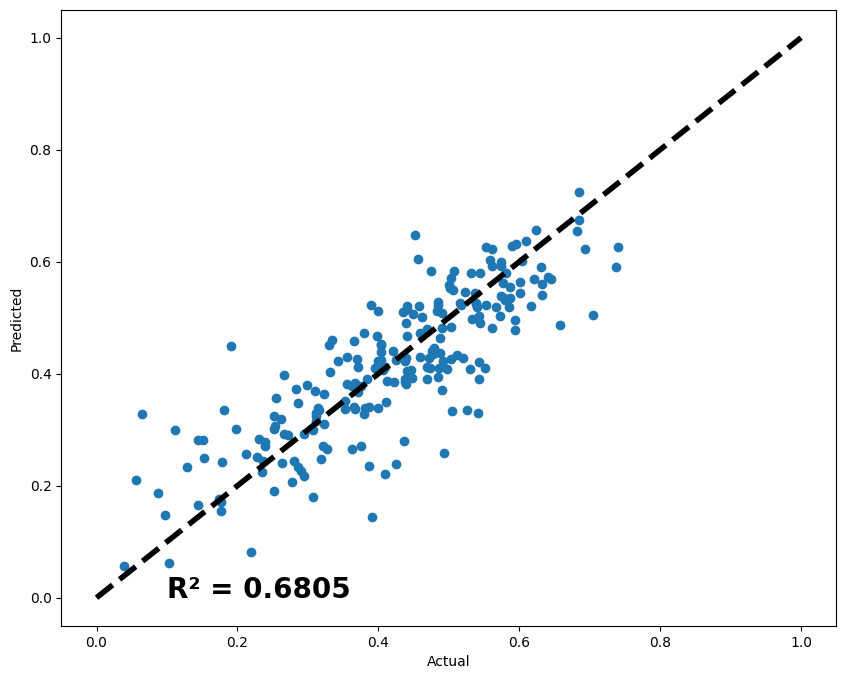

In [398]:
case1_LSTM_rmse,case1_LSTM_r2 = print_results(case1_LSTM,c1_datas[0][1],c1_datas[0][3],c1_datas[0][4],r2_save_path=SAVE_DIR+"case1/lstm/r2.png")

### MLP

In [381]:
# Number of finished trials: 100
# Best trial:
#   Value: 0.6615308458075573
#   Params: 
#     units_1: 64
#     units_2: 16
#     units_3: 8
#     lr: 0.0006179019336123294
#     epochs: 450

case1_MLP = Sequential()
case1_MLP.add(Dense(64, activation="relu", input_shape=(c1_datas[0][0].shape[1],1)))
case1_MLP.add(Dense(16, activation="relu"))
case1_MLP.add(Dense(8, activation="relu"))
case1_MLP.add(Flatten())
case1_MLP.add(Dense(1))

case1_MLP.compile(loss='mse', optimizer=Adam(lr=0.0006179019336123294), metrics=[RSquare()])
case1_MLP.load_weights(SAVE_DIR + "case1/mlp/best_model_weights.h5")

7/7 [==============================] - 0s 4ms/step
RMSE: 0.084470
R2: 0.661531


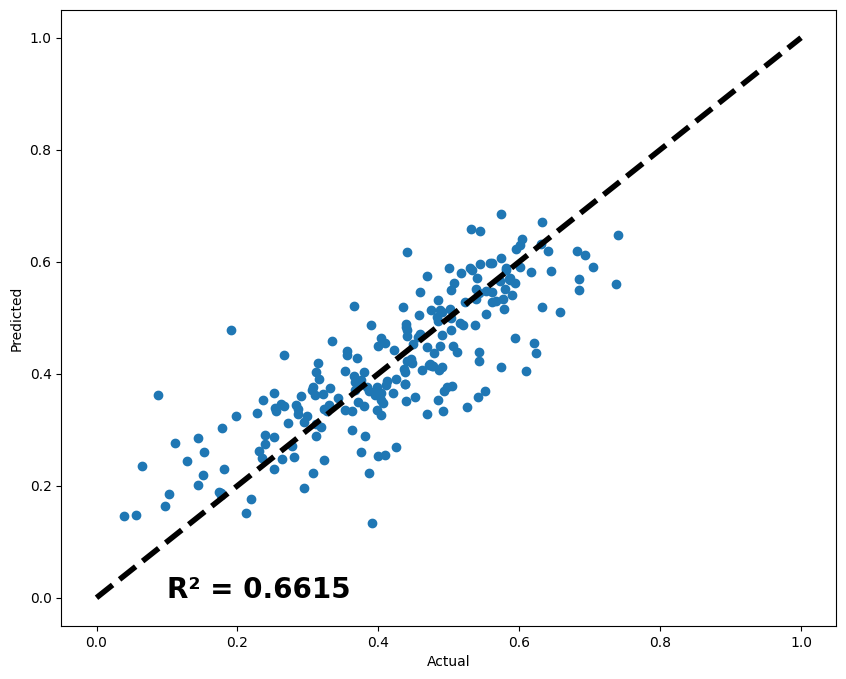

In [399]:
case1_MLP_rmse,case1_MLP_r2 = print_results(case1_MLP,c1_datas[0][1],c1_datas[0][3],c1_datas[0][4],r2_save_path=SAVE_DIR+"case1/mlp/r2.png")

### XGBoost

In [385]:
# Number of finished trials: 100
# Best trial:
#   Value: 0.006582029576683584
#   Params: 
#     max_depth: 10
#     learning_rate: 0.11061823114401359
#     n_estimators: 320
#     min_child_weight: 8
#     gamma: 0.010306477949256754
#     subsample: 0.5798385708077899
#     colsample_bytree: 0.34725690710652146
#     reg_alpha: 0.5045757289651549
#     reg_lambda: 0.11059537551525392
#     random_state: 664

param = {
    "max_depth": 10,
    "learning_rate": 0.11061823114401359,
    "n_estimators": 320,
    "min_child_weight": 8,
    "gamma": 0.010306477949256754,
    "subsample": 0.5798385708077899,
    "colsample_bytree": 0.34725690710652146,
    "reg_alpha": 0.5045757289651549,
    "reg_lambda": 0.11059537551525392,
    "random_state": 664
}
case1_XGB = xgb.XGBRegressor(**param)
case1_XGB.load_model("/Users/alperbalmumcu/Github/crop-yield-estimation/results/Case1/xgboost/best_model_weights.json")

RMSE: 0.081130
R2: 0.687770


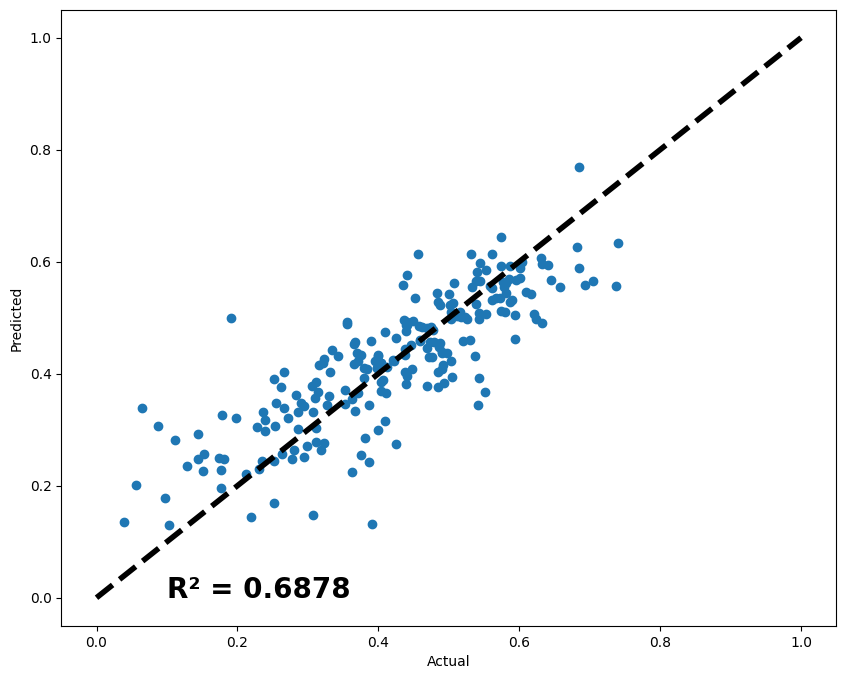

In [400]:
case1_XGB_rmse,case1_XGB_r2 = print_results(case1_XGB,c1_datas[0][1],c1_datas[0][3],c1_datas[0][4],r2_save_path=SAVE_DIR+"case1/xgboost/r2.png")

## Case 2

### LSTM

In [408]:
# Number of finished trials: 50
# Best trial:
#   Value: 0.7298488616943359
#   Params: 
#     units: 128
#     lr: 0.0009979805843283594
#     epochs: 350

clear_session()
case2_LSTM= Sequential()
case2_LSTM.add(LSTM(128, activation='tanh',input_shape=(c2_datas[0][0].shape[1],1))) 
case2_LSTM.add(Dense(1))

optimizer = Adam(lr=0.0009979805843283594)
case2_LSTM.compile(optimizer=optimizer, loss='mse',metrics=[RSquare()])
case2_LSTM.load_weights(SAVE_DIR + "Case2/lstm/best_model_weights.h5")

14/14 [==============================] - 1s 14ms/step
RMSE: 0.078019
R2: 0.738984


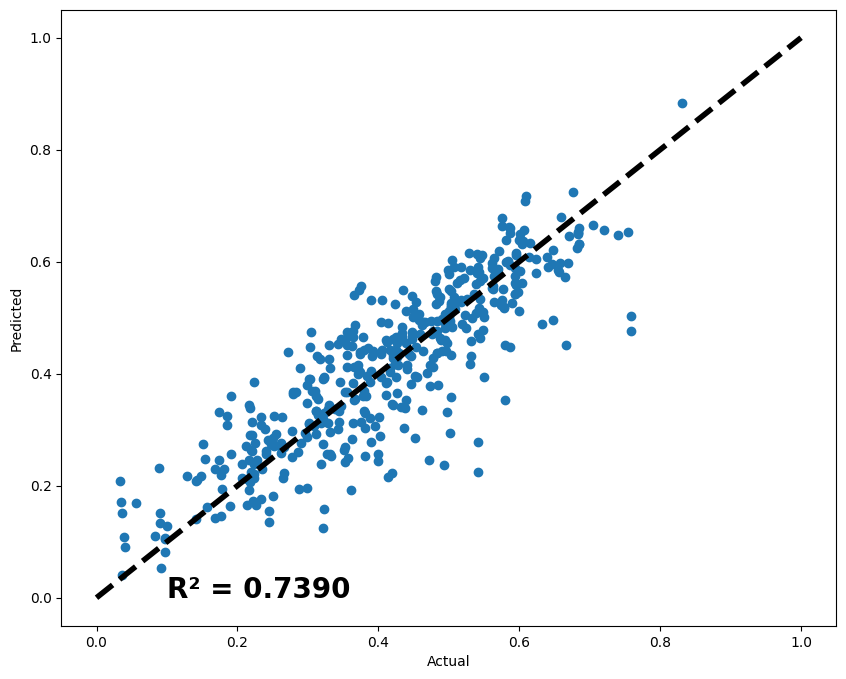

In [445]:
case2_LSTM_rmse,case2_LSTM_r2 = print_results(case2_LSTM,c2_datas[0][1],c2_datas[0][3],c2_datas[0][4],r2_save_path=SAVE_DIR+"Case2/lstm/r2.png")

### MLP

In [412]:
# Number of finished trials: 100
# Best trial:
#   Value: 0.7015099468987738
#   Params: 
#     units_1: 64
#     units_2: 64
#     units_3: 8
#     lr: 0.0004477381545587217
#     epochs: 410

case2_MLP = Sequential()
case2_MLP.add(Dense(64, activation="relu", input_shape=(c2_datas[0][0].shape[1],1)))
case2_MLP.add(Dense(64, activation="relu"))
case2_MLP.add(Dense(8, activation="relu"))
case2_MLP.add(Flatten())
case2_MLP.add(Dense(1))

case2_MLP.compile(loss='mse', optimizer=Adam(lr=0.0004477381545587217), metrics=[RSquare()])
case2_MLP.load_weights(SAVE_DIR + "case2/mlp/best_model_weights.h5")

14/14 [==============================] - 0s 5ms/step
RMSE: 0.083432
R2: 0.701510


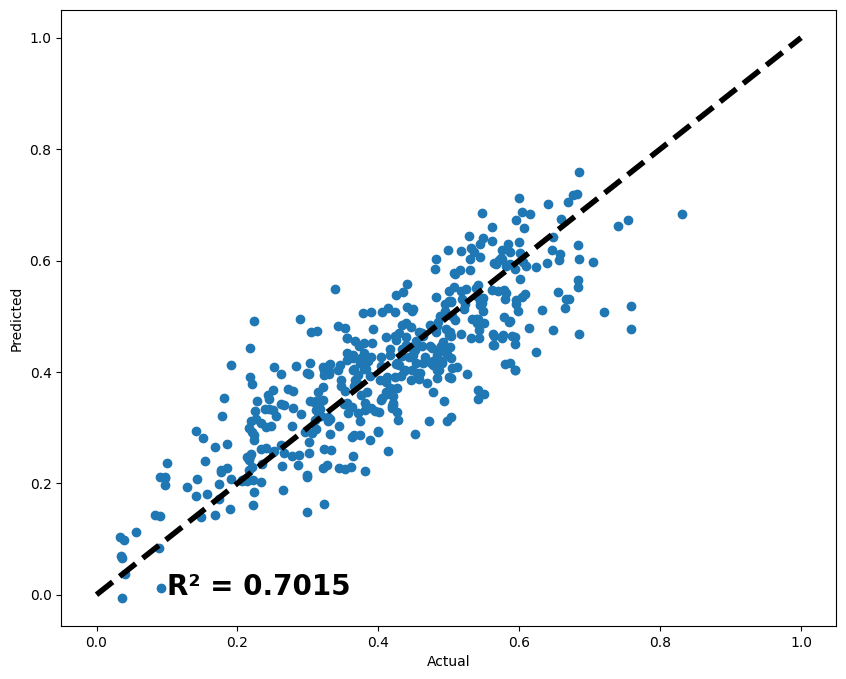

In [426]:
case2_MLP_rmse,case2_MLP_r2 = print_results(case2_MLP,c2_datas[0][1],c2_datas[0][3],c2_datas[0][4],r2_save_path=SAVE_DIR+"case2/mlp/r2.png")

### XGBoost

In [415]:
# Number of finished trials: 100
# Best trial:
#   Value: 0.0053504476703609164
#   Params: 
#     max_depth: 3
#     learning_rate: 0.31325649717042997
#     n_estimators: 757
#     min_child_weight: 2
#     gamma: 0.010312428841639115
#     subsample: 0.6735099756683387
#     colsample_bytree: 0.5420730527555989
#     reg_alpha: 0.46184044849096867
#     reg_lambda: 0.11693833306257394
#     random_state: 483

param = {
    "max_depth": 3,
    "learning_rate": 0.31325649717042997,
    "n_estimators": 757,
    "min_child_weight": 2,
    "gamma": 0.010312428841639115,
    "subsample": 0.6735099756683387,
    "colsample_bytree": 0.5420730527555989,
    "reg_alpha": 0.46184044849096867,
    "reg_lambda": 0.11693833306257394,
    "random_state": 483
}
case2_XGB = xgb.XGBRegressor(**param)
case2_XGB.load_model(SAVE_DIR + "case2/xgboost/best_model_weights.json")

RMSE: 0.073147
R2: 0.770566


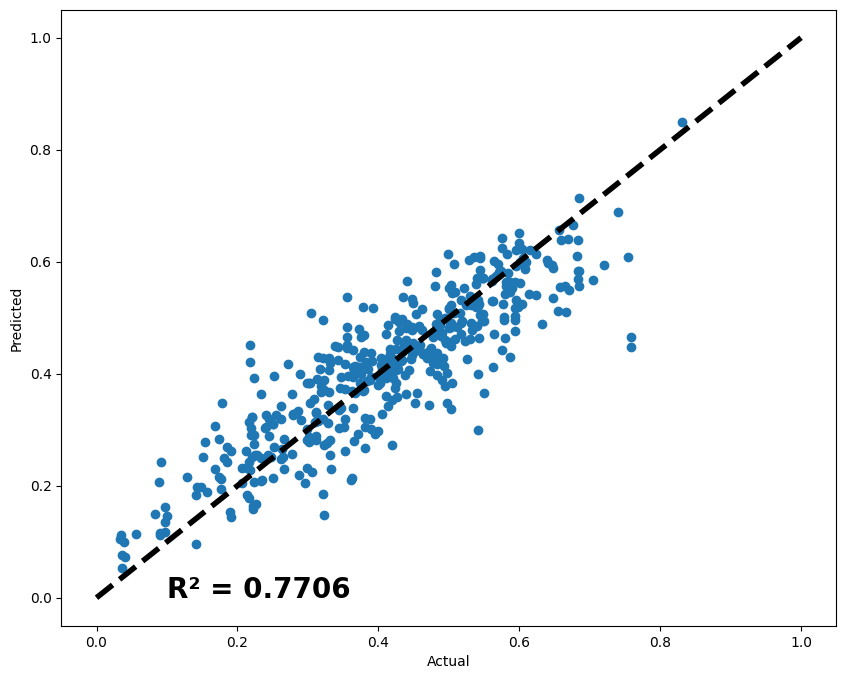

In [417]:
case2_XGB_rmse,case2_XGB_r2 = print_results(case2_XGB,c2_datas[0][1],c2_datas[0][3],c2_datas[0][4],r2_save_path=SAVE_DIR+"case2/xgboost/r2.png")

## Case 3

### LSTM

In [418]:
# Number of finished trials: 50
# Best trial:
#   Value: 0.7607760915513243
#   Params: 
#     units: 128
#     lr: 0.0004253464131467946
#     epochs: 320

clear_session()
case3_LSTM= Sequential()
case3_LSTM.add(LSTM(128, activation='tanh',input_shape=(c3_datas[0][0].shape[1],1))) 
case3_LSTM.add(Dense(1))

optimizer = Adam(lr=0.0004253464131467946)
case3_LSTM.compile(optimizer=optimizer, loss='mse',metrics=[RSquare()])
case3_LSTM.load_weights(SAVE_DIR + "case3/lstm/best_model_weights.h5")

21/21 [==============================] - 2s 14ms/step
RMSE: 0.082122
R2: 0.760776


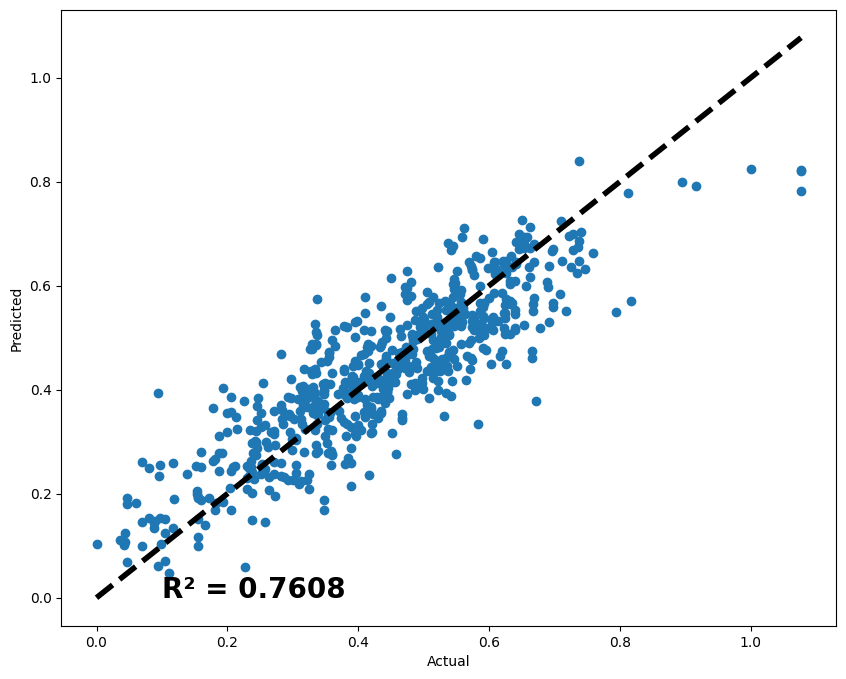

In [433]:
case3_LSTM_rmse,case3_LSTM_r2 = print_results(case3_LSTM,c3_datas[0][1],c3_datas[0][3],c3_datas[0][4],r2_save_path=SAVE_DIR+"case3/lstm/r2.png")

### MLP

In [430]:
# Number of finished trials: 100
# Best trial:
#   Value: 0.7130886927777256
#   Params: 
#     units_1: 256
#     units_2: 32
#     units_3: 8
#     lr: 0.000605511636281923
#     epochs: 420

case3_MLP = Sequential()
case3_MLP.add(Dense(256, activation="relu", input_shape=(c3_datas[0][0].shape[1],1)))
case3_MLP.add(Dense(32, activation="relu"))
case3_MLP.add(Dense(8, activation="relu"))
case3_MLP.add(Flatten())
case3_MLP.add(Dense(1))

case3_MLP.compile(loss='mse', optimizer=Adam(lr=0.000605511636281923), metrics=[RSquare()])
case3_MLP.load_weights(SAVE_DIR + "case3/mlp/best_model_weights.h5")

21/21 [==============================] - 1s 8ms/step
RMSE: 0.089936
R2: 0.713089


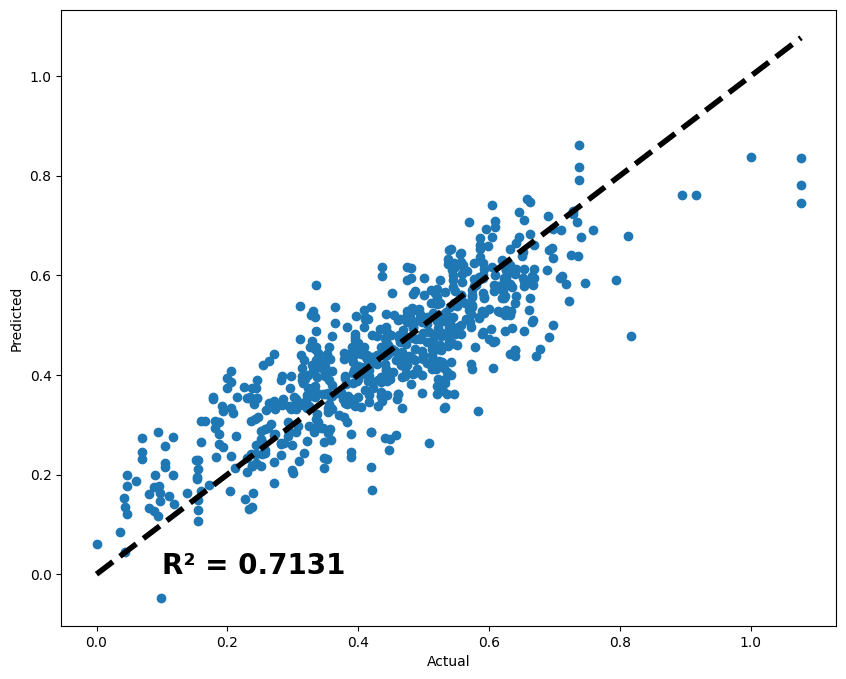

In [432]:
case3_MLP_rmse,case3_MLP_r2 = print_results(case3_MLP,c3_datas[0][1],c3_datas[0][3],c3_datas[0][4],r2_save_path=SAVE_DIR+"case3/mlp/r2.png")

### XGBoost

In [419]:
# Number of finished trials: 100
# Best trial:
#   Value: 0.005586109972063694
#   Params: 
#     max_depth: 6
#     learning_rate: 0.5776561057845523
#     n_estimators: 406
#     min_child_weight: 3
#     gamma: 0.029688898134754657
#     subsample: 0.9789265023319311
#     colsample_bytree: 0.5960863005175199
#     reg_alpha: 0.756038550251351
#     reg_lambda: 0.4850395728418791
#     random_state: 132

param = {
    "max_depth": 6,
    "learning_rate": 0.5776561057845523,
    "n_estimators": 406,
    "min_child_weight": 3,
    "gamma": 0.029688898134754657,
    "subsample": 0.9789265023319311,
    "colsample_bytree": 0.5960863005175199,
    "reg_alpha": 0.756038550251351,
    "reg_lambda": 0.4850395728418791,
    "random_state": 132
}
case3_XGB = xgb.XGBRegressor(**param)
case3_XGB.load_model(SAVE_DIR + "case3/xgboost/best_model_weights.json")

RMSE: 0.074740
R2: 0.801850


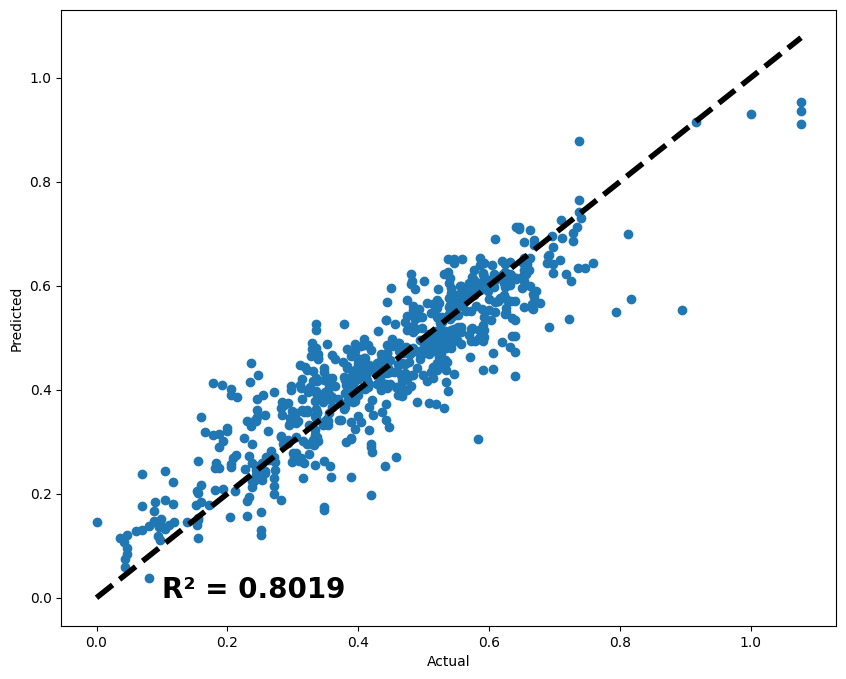

In [420]:
case3_XGB_rmse,case3_XGB_r2 = print_results(case3_XGB,c3_datas[0][1],c3_datas[0][3],c3_datas[0][4],r2_save_path=SAVE_DIR+"case3/xgboost/r2.png")

# SHAP

#### Top Interactions

In [ ]:
import re
def change_dynamic_indexes(input_string):
    # Define a regular expression pattern to match words with an underscore
    pattern = re.compile(r'(\w+)_(\d+)')
    mount_dict = {"4": 'APR', 
                  "5": 'MAY', 
                  "6": 'JUN', 
                  "7": 'JUL', 
                  "8": 'AUG', 
                  "9": 'SEP'}

    # Define a function to handle the replacement
    def replace(match):
        # Extract the components matched by the pattern
        word, index = match.groups()
        
        # Return the replacement string
        return f'$\mathregular{{{word.upper()}^{{{mount_dict[index]}}}}}$'
    
    # Use the sub function to replace the matched patterns in the input string
    result_string = pattern.sub(replace, input_string)
    
    return result_string


In [ ]:
def top_interactions(explainer,X_test_df, save_path):
    # Calculate SHAP interaction values
    shap_interaction_values = explainer.shap_interaction_values(X_test_df)

    # Calculate the mean absolute interaction values for each feature pair
    mean_interaction_values = abs(shap_interaction_values).mean(0)
    # Mask the diagonal (intra-feature interactions)

    masked_interaction_values = np.ma.masked_where(np.eye(mean_interaction_values.shape[0]), mean_interaction_values)

    # Extract the indices of the top 6 interactions between different features
    top_interactions = np.unravel_index(np.argsort(masked_interaction_values, axis=None)[::-1], mean_interaction_values.shape)
    top_interactions = list(zip(top_interactions[0], top_interactions[1]))
    top_interactions = [pair for pair in top_interactions if pair[0] != pair[1]][:30]

    # Get the feature names (replace these with your actual feature names)
    feature_names = X_test_df.columns

    # Extract feature names for the top 6 interactions
    top_interactions_names = [f"{change_dynamic_indexes(feature_names[i])} & {change_dynamic_indexes(feature_names[j])}" for i, j in top_interactions][::-1]

    # Get the corresponding importance values for the top 6 interactions
    top_values = [mean_interaction_values[i, j] for i, j in top_interactions][::-1]

    # Create a bar plot for the top 6 interactions between different features
    plt.figure(figsize=(10, 6))
    plt.barh(top_interactions_names[1::2], top_values[1::2])
    plt.xlabel('Mean Absolute Interaction Value')
    plt.ylabel('Feature Importance')
    plt.title('Top Interactions Between Different Features')
    plt.tight_layout(pad=3)  # Adjust pad parameter for padding

    plt.savefig(save_path)
    plt.show()


#### Contributions of Dynamic and Static Features

In [ ]:
def contributions(_shap_values,explainer,X_test_df,save_path):

    # Calculate SHAP values for dynamic and static features
    shap_values_dynamic = _shap_values[:, :42]
    shap_values_static = _shap_values[:, 42:]

    # Calculate mean absolute SHAP values for dynamic and static features
    mean_shap_dynamic = np.mean(np.abs(shap_values_dynamic), axis=0)
    mean_shap_static = np.mean(np.abs(shap_values_static), axis=0)

    # Calculate SHAP interaction values for all features
    shap_interaction_values_all = explainer.shap_interaction_values(X_test_df)

    # Calculate the mean absolute interaction values for each feature pair
    mean_interaction_values = np.mean(np.abs(shap_interaction_values_all), axis=0)

    # Calculate the contributions of dynamic and static features to the overall importance
    total_importance = np.sum(mean_shap_dynamic) + np.sum(mean_shap_static)
    dynamic_contribution = np.sum(mean_shap_dynamic) / total_importance
    static_contribution = np.sum(mean_shap_static) / total_importance

    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center',bbox = dict(facecolor = 'white', alpha =.8))

    # Create a bar plot to show the contributions of dynamic and static features
    plt.figure(figsize=(8,7))
    plt.bar('Dynamic Features', dynamic_contribution, width=0.5 ,color='skyblue', alpha=0.8)
    plt.bar('Static Features', static_contribution,width=0.5, color='orange', alpha=0.8)
    addlabels(['Dynamic Features','Static Features'],[dynamic_contribution,static_contribution])
    plt.ylabel('Contribution to Overall Importance')
    plt.title('Contribution of Dynamic and Static Features to Overall Importance')
    plt.ylim([0, 1])
    plt.savefig(save_path)
    plt.show()

    print(f"Dynamic Feature Importance: {dynamic_contribution}")
    print(f"Static Feature Importance: {static_contribution}")

#### HeatMap

In [ ]:
def heatmap_per_case(case1_shap_values,c1_dfs,save_fig):
    import seaborn as sns
    from matplotlib.colors import ListedColormap

    mount_dict = {'APR':4,
                'MAY':5,
                'JUN':6,
                'JUL':7,
                'AUG':8,
                'SEP':9
                }

    cols_rename = {
        0: c1_dfs[0][1].columns[1].upper(),
        1: c1_dfs[0][1].columns[2].upper(),
        2: c1_dfs[0][1].columns[3].upper(),
        3: c1_dfs[0][1].columns[4].upper(),
        4: c1_dfs[0][1].columns[5].upper(),
        5: c1_dfs[0][1].columns[6].upper(),
        6: c1_dfs[0][1].columns[7].upper()
    }

    dynamic_min = np.mean(case1_shap_values[:, :42], axis=0).reshape(7, 6).min()
    dynamic_max = np.mean(case1_shap_values[:, :42], axis=0).reshape(7, 6).max()

    def heatmap_dynamic(shap_values_dynamic,cols_rename,mount_dict,axis):
        df_tmp =  pd.DataFrame(np.mean(shap_values_dynamic, axis=0).reshape(7,6), columns=mount_dict.keys()).rename(cols_rename, axis='index')
        max_df_vals = np.max(df_tmp.values, axis=1)
        indices = df_tmp.index
        max_value_tuples = list(zip(indices, max_df_vals,range(0,7)))
        sorted_max_value_tuples = sorted(max_value_tuples, key=lambda x: x[1])
        sorted_indices = [t[0] for t in sorted_max_value_tuples]
        sorted_indices_nums = [t[2] for t in sorted_max_value_tuples]
        sorted_array_7x6 = df_tmp.values[sorted_indices_nums]

        sns.heatmap(pd.DataFrame(sorted_array_7x6, columns=df_tmp.columns).set_index(pd.Index(sorted_indices)).iloc[::-1],
                    annot=False, linewidth=1, linecolor='w',annot_kws={"size": 7}, ax = axis,cbar=False, cmap="YlGnBu",yticklabels=True)
        plt.yticks(rotation=0)

    def heatmap_static(shap_values_static, df,axis):
        sns.heatmap(pd.DataFrame(np.mean(shap_values_static, axis=0).reshape(1,8), columns=df.columns[8:-1]).rename({0: "Soil Params"}, axis='index'), 
                    annot=False, linewidth=1, linecolor='w',ax = axis,cbar=False, cmap="YlGnBu" , vmin=dynamic_min, vmax=dynamic_max)
        
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 9, 1.5]})

    norm = plt.Normalize(vmin=np.min([np.mean(case1_shap_values[: , :42], axis=0).reshape(7,6).min(), np.mean(case1_shap_values[: , 42:], axis=0).reshape(1,8).min()]),
                        vmax=np.max([np.mean(case1_shap_values[: , :42], axis=0).reshape(7,6).max(), np.mean(case1_shap_values[: , 42:], axis=0).reshape(1,8).max()]))
    
    cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu')
    cbar.set_array([])

    heatmap_dynamic(case1_shap_values[: , :42],cols_rename,mount_dict, ax2)
    heatmap_static(case1_shap_values[: , 42:],c1_dfs[0][1], ax3)

    cbar_ax = plt.gcf().add_axes([0.1, 0.9, 0.85, 0.05]) 
    plt.colorbar(cbar, cax=cbar_ax,orientation='horizontal',ax=ax1, ticks=np.linspace(dynamic_min, dynamic_max, 7))
    ax1.axis('off')

    plt.tight_layout()
    plt.title("Global Importance")
    plt.savefig(save_fig)
    plt.show()

    

## Case 1

In [ ]:
X_test_df_case1 = pd.DataFrame(X_test_scaled, columns = c1_dfs[0][2].columns[:-1])

explainer_xgb_case1 = shap.TreeExplainer(xg_reg_full)
case1_shap_values = explainer_xgb_case1.shap_values(X_test_df_case1)

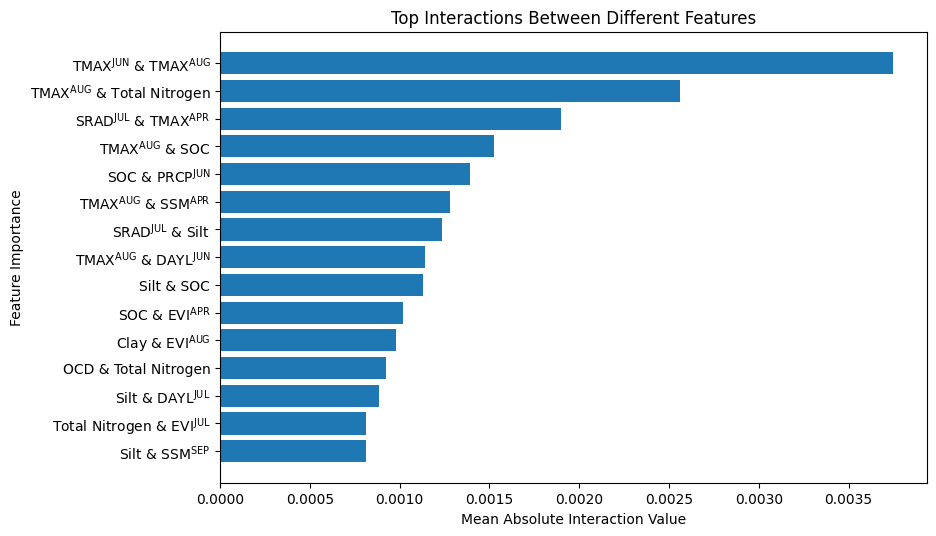

In [ ]:
case_1_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case1_top_interactions.png'

top_interactions(explainer_xgb_case1,X_test_df_case1,case_1_path)

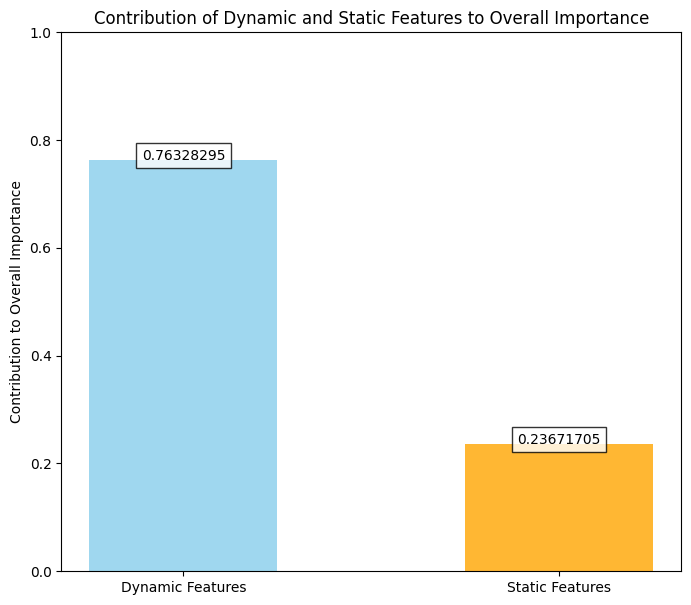

Dynamic Feature Importance: 0.7632829546928406
Static Feature Importance: 0.23671704530715942


In [ ]:
save_fig_case1 = "/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case1_contributions.png"
contributions(case1_shap_values,explainer_xgb_case1,X_test_df_case1,save_fig_case1)

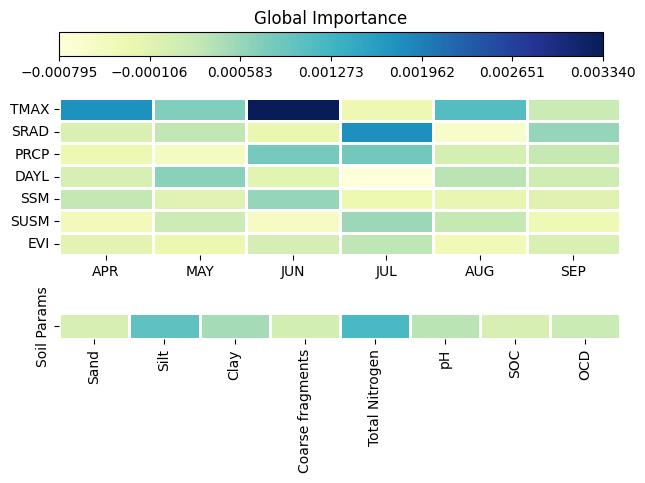

In [ ]:
heatmap_per_case(case1_shap_values,c1_dfs,save_fig="/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case1_global_importance.png")

## Case 2

In [ ]:
X_test_df_case2 = pd.DataFrame(X_test_scaled_10_15, columns = c2_dfs[0][2].columns[:-1])

explainer_xgb_case2 = shap.TreeExplainer(xg_reg_full_16)
case2_shap_values = explainer_xgb_case2.shap_values(X_test_df_case2)

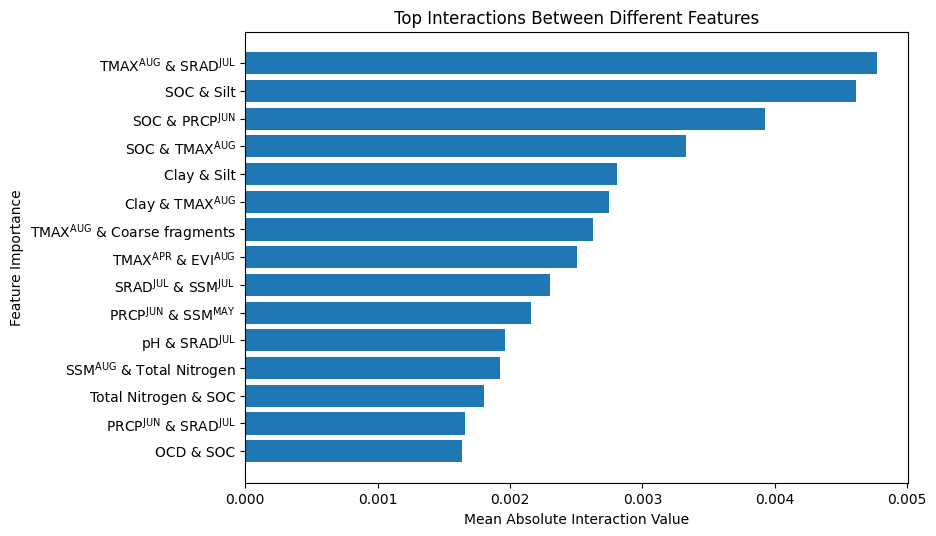

In [ ]:
case_2_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case2_top_interactions.png'

top_interactions(explainer_xgb_case2,X_test_df_case2,case_2_path)

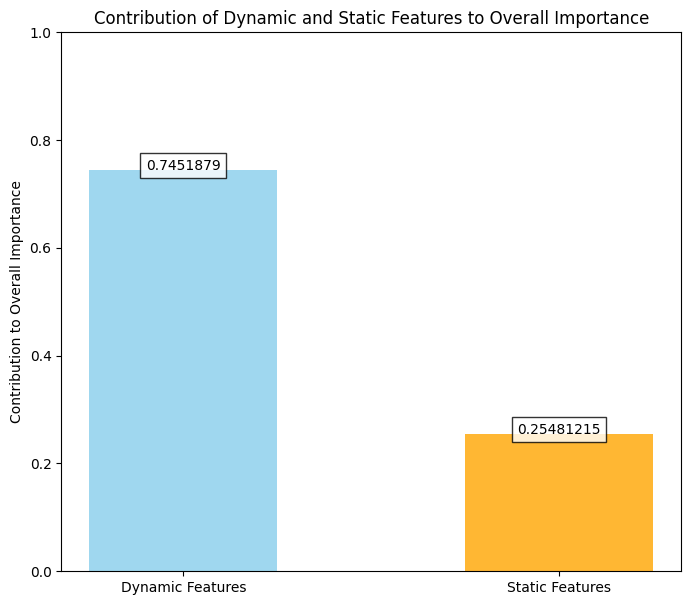

Dynamic Feature Importance: 0.7451878786087036
Static Feature Importance: 0.2548121511936188


In [ ]:
save_fig_case2 = "/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case2_contributions.png"

contributions(case2_shap_values,explainer_xgb_case2,X_test_df_case2,save_fig_case2)

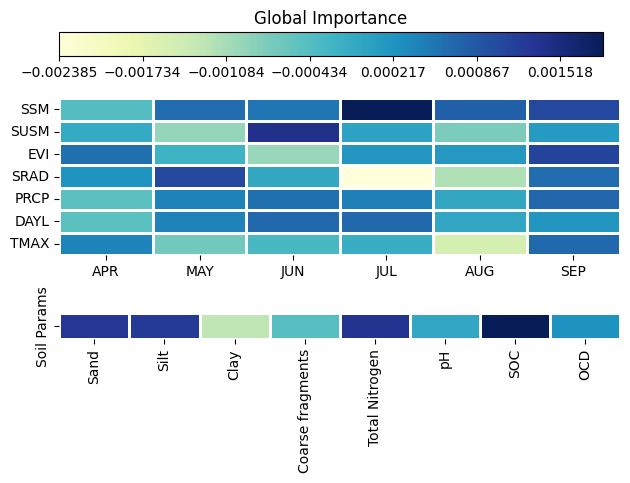

In [ ]:
heatmap_per_case(case2_shap_values,c2_dfs,save_fig="/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case2_global_importance.png")

## Case 3

In [ ]:
X_test_df_case3 = pd.DataFrame(X_test_scaled_10_15_20, columns = c3_dfs[0][2].columns[:-1])

explainer_xgb_case3 = shap.TreeExplainer(xg_reg_full_14)
case3_shap_values = explainer_xgb_case3.shap_values(X_test_df_case3)

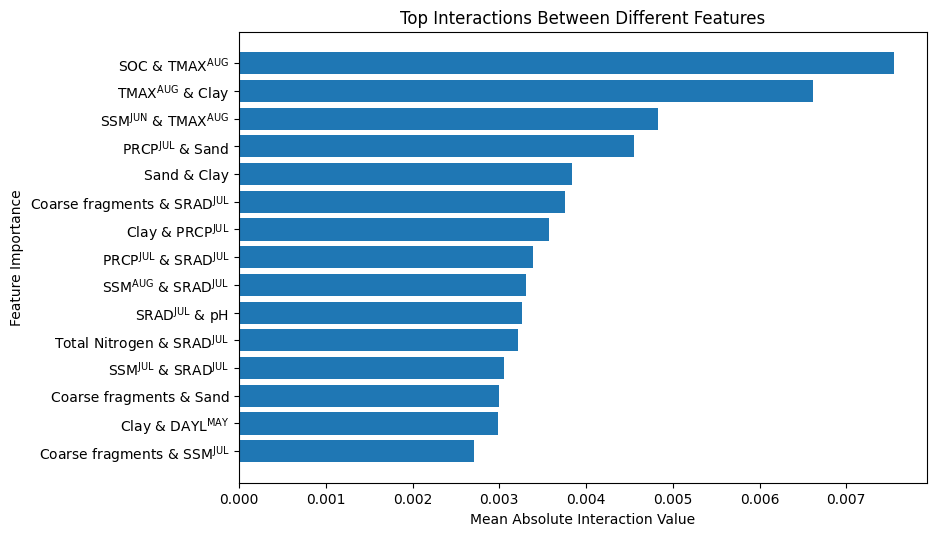

In [ ]:
case_3_path = '/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case3_top_interactions.png'

top_interactions(explainer_xgb_case3,X_test_df_case3,case_3_path)

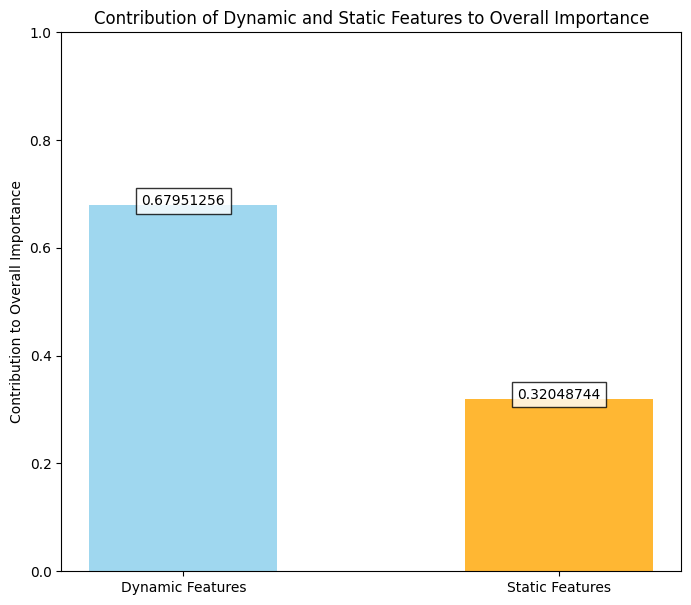

Dynamic Feature Importance: 0.6795125603675842
Static Feature Importance: 0.32048743963241577


In [ ]:
save_fig_case3 = "/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case3_contributions.png"
contributions(case3_shap_values,explainer_xgb_case3,X_test_df_case3,save_fig_case3)

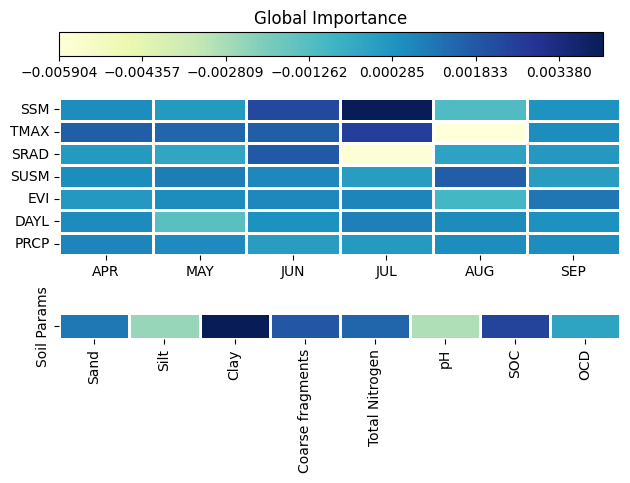

In [ ]:
heatmap_per_case(case3_shap_values,c3_dfs,save_fig="/Users/alperbalmumcu/Github/crop-yield-estimation/results/feature_importance/case3_global_importance.png")

# Evaluation

In [450]:
def plot_case_comparation(branches,y1,y2,y3):
   import plotly.graph_objs as go
   from plotly.offline import iplot

   trace1 = go.Bar(
      x = branches,
      y = y1,
      name = 'case1'
   )
   trace2 = go.Bar(
      x = branches,
      y = y2,
      name = 'case2'
   )
   trace3 = go.Bar(
      x = branches,
      y = y3,
      name = 'case3'
   )
   data = [trace1, trace2, trace3]
   layout = go.Layout(barmode = 'group',title="R2 Comparison of All Models in All Cases")
   fig = go.Figure(data = data, layout = layout)
   iplot(fig)

In [451]:
r2_scores_case1 = [case1_LSTM_r2,
                   case1_MLP_r2,
                   case1_XGB_r2]

r2_scores_case2 = [case2_LSTM_r2, 
                   case2_MLP_r2, 
                   case2_XGB_r2]

r2_scores_case3 = [case3_LSTM_r2,
                   case3_MLP_r2,
                   case3_XGB_r2]


branches = ['LSTM', 'MLP', 'XGB']

plot_case_comparation(branches,
                      r2_scores_case1,
                      r2_scores_case2,
                      r2_scores_case3)


In [439]:
rmse_scores_case1 = [case1_LSTM_rmse,
                   case1_MLP_rmse,
                   case1_XGB_rmse]

rmse_scores_case2 = [case2_LSTM_rmse, 
                   case2_MLP_rmse, 
                   case2_XGB_rmse]

rmse_scores_case3 = [case3_LSTM_rmse,
                   case3_MLP_rmse,
                   case3_XGB_rmse]


branches = ['LSTM', 'MLP', 'XGB']

plot_case_comparation(branches,
                      rmse_scores_case1,
                      rmse_scores_case2,
                      rmse_scores_case3)


In [444]:
data = {
    'Model': ['LSTM', 'MLP', 'XGB'],
    'RMSE (case1)': rmse_scores_case1,
    'RMSE (case2)': rmse_scores_case2,
    'RMSE (case3)': rmse_scores_case3,
    'R2 Score (case1)': r2_scores_case1,
    'R2 Score (case2)': r2_scores_case2,
    'R2 Score (case3)': r2_scores_case3
}

# Create a DataFrame from the data dictionary
df = pd.DataFrame(data)

# Set the 'Model' column as the index
df.set_index('Model', inplace=True)

# Display the table
df.head()

RMSE (case1)  RMSE (case2)  RMSE (case3)  R2 Score (case1)  \
Model                                                               
LSTM       0.082065      0.078019      0.082122          0.680532   
MLP        0.084470      0.083432      0.089936          0.661531   
XGB        0.081130      0.073147      0.074740          0.687770   

       R2 Score (case2)  R2 Score (case3)  
Model                                      
LSTM           0.738984          0.760776  
MLP            0.701510          0.713089  
XGB            0.770566          0.801850